# Proyek Akhir: Menyelesaikan Permasalahan Student Performance

- Nama: Bimo Ade Budiman Fikri
- Email: 222111956
- Id Dicoding: A406YBM098

## Persiapan

### Menyiapkan library yang dibutuhkan

In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import joblib

pd.set_option('display.max_columns', None)

### Menyiapkan data yang akan diguankan

## Data Understanding

### Data Loading

In [2]:
df = pd.read_csv('data\data.csv', sep=';')
df

Marital_status  Application_mode  Application_order  Course  \
0                  1                17                  5     171   
1                  1                15                  1    9254   
2                  1                 1                  5    9070   
3                  1                17                  2    9773   
4                  2                39                  1    8014   
...              ...               ...                ...     ...   
4419               1                 1                  6    9773   
4420               1                 1                  2    9773   
4421               1                 1                  1    9500   
4422               1                 1                  1    9147   
4423               1                10                  1    9773   

      Daytime_evening_attendance  Previous_qualification  \
0                              1                       1   
1                              1                       1   
2                              1                       1   
3                              1                       1   
4                              0                       1   
...                          ...                     ...   
4419                           1                       1   
4420                           1                       1   
4421                           1                       1   
4422                           1                       1   
4423                           1                       1   

      Previous_qualification_grade  Nacionality  Mothers_qualification  \
0                            122.0            1                     19   
1                            160.0            1                      1   
2                            122.0            1                     37   
3                            122.0            1                     38   
4                            100.0            1                     37   
...                            ...          ...                    ...   
4419                         125.0            1                      1   
4420                         120.0          105                      1   
4421                         154.0            1                     37   
4422                         180.0            1                     37   
4423                         152.0           22                     38   

      Fathers_qualification  Mothers_occupation  Fathers_occupation  \
0                        12                   5                   9   
1                         3                   3                   3   
2                        37                   9                   9   
3                        37                   5                   3   
4                        38                   9                   9   
...                     ...                 ...                 ...   
4419                      1                   5                   4   
4420                      1                   9                   9   
4421                     37                   9                   9   
4422                     37                   7                   4   
4423                     37                   5                   9   

      Admission_grade  Displaced  Educational_special_needs  Debtor  \
0               127.3          1                          0       0   
1               142.5          1                          0       0   
2               124.8          1                          0       0   
3               119.6          1                          0       0   
4               141.5          0                          0       0   
...               ...        ...                        ...     ...   
4419            122.2          0                          0       0   
4420            119.0          1                          0       1   
4421            149.5          1                          0       0   
4422

### Data Inspection (before)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

In [4]:
df[['Marital_status']].value_counts()

Marital_status
1                 3919
2                  379
4                   91
5                   25
6                    6
3                    4
Name: count, dtype: int64

### Datatype Casting

In [5]:
marital_status_mapping = {
    1: 'single', 2: 'married', 3: 'widower', 4: 'divorced', 5: 'facto union', 6: 'legally separated'
}

application_mode_mapping = {
    1: '1st phase - general contingent', 2: 'Ordinance No. 612/93',
    5: '1st phase - special contingent (Azores Island)', 7: 'Holders of other higher courses',
    10: 'Ordinance No. 854-B/99', 15: 'International student (bachelor)',
    16: '1st phase - special contingent (Madeira Island)', 17: '2nd phase - general contingent',
    18: '3rd phase - general contingent', 26: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
    27: 'Ordinance No. 533-A/99, item b3 (Other Institution)', 39: 'Over 23 years old',
    42: 'Transfer', 43: 'Change of course', 44: 'Technological specialization diploma holders',
    51: 'Change of institution/course', 53: 'Short cycle diploma holders',
    57: 'Change of institution/course (International)'
}

course_mapping = {
    33: 'Biofuel Production Technologies', 171: 'Animation and Multimedia Design',
    8014: 'Social Service (evening attendance)', 9003: 'Agronomy',
    9070: 'Communication Design', 9085: 'Veterinary Nursing',
    9119: 'Informatics Engineering', 9130: 'Equinculture',
    9147: 'Management', 9238: 'Social Service', 9254: 'Tourism',
    9500: 'Nursing', 9556: 'Oral Hygiene',
    9670: 'Advertising and Marketing Management', 9773: 'Journalism and Communication',
    9853: 'Basic Education', 9991: 'Management (evening attendance)'
}

daytime_evening_attendance_mapping = {
    1: 'daytime', 0: 'evening'
}

previous_qualification_mapping = {
    1: 'Secondary education', 2: 'Higher education - bachelor\'s degree',
    3: 'Higher education - degree', 4: 'Higher education - master\'s',
    5: 'Higher education - doctorate', 6: 'Frequency of higher education',
    9: '12th year of schooling - not completed', 10: '11th year of schooling - not completed',
    12: 'Other - 11th year of schooling', 14: '10th year of schooling',
    15: '10th year of schooling - not completed',
    19: 'Basic education 3rd cycle (9th/10th/11th year) or equiv.',
    38: 'Basic education 2nd cycle (6th/7th/8th year) or equiv.',
    39: 'Technological specialization course', 40: 'Higher education - degree (1st cycle)',
    42: 'Professional higher technical course', 43: 'Higher education - master (2nd cycle)'
}

nacionality_mapping = {
    1: 'Portuguese', 2: 'German', 6: 'Spanish', 11: 'Italian', 13: 'Dutch',
    14: 'English', 17: 'Lithuanian', 21: 'Angolan', 22: 'Cape Verdean',
    24: 'Guinean', 25: 'Mozambican', 26: 'Santomean', 32: 'Turkish',
    41: 'Brazilian', 62: 'Romanian', 100: 'Moldova (Republic of)',
    101: 'Mexican', 103: 'Ukrainian', 105: 'Russian', 108: 'Cuban',
    109: 'Colombian'
}

mothers_qualification_mapping = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: 'Higher Education - Bachelor\'s Degree', 3: 'Higher Education - Degree',
    4: 'Higher Education - Master\'s', 5: 'Higher Education - Doctorate',
    6: 'Frequency of Higher Education', 9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed', 11: '7th Year (Old)',
    12: 'Other - 11th Year of Schooling', 14: '10th Year of Schooling',
    18: 'General commerce course',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    22: 'Technical-professional course', 26: '7th year of schooling',
    27: '2nd cycle of the general high school course',
    29: '9th Year of Schooling - Not Completed', 30: '8th year of schooling',
    34: 'Unknown', 35: 'Can\'t read or write',
    36: 'Can read without having a 4th year of schooling',
    37: 'Basic education 1st cycle (4th/5th year) or equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological specialization course', 40: 'Higher education - degree (1st cycle)',
    41: 'Specialized higher studies course',
    42: 'Professional higher technical course', 43: 'Higher Education - Master (2nd cycle)',
    44: 'Higher Education - Doctorate (3rd cycle)'
}

fathers_qualification_mapping = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: 'Higher Education - Bachelor\'s Degree', 3: 'Higher Education - Degree',
    4: 'Higher Education - Master\'s', 5: 'Higher Education - Doctorate',
    6: 'Frequency of Higher Education', 9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed', 11: '7th Year (Old)',
    12: 'Other - 11th Year of Schooling', 13: '2nd year complementary high school course',
    14: '10th Year of Schooling', 18: 'General commerce course',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    20: 'Complementary High School Course', 22: 'Technical-professional course',
    25: 'Complementary High School Course - not concluded', 26: '7th year of schooling',
    27: '2nd cycle of the general high school course',
    29: '9th Year of Schooling - Not Completed', 30: '8th year of schooling',
    31: 'General Course of Administration and Commerce',
    33: 'Supplementary Accounting and Administration', 34: 'Unknown',
    35: 'Can\'t read or write',
    36: 'Can read without having a 4th year of schooling',
    37: 'Basic education 1st cycle (4th/5th year) or equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological specialization course', 40: 'Higher education - degree (1st cycle)',
    41: 'Specialized higher studies course',
    42: 'Professional higher technical course', 43: 'Higher Education - Master (2nd cycle)',
    44: 'Higher Education - Doctorate (3rd cycle)'
}

mothers_occupation_mapping = {
    0: 'Student', 1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions', 4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers', 10: 'Armed Forces Professions',
    90: 'Other Situation', 99: '(blank)', 122: 'Health professionals',
    123: 'teachers', 125: 'Specialists in information and communication technologies (ICT)',
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff', 151: 'personal service workers',
    152: 'sellers', 153: 'Personal care workers and the like',
    171: 'Skilled construction workers and the like, except electricians',
    173: 'Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like',
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    191: 'cleaning workers',
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants'
}

fathers_occupation_mapping = {
    0: 'Student', 1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions', 4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers', 10: 'Armed Forces Professions',
    90: 'Other Situation', 99: '(blank)', 101: 'Armed Forces Officers',
    102: 'Armed Forces Sergeants', 103: 'Other Armed Forces personnel',
    112: 'Directors of administrative and commercial services',
    114: 'Hotel, catering, trade and other services directors',
    121: 'Specialists in the physical sciences, mathematics, engineering and related techniques',
    122: 'Health professionals', 123: 'teachers',
    124: 'Specialists in finance, accounting, administrative organization, public and commercial relations',
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    135: 'Information and communication technology technicians',
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff', 151: 'personal service workers',
    152: 'sellers', 153: 'Personal care workers and the like',
    154: 'Protection and security services personnel',
    161: 'Market-oriented farmers and skilled agricultural and animal production workers',
    163: 'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence',
    171: 'Skilled construction workers and the like, except electricians',
    172: 'Skilled workers in metallurgy, metalworking and similar',
    174: 'Skilled workers in electricity and electronics',
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    181: 'Fixed plant and machine operators', 182: 'assembly workers',
    183: 'Vehicle drivers and mobile equipment operators',
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants',
    195: 'Street vendors (except food) and street service providers'
}

binary_mapping = {1: 'yes', 0: 'no'}
gender_mapping = {1: 'male', 0: 'female'}

new_df = df.copy()

new_df['Marital_status'] = new_df['Marital_status'].map(marital_status_mapping).astype('category')
new_df['Application_mode'] = new_df['Application_mode'].map(application_mode_mapping).astype('category')
new_df['Course'] = new_df['Course'].map(course_mapping).astype('category')
new_df['Daytime_evening_attendance'] = new_df['Daytime_evening_attendance'].map(daytime_evening_attendance_mapping).astype('category')
new_df['Previous_qualification'] = new_df['Previous_qualification'].map(previous_qualification_mapping).astype('category')
new_df['Nacionality'] = new_df['Nacionality'].map(nacionality_mapping).astype('category')
new_df['Mothers_qualification'] = new_df['Mothers_qualification'].map(mothers_qualification_mapping).astype('category')
new_df['Fathers_qualification'] = new_df['Fathers_qualification'].map(fathers_qualification_mapping).astype('category')
new_df['Mothers_occupation'] = new_df['Mothers_occupation'].map(mothers_occupation_mapping).astype('category')
new_df['Fathers_occupation'] = new_df['Fathers_occupation'].map(fathers_occupation_mapping).astype('category')

# Apply binary mappings
new_df['Displaced'] = new_df['Displaced'].map(binary_mapping).astype('category')
new_df['Educational_special_needs'] = new_df['Educational_special_needs'].map(binary_mapping).astype('category')
new_df['Debtor'] = new_df['Debtor'].map(binary_mapping).astype('category')
new_df['Tuition_fees_up_to_date'] = new_df['Tuition_fees_up_to_date'].map(binary_mapping).astype('category')
new_df['Gender'] = new_df['Gender'].map(gender_mapping).astype('category')
new_df['Scholarship_holder'] = new_df['Scholarship_holder'].map(binary_mapping).astype('category')
new_df['International'] = new_df['International'].map(binary_mapping).astype('category')

# Ensure 'Status' is also categorical
new_df['Status'] = new_df['Status'].astype('category')

# Confirm dtypes (optional, for verification)
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   int64   
 3   Course                                        4424 non-null   category
 4   Daytime_evening_attendance                    4424 non-null   category
 5   Previous_qualification                        4424 non-null   category
 6   Previous_qualification_grade                  4424 non-null   float64 
 7   Nacionality                                   4424 non-null   category
 8   Mothers_qualification                         4424 non-null   category
 9   Fathers_qualification                         4424 n

In [6]:
new_df

Marital_status                  Application_mode  Application_order  \
0            single    2nd phase - general contingent                  5   
1            single  International student (bachelor)                  1   
2            single    1st phase - general contingent                  5   
3            single    2nd phase - general contingent                  2   
4           married                 Over 23 years old                  1   
...             ...                               ...                ...   
4419         single    1st phase - general contingent                  6   
4420         single    1st phase - general contingent                  2   
4421         single    1st phase - general contingent                  1   
4422         single    1st phase - general contingent                  1   
4423         single            Ordinance No. 854-B/99                  1   

                                   Course Daytime_evening_attendance  \
0         Animation and Multimedia Design                    daytime   
1                                 Tourism                    daytime   
2                    Communication Design                    daytime   
3            Journalism and Communication                    daytime   
4     Social Service (evening attendance)                    evening   
...                                   ...                        ...   
4419         Journalism and Communication                    daytime   
4420         Journalism and Communication                    daytime   
4421                              Nursing                    daytime   
4422                           Management                    daytime   
4423         Journalism and Communication                    daytime   

     Previous_qualification  Previous_qualification_grade   Nacionality  \
0       Secondary education                         122.0    Portuguese   
1       Secondary education                         160.0    Portuguese   
2       Secondary education                         122.0    Portuguese   
3       Secondary education                         122.0    Portuguese   
4       Secondary education                         100.0    Portuguese   
...                     ...                           ...           ...   
4419    Secondary education                         125.0    Portuguese   
4420    Secondary education                         120.0       Russian   
4421    Secondary education                         154.0    Portuguese   
4422    Secondary education                         180.0    Portuguese   
4423    Secondary education                         152.0  Cape Verdean   

                                  Mothers_qualification  \
0     Basic Education 3rd Cycle (9th/10th/11th Year)...   
1     Secondary Education - 12th Year of Schooling o...   
2     Basic education 1st cycle (4th/5th year) or eq...   
3     Basic Education 2nd Cycle (6th/7th/8th Year) o...   
4     Basic education 1st cycle (4th/5th year) or eq...   
...                                                 ...   
4419  Secondary Education - 12th Year of Schooling o...   
4420  Secondary Education - 12th Year of Schooling o...   
4421  Basic education 1st cycle (4th/5th year) or eq...   
4422  Basic education 1st cycle (4th/5th year) or eq...   
4423  Basic Education 2nd Cycle (6th/7th/8th Year) o...   

                                  Fathers_qualification  \
0                        Other - 11th Year of Schooling   
1                             Higher Education - Degree   
2     Basic education 1st cycle (4th/5th year) or eq...   
3     Basic education 1st cycle (4th/5th year) or eq...   
4     Basic Education 2nd Cycle (6th/7th/8th Year) o...   
...                                                 ...   
4419  Secondary Education - 12th Year of Schooling o...   
4420  Secondary Education - 12th Year of Schooling o...   
4421  Basic education 1st cycle (4th/5th year) or eq...   
4422  Basic education 1st c

### Data Inspection (after)

In [7]:
numerical_cols = new_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols

['Application_order',
 'Previous_qualification_grade',
 'Admission_grade',
 'Age_at_enrollment',
 'Curricular_units_1st_sem_credited',
 'Curricular_units_1st_sem_enrolled',
 'Curricular_units_1st_sem_evaluations',
 'Curricular_units_1st_sem_approved',
 'Curricular_units_1st_sem_grade',
 'Curricular_units_1st_sem_without_evaluations',
 'Curricular_units_2nd_sem_credited',
 'Curricular_units_2nd_sem_enrolled',
 'Curricular_units_2nd_sem_evaluations',
 'Curricular_units_2nd_sem_approved',
 'Curricular_units_2nd_sem_grade',
 'Curricular_units_2nd_sem_without_evaluations',
 'Unemployment_rate',
 'Inflation_rate',
 'GDP']

In [8]:
categorical_cols = new_df.select_dtypes(include=['category']).columns.tolist()
categorical_cols

['Marital_status',
 'Application_mode',
 'Course',
 'Daytime_evening_attendance',
 'Previous_qualification',
 'Nacionality',
 'Mothers_qualification',
 'Fathers_qualification',
 'Mothers_occupation',
 'Fathers_occupation',
 'Displaced',
 'Educational_special_needs',
 'Debtor',
 'Tuition_fees_up_to_date',
 'Gender',
 'Scholarship_holder',
 'International',
 'Status']

### Missing Value

In [9]:
missing_values = new_df.isnull().sum()
missing_percent = (missing_values / len(new_df)) * 100
missing_df = pd.DataFrame({'Missing Value':missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Value'] > 0].sort_values(by='Missing Value', ascending=False)

if not missing_df.empty:
    print("Missing Values:")
    missing_df
else:
    print("Tidak ada nilai yang hilang dalam dataset.")

Tidak ada nilai yang hilang dalam dataset.


### Duplicates

In [10]:
num_duplicates = new_df.duplicated().sum()
print(f"Jumlah baris data yang terduplikasi: {num_duplicates}")

Jumlah baris data yang terduplikasi: 0


### Constant Features

In [11]:
unique_counts = new_df.nunique()
constant_columns = unique_counts[unique_counts == 1].index.tolist()

if constant_columns:
    print(f"Fitur konstan (hanya 1 nilai unik): {constant_columns}")
else:
    print("Tidak ditemukan kolom dengan nilai konstan.")

Tidak ditemukan kolom dengan nilai konstan.


### EDA

#### Summary

In [12]:
new_df[categorical_cols].describe().T

count unique  \
Marital_status              4424      6   
Application_mode            4424     18   
Course                      4424     17   
Daytime_evening_attendance  4424      2   
Previous_qualification      4424     17   
Nacionality                 4424     21   
Mothers_qualification       4424     29   
Fathers_qualification       4424     34   
Mothers_occupation          4424     32   
Fathers_occupation          4424     46   
Displaced                   4424      2   
Educational_special_needs   4424      2   
Debtor                      4424      2   
Tuition_fees_up_to_date     4424      2   
Gender                      4424      2   
Scholarship_holder          4424      2   
International               4424      2   
Status                      4424      3   

                                                                          top  \
Marital_status                                                         single   
Application_mode                               1st phase - general contingent   
Course                                                                Nursing   
Daytime_evening_attendance                                            daytime   
Previous_qualification                                    Secondary education   
Nacionality                                                        Portuguese   
Mothers_qualification       Secondary Education - 12th Year of Schooling o...   
Fathers_qualification       Basic education 1st cycle (4th/5th year) or eq...   
Mothers_occupation                                          Unskilled Workers   
Fathers_occupation                                          Unskilled Workers   
Displaced                                                                 yes   
Educational_special_needs                                                  no   
Debtor                                                                     no   
Tuition_fees_up_to_date                                                   yes   
Gender                                                                 female   
Scholarship_holder                                                         no   
International                                                              no   
Status                                                               Graduate   

                            freq  
Marital_status              3919  
Application_mode            1708  
Course                       766  
Daytime_evening_attendance  3941  
Previous_qualification      3717  
Nacionality                 4314  
Mothers_qualification       1069  
Fathers_qualification       1209  
Mothers_occupation          1577  
Fathers_occupation          1010  
Displaced                   2426  
Educational_special_needs   4373  
Debtor                      3921  
Tuition_fees_up_to_date     3896  
Gender                      2868  
Scholarship_holder          3325  
International               4314  
Status                      2209

In [13]:
new_df[numerical_cols].describe().T

count        mean        std  \
Application_order                             4424.0    1.727848   1.313793   
Previous_qualification_grade                  4424.0  132.613314  13.188332   
Admission_grade                               4424.0  126.978119  14.482001   
Age_at_enrollment                             4424.0   23.265145   7.587816   
Curricular_units_1st_sem_credited             4424.0    0.709991   2.360507   
Curricular_units_1st_sem_enrolled             4424.0    6.270570   2.480178   
Curricular_units_1st_sem_evaluations          4424.0    8.299051   4.179106   
Curricular_units_1st_sem_approved             4424.0    4.706600   3.094238   
Curricular_units_1st_sem_grade                4424.0   10.640822   4.843663   
Curricular_units_1st_sem_without_evaluations  4424.0    0.137658   0.690880   
Curricular_units_2nd_sem_credited             4424.0    0.541817   1.918546   
Curricular_units_2nd_sem_enrolled             4424.0    6.232143   2.195951   
Curricular_units_2nd_sem_evaluations          4424.0    8.063291   3.947951   
Curricular_units_2nd_sem_approved             4424.0    4.435805   3.014764   
Curricular_units_2nd_sem_grade                4424.0   10.230206   5.210808   
Curricular_units_2nd_sem_without_evaluations  4424.0    0.150316   0.753774   
Unemployment_rate                             4424.0   11.566139   2.663850   
Inflation_rate                                4424.0    1.228029   1.382711   
GDP                                           4424.0    0.001969   2.269935   

                                                min     25%         50%  \
Application_order                              0.00    1.00    1.000000   
Previous_qualification_grade                  95.00  125.00  133.100000   
Admission_grade                               95.00  117.90  126.100000   
Age_at_enrollment                             17.00   19.00   20.000000   
Curricular_units_1st_sem_credited              0.00    0.00    0.000000   
Curricular_units_1st_sem_enrolled              0.00    5.00    6.000000   
Curricular_units_1st_sem_evaluations           0.00    6.00    8.000000   
Curricular_units_1st_sem_approved              0.00    3.00    5.000000   
Curricular_units_1st_sem_grade                 0.00   11.00   12.285714   
Curricular_units_1st_sem_without_evaluations   0.00    0.00    0.000000   
Curricular_units_2nd_sem_credited              0.00    0.00    0.000000   
Curricular_units_2nd_sem_enrolled              0.00    5.00    6.000000   
Curricular_units_2nd_sem_evaluations           0.00    6.00    8.000000   
Curricular_units_2nd_sem_approved              0.00    2.00    5.000000   
Curricular_units_2nd_sem_grade                 0.00   10.75   12.200000   
Curricular_units_2nd_sem_without_evaluations   0.00    0.00    0.000000   
Unemployment_rate                              7.60    9.40   11.100000   
Inflation_rate                                -0.80    0.30    1.400000   
GDP                                           -4.06   -1.70    0.320000   

                                                     75%         max  
Application_order                               2.000000    9.000000  
Previous_qualification_grade                  140.000000  190.000000  
Admission_grade                               134.800000  190.000000  
Age_at_enrollment                              25.000000   70.000000  
Curricular_units_1st_sem_credited               0.000000   20.000000  
Curricular_units_1st_sem_enrolled               7.000000   26.000000  
Curricular_units_1st_sem_evaluations           10.000000   45.000000  
Curricular_units_1st_sem_approved               6.000000   26.000000  
Curricular_units_1st_sem_grade                 13.400000   18.875000  
Curricular_units_1st_sem_without_evaluations    0.000000   12.000000  
Curricular_units_2nd_sem_credited               0.000000   19.000000  
Curricular_units_2nd_sem_enrolled               7.000000   23.000000  
Curricular_units_2nd_sem_evaluations      

#### Univariate

In [14]:
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

##### Target

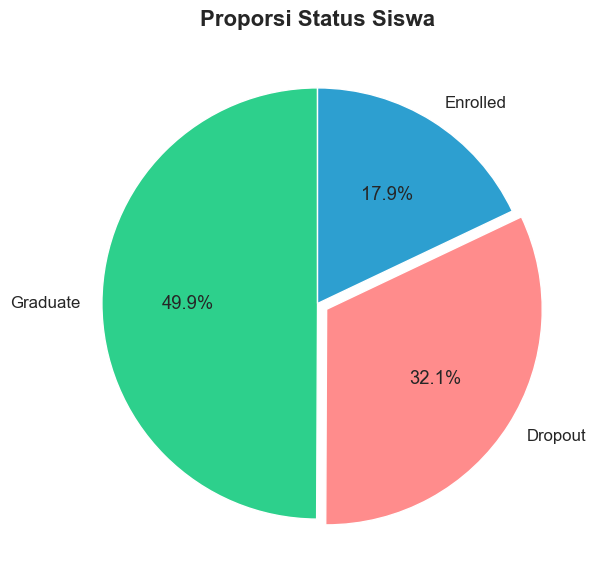

In [15]:
plt.figure(figsize=(10, 7))
status_counts = new_df['Status'].value_counts()
status_counts
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=["#2DD08C","#ff8c8c", "#2D9FD0"], explode=[0, 0.05, 0])
plt.title('Proporsi Status Siswa', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show()

##### Numerical Features

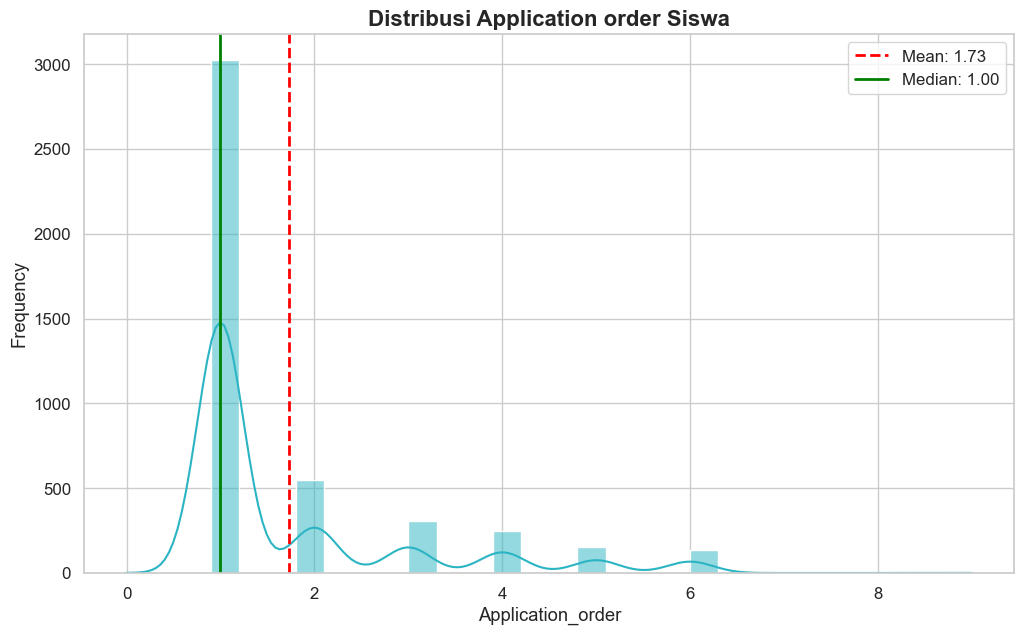

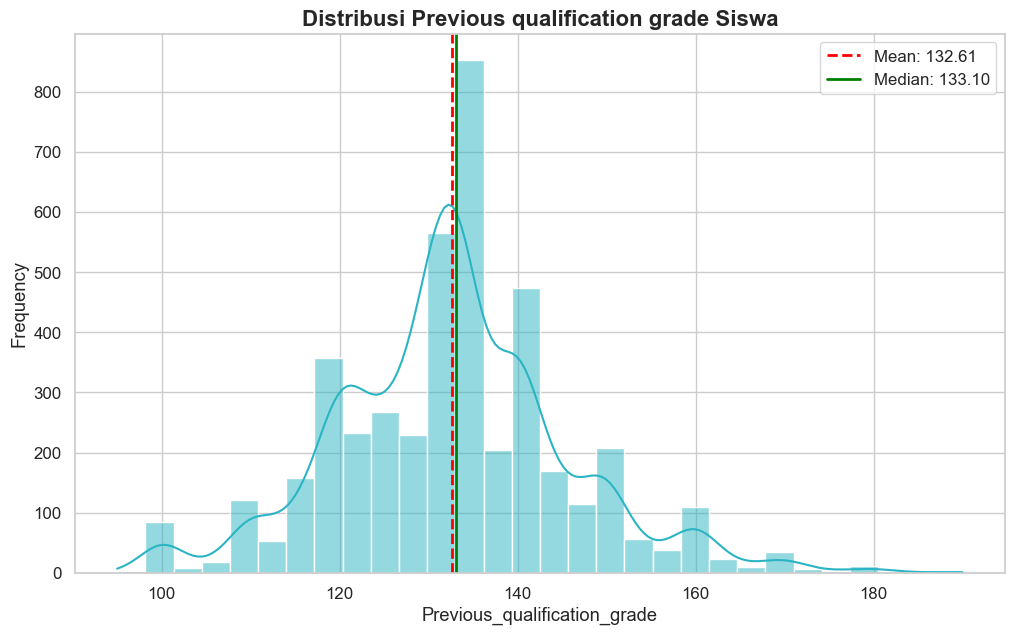

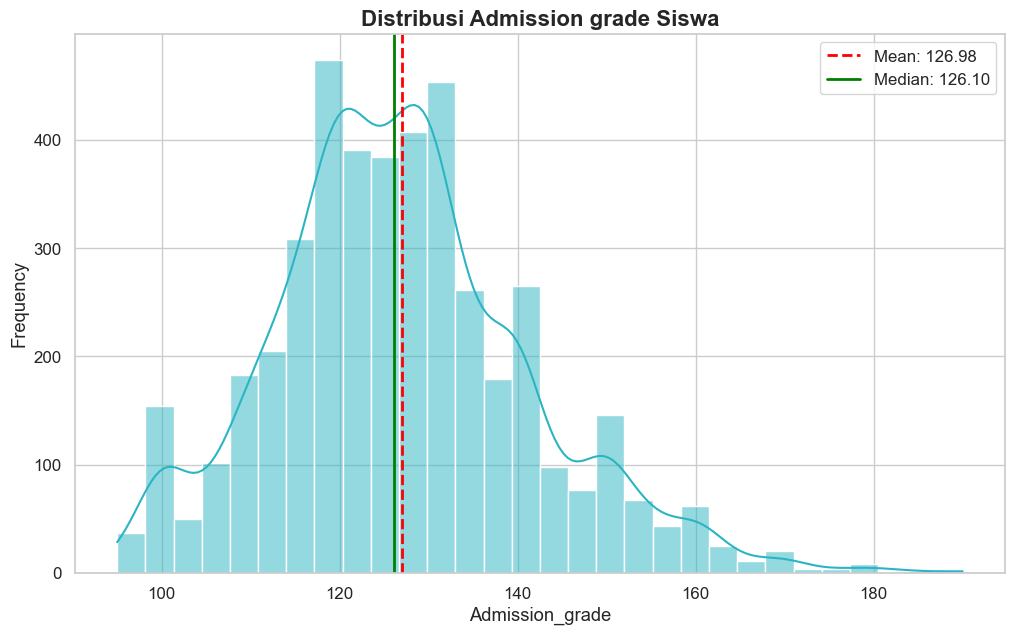

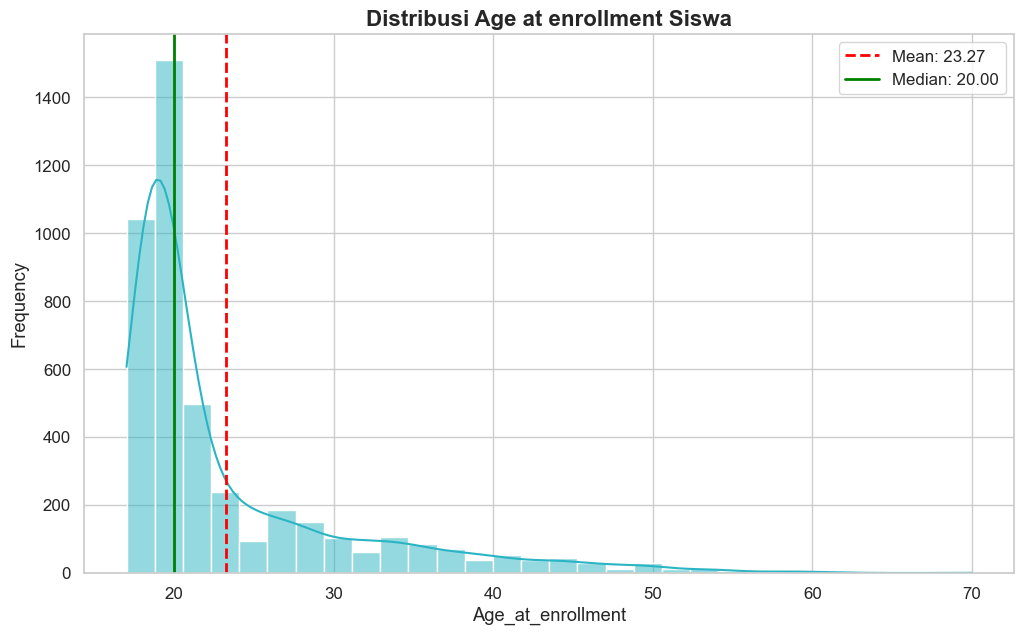

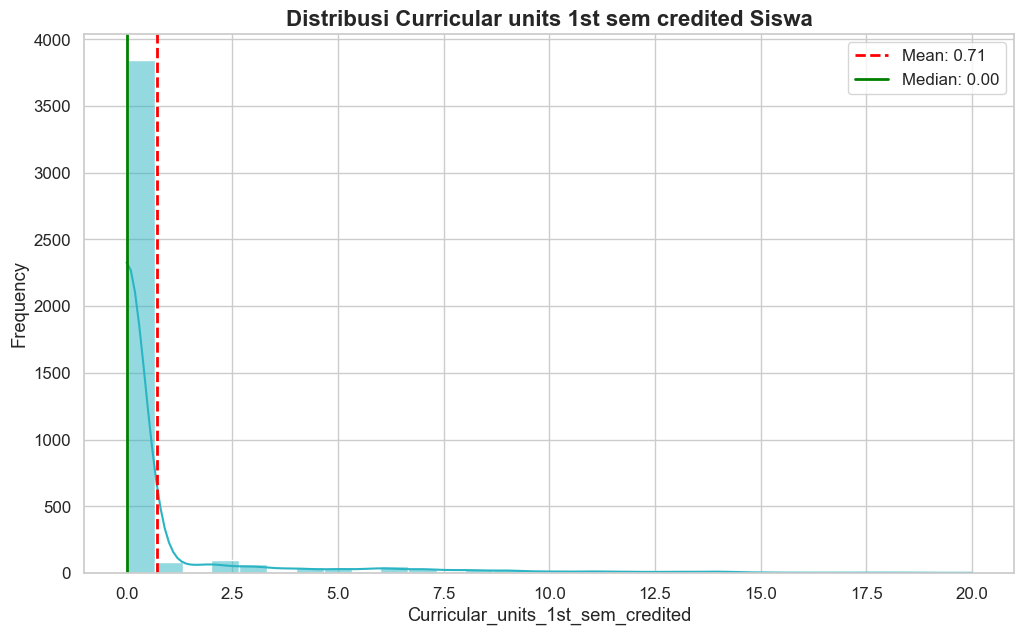

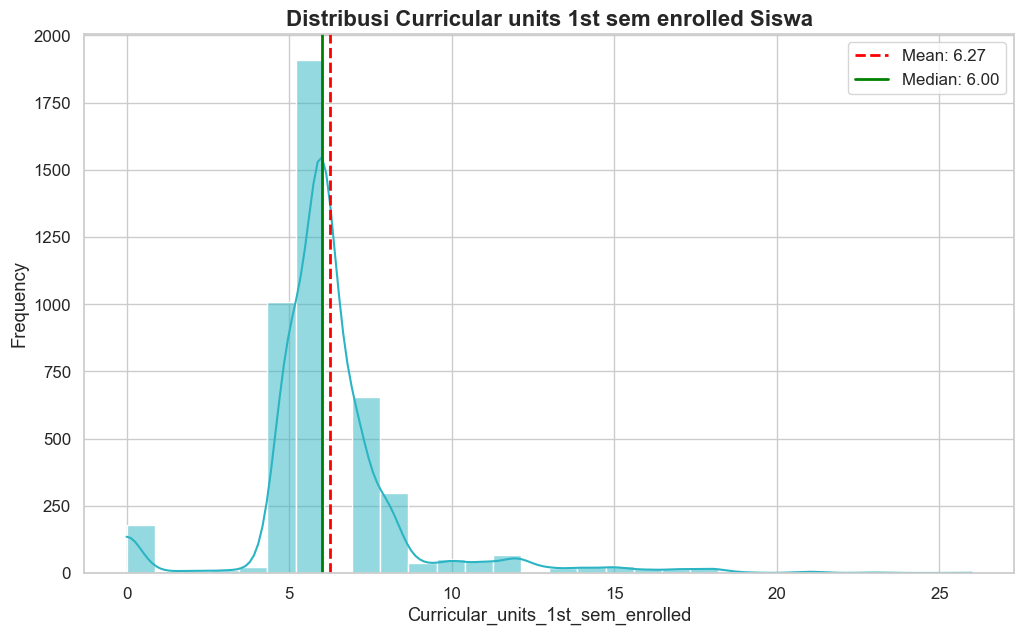

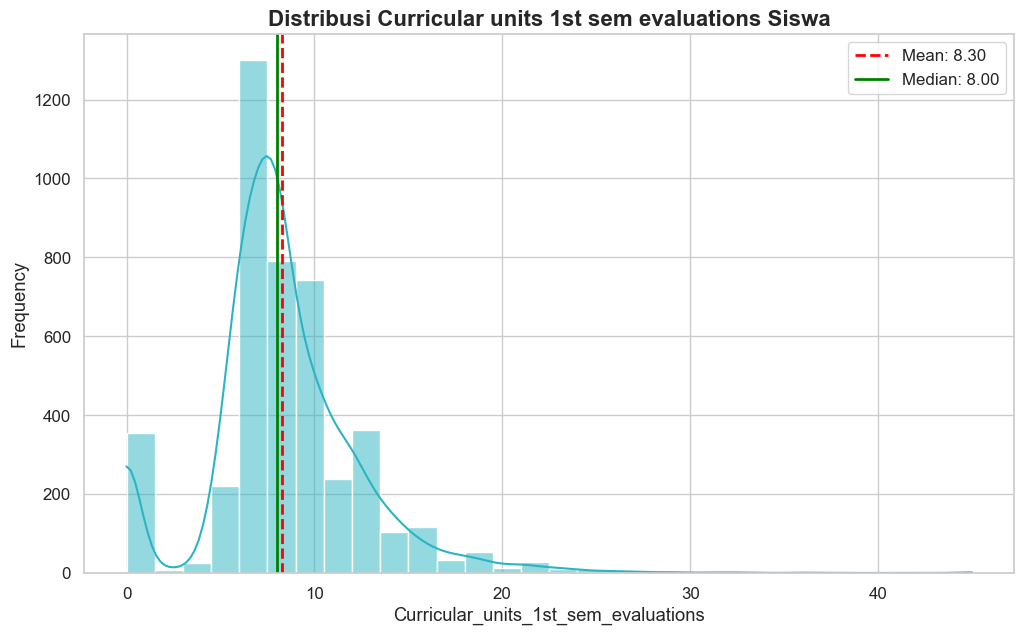

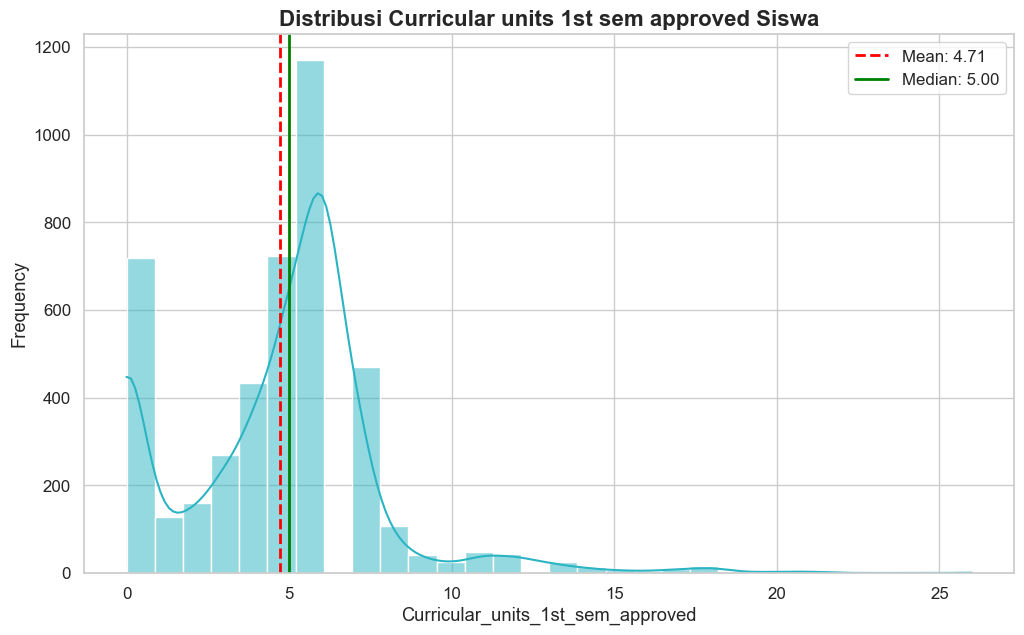

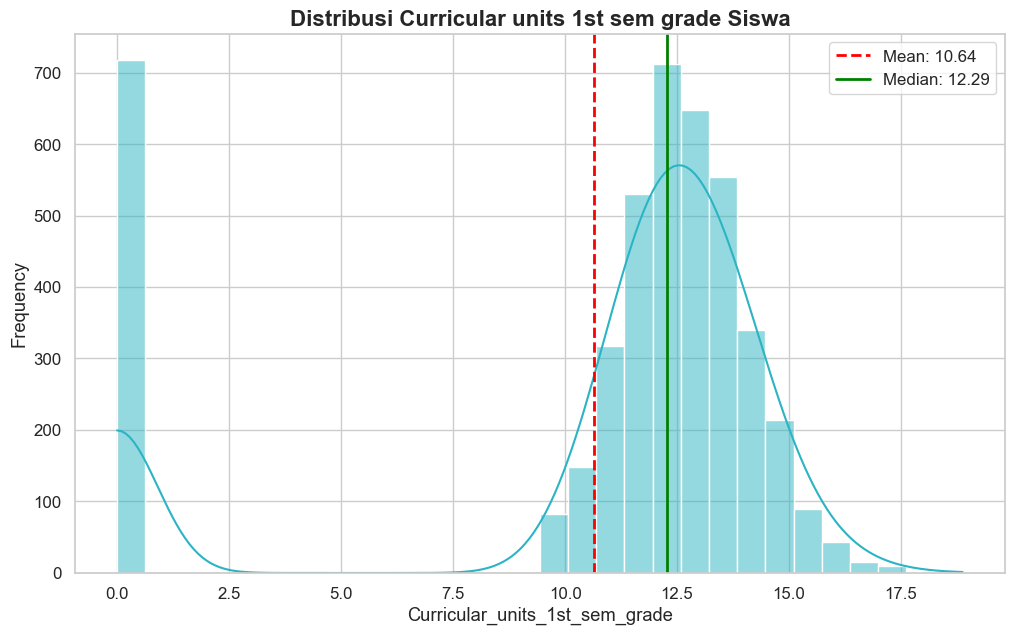

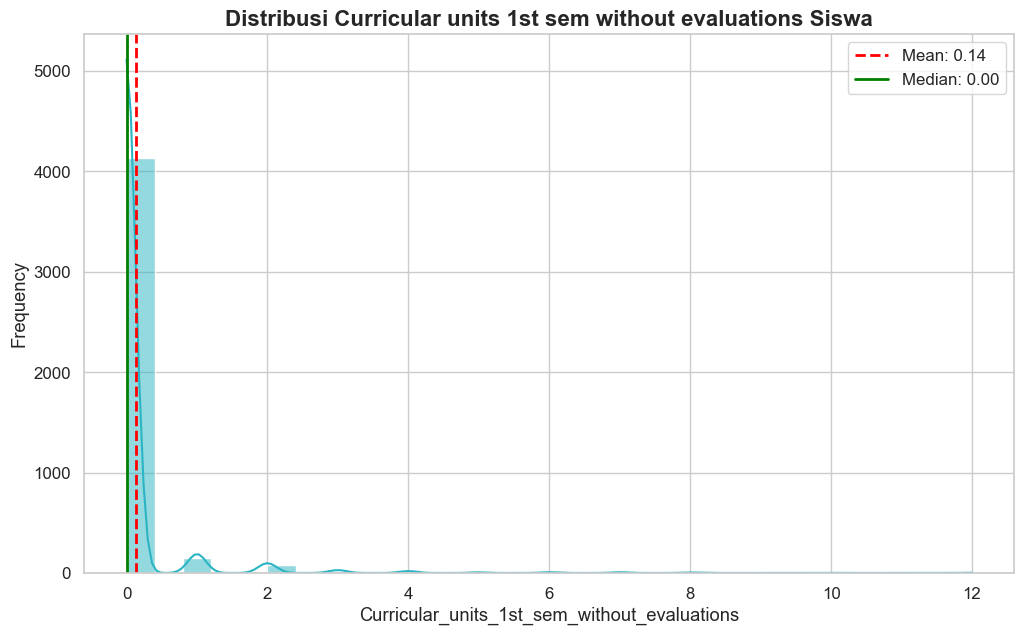

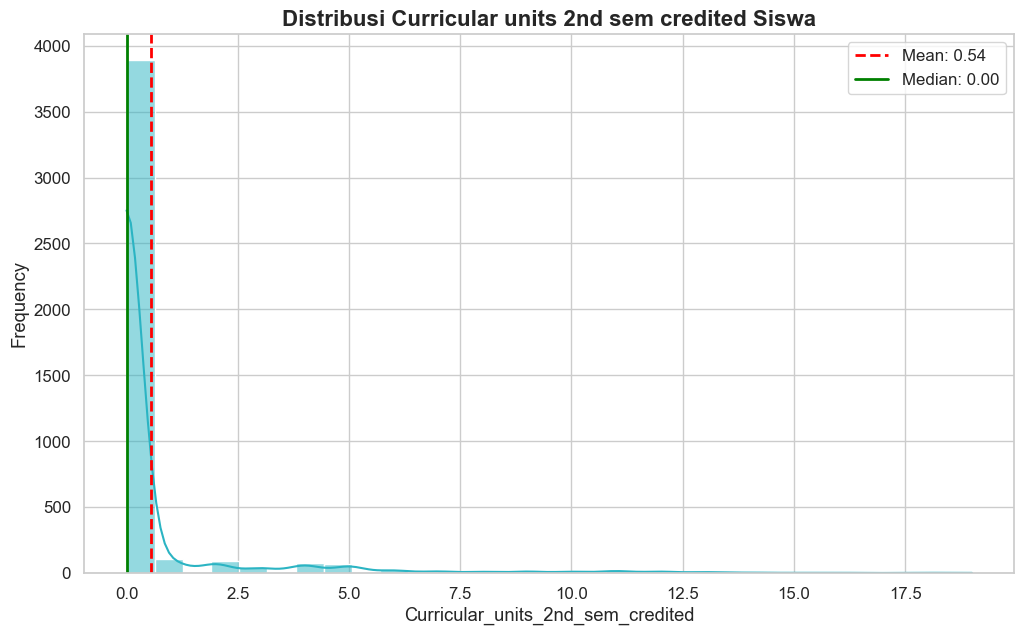

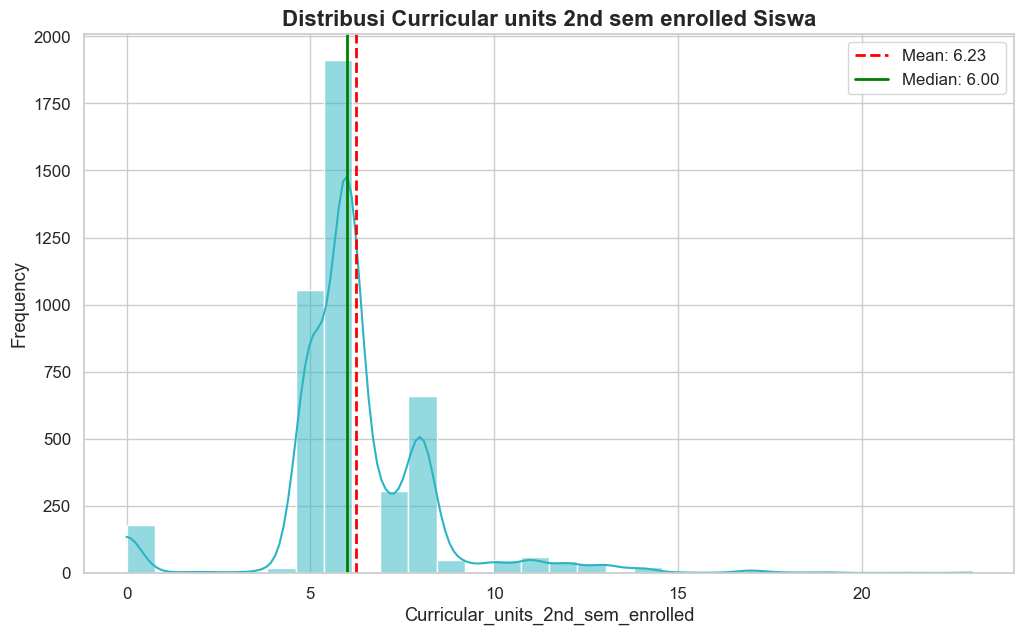

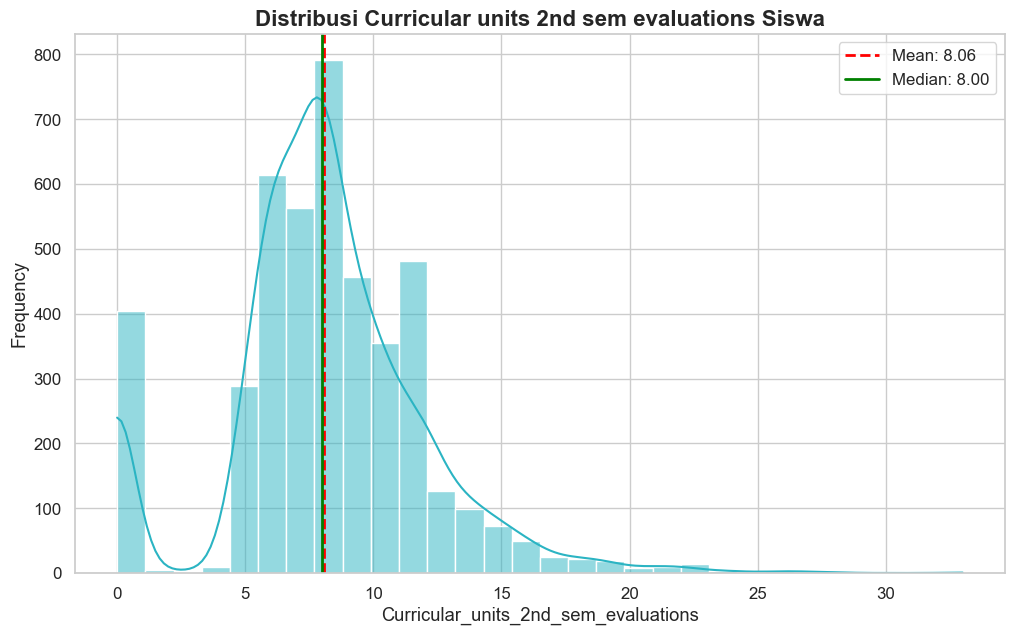

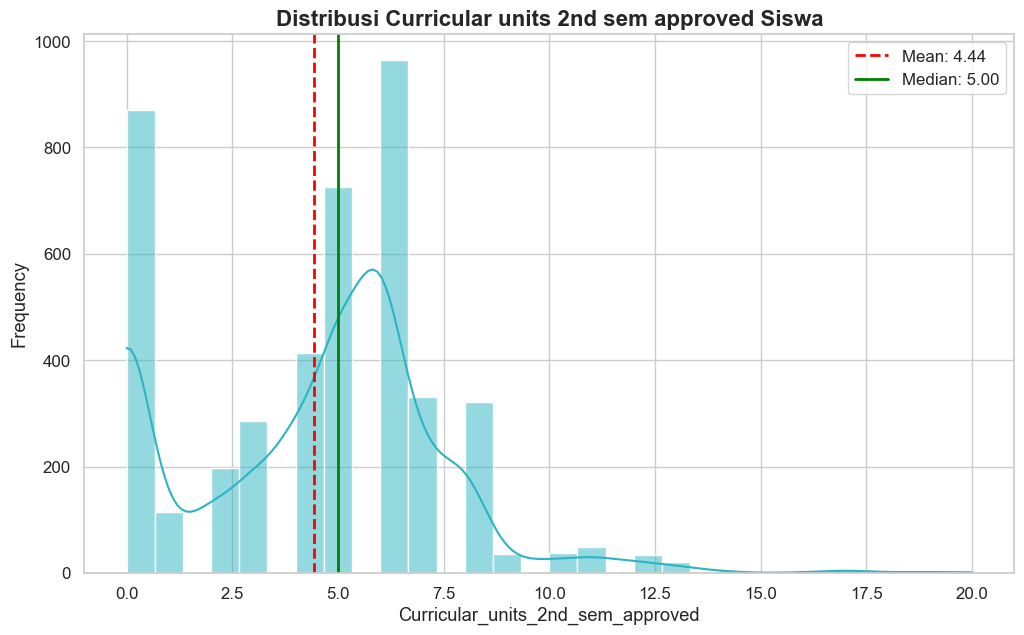

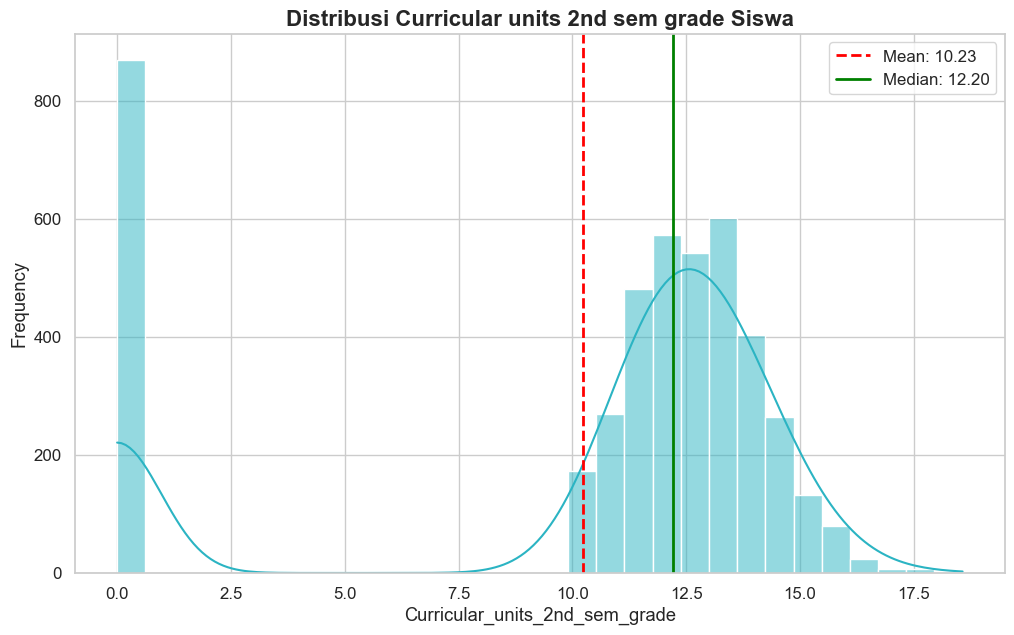

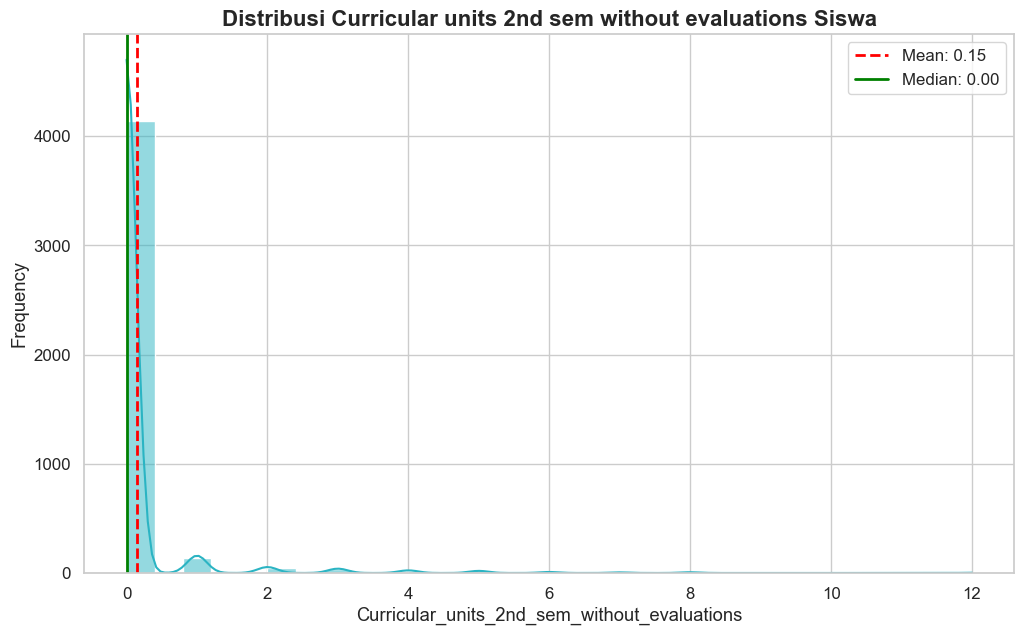

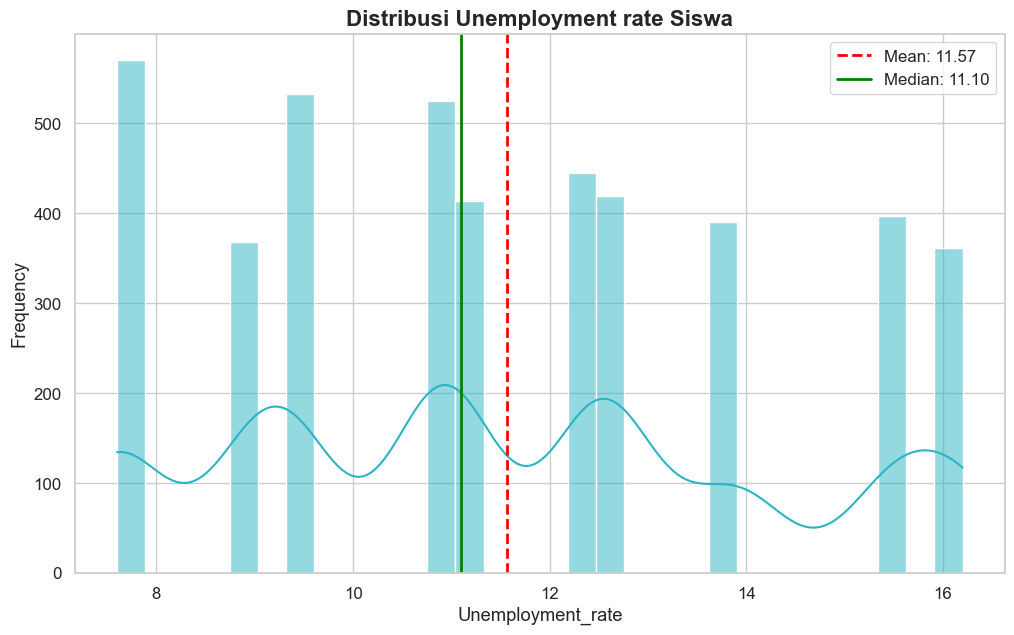

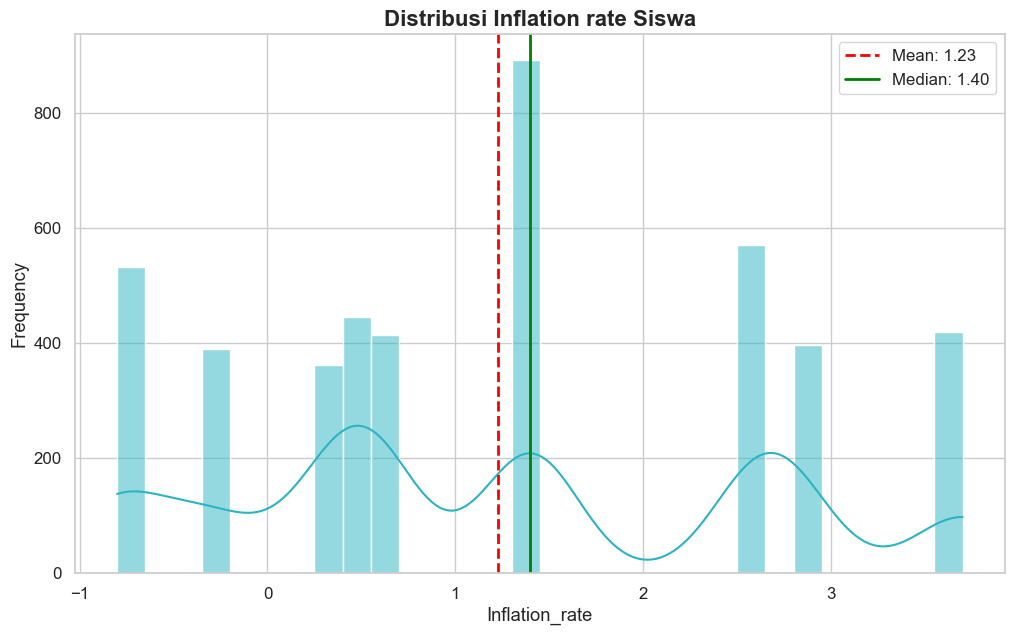

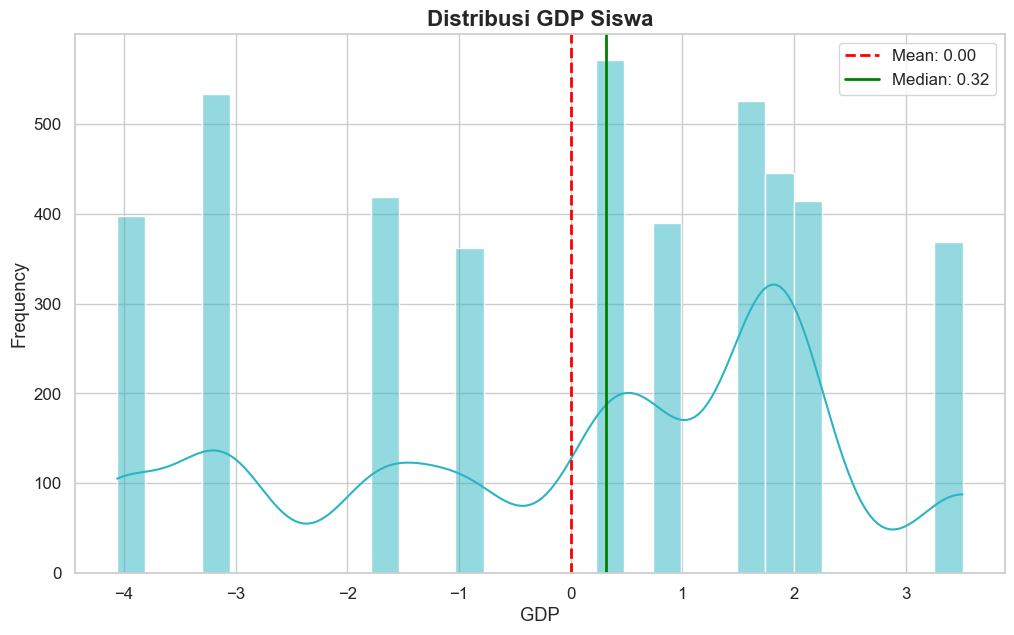

In [16]:
for col in numerical_cols:
    plt.figure(figsize=(12, 7))
    sns.histplot(new_df[col], kde=True, bins=30, color='#2BB4C3')

    mean_val = new_df[col].mean()
    median_val = new_df[col].median()

    if col in ['MonthlyIncome', 'DailyRate', 'HourlyRate', 'MonthlyRate']:
        plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_val:,.2f}')
        plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: ${median_val:,.2f}')
        plt.xlabel(f'{col} ($)')
    else:
        plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
        plt.xlabel(f'{col}')

    plt.title(f'Distribusi {col.replace("_", " ")} Siswa', fontsize=16, fontweight='bold')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

##### Categorical Features

In [17]:
print("--- Analisis Ketimpangan Kategori ---")

for col in categorical_cols:
    proportions = new_df[col].value_counts(normalize=True)

    max_proportion = proportions.max()
    dominating_category = proportions.idxmax()

    # threshold
    dominance_threshold = 0.70
    rare_category_threshold = 0.05

    is_imbalanced = False 

    # dominasi kategori
    if max_proportion >= dominance_threshold:
        print(f"\nKolom: {col}\n")
        print(f"ketimpangan MAYOR: '{dominating_category}' (> {dominance_threshold:.0%}).")
        is_imbalanced = True

    # kategori yang jarang
    rare_categories = proportions[proportions < rare_category_threshold]
    if not rare_categories.empty:
        if not is_imbalanced: 
            print(f"\nKolom: {col}")
        
        rare_category_names = ", ".join(rare_categories.index.tolist())
        print(f"ketimpangan MINOR: '{rare_category_names}' (< {rare_category_threshold:.0%}).")
        is_imbalanced = True

    if is_imbalanced:
        print("\nDistribusi Persentase Setiap Kategori:")
        print(proportions.apply(lambda x: f"{x:.2%}"))
        print("-" * 50)

--- Analisis Ketimpangan Kategori ---

Kolom: Marital_status

ketimpangan MAYOR: 'single' (> 70%).
ketimpangan MINOR: 'divorced, facto union, legally separated, widower' (< 5%).

Distribusi Persentase Setiap Kategori:
Marital_status
single               88.58%
married               8.57%
divorced              2.06%
facto union           0.57%
legally separated     0.14%
widower               0.09%
Name: proportion, dtype: object
--------------------------------------------------

Kolom: Application_mode
ketimpangan MINOR: 'Technological specialization diploma holders, Holders of other higher courses, 3rd phase - general contingent, Transfer, Change of institution/course, 1st phase - special contingent (Madeira Island), Short cycle diploma holders, International student (bachelor), 1st phase - special contingent (Azores Island), Ordinance No. 854-B/99, Ordinance No. 612/93, Change of institution/course (International), Ordinance No. 533-A/99, item b2) (Different Plan), Ordinance No. 533

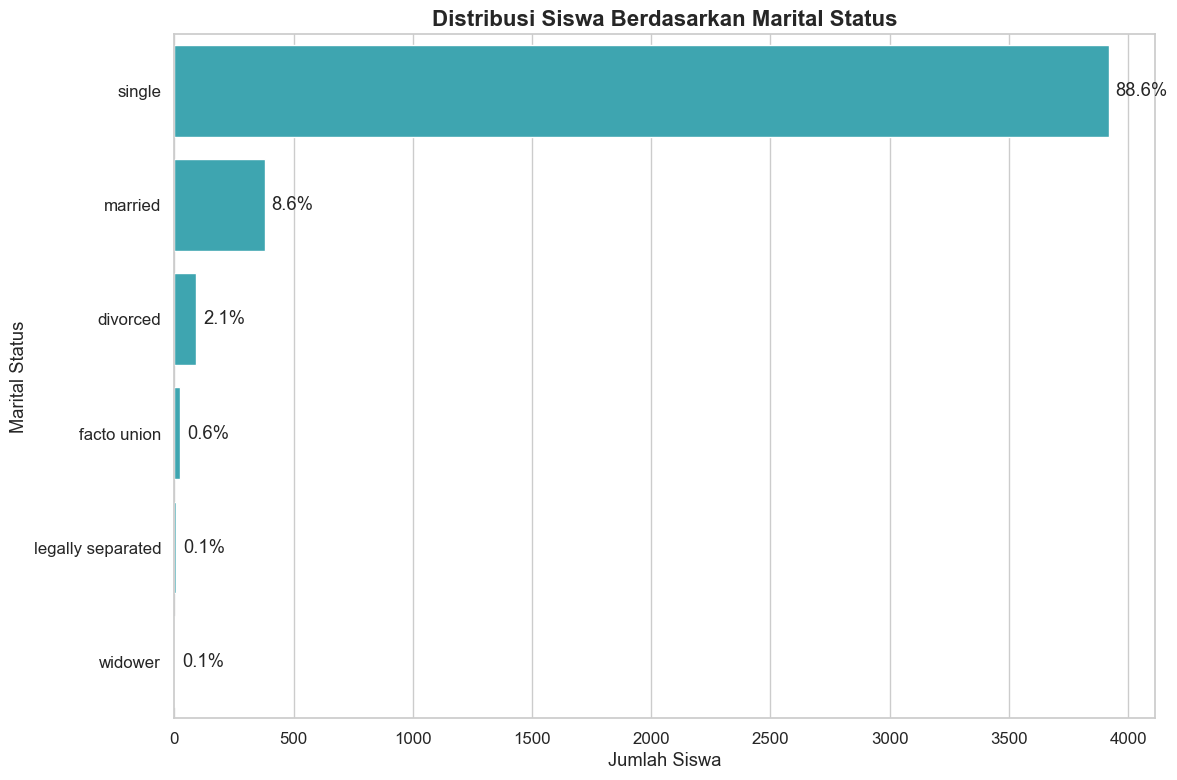

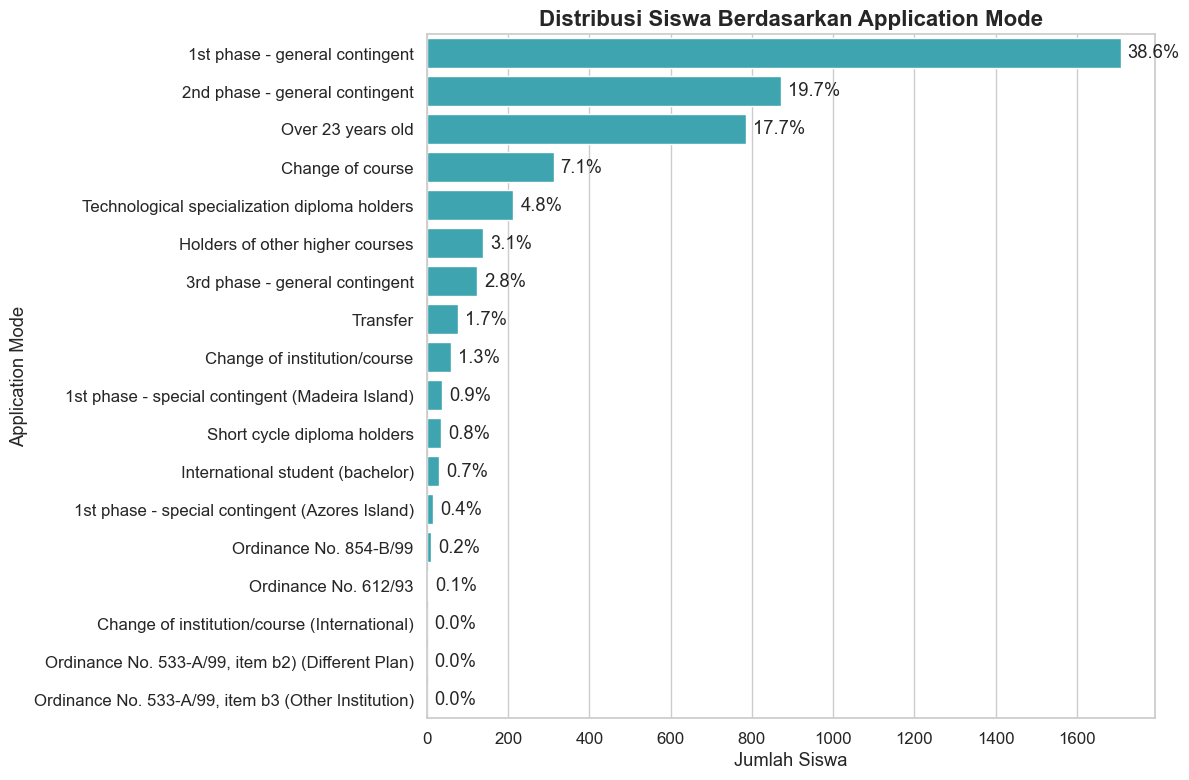

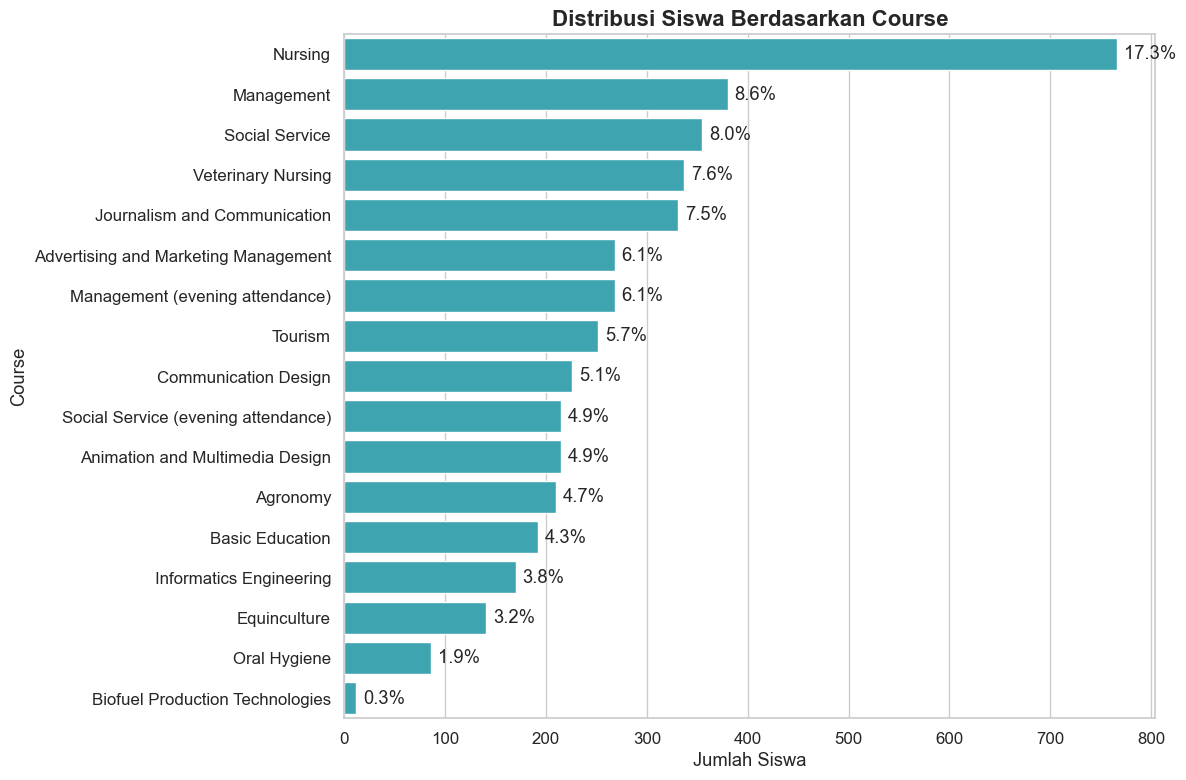

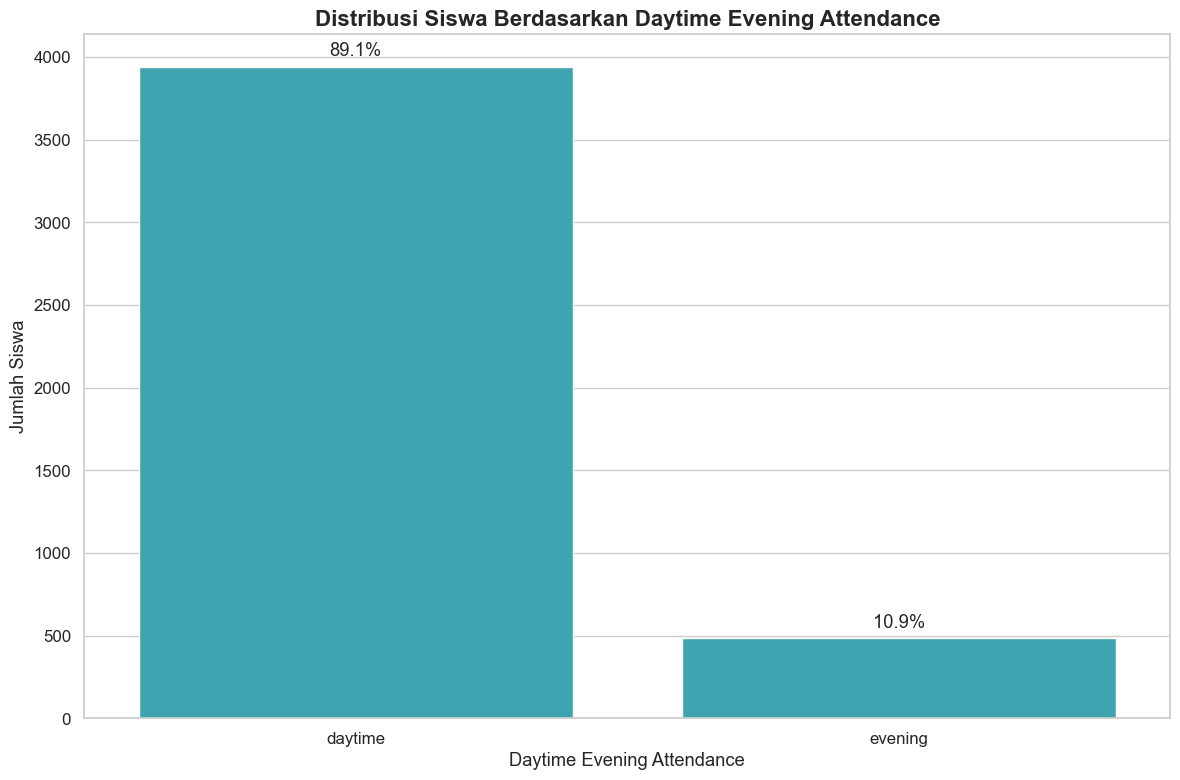

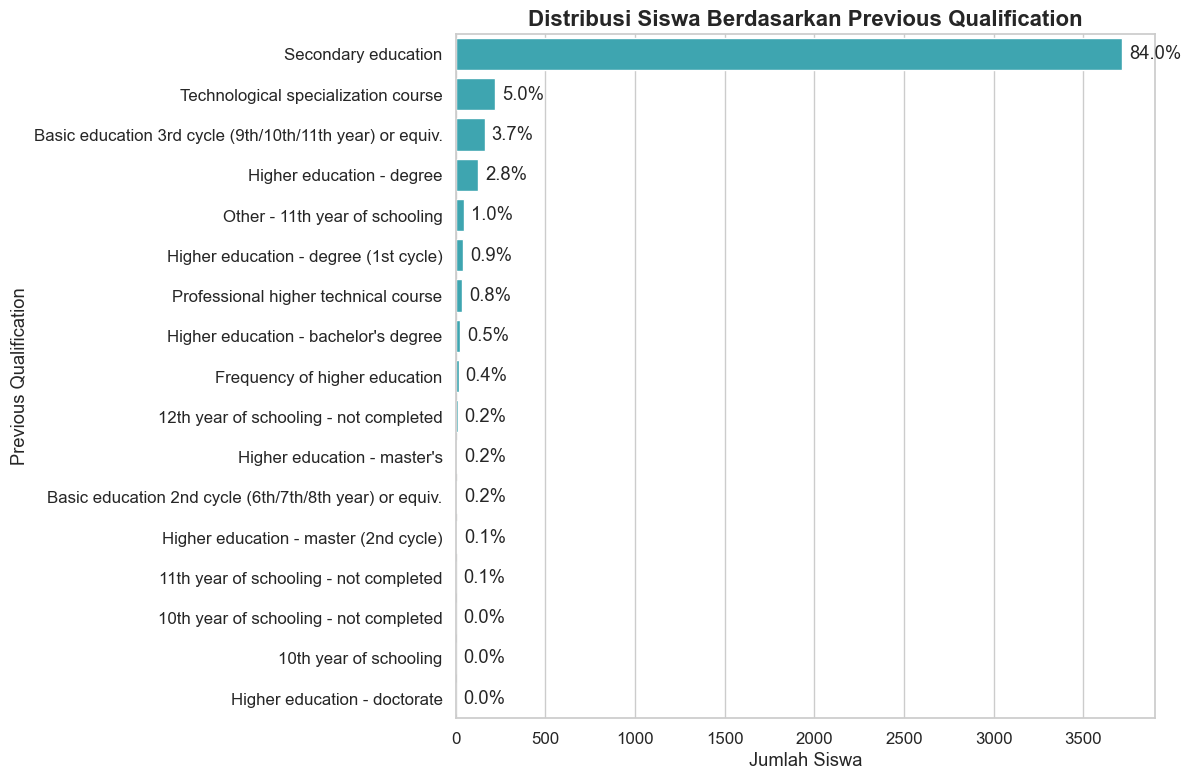

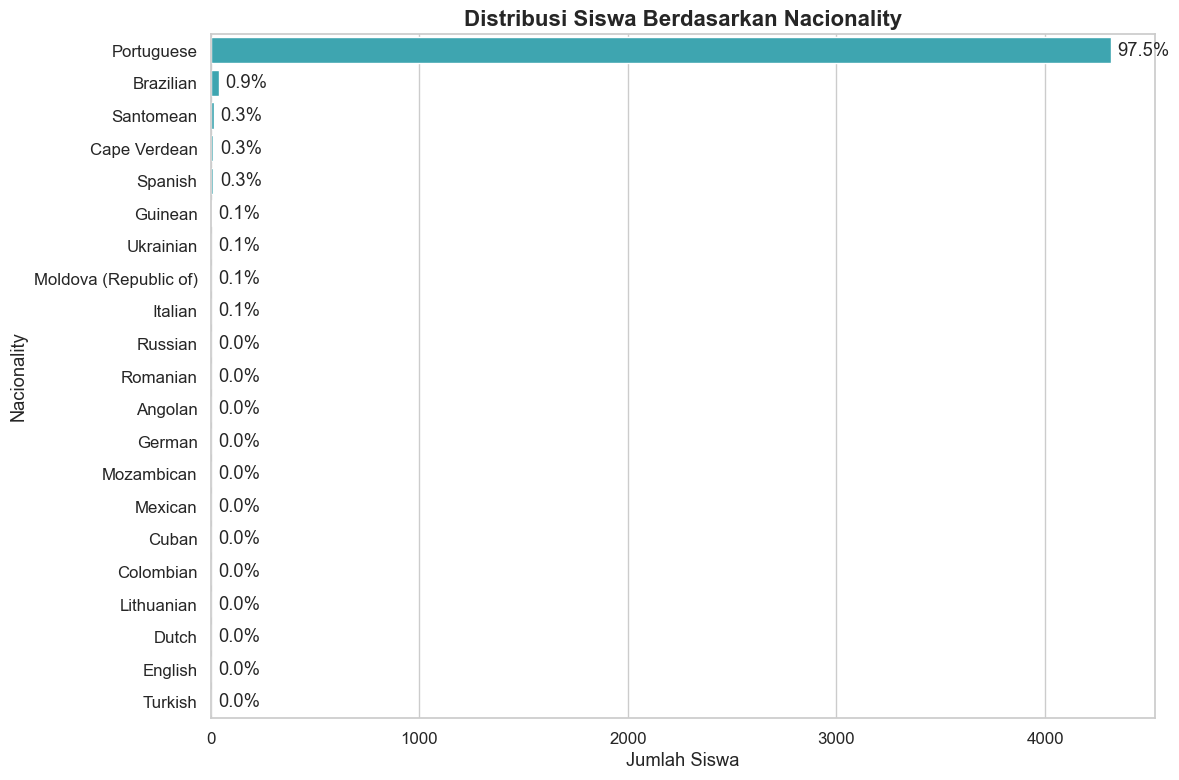

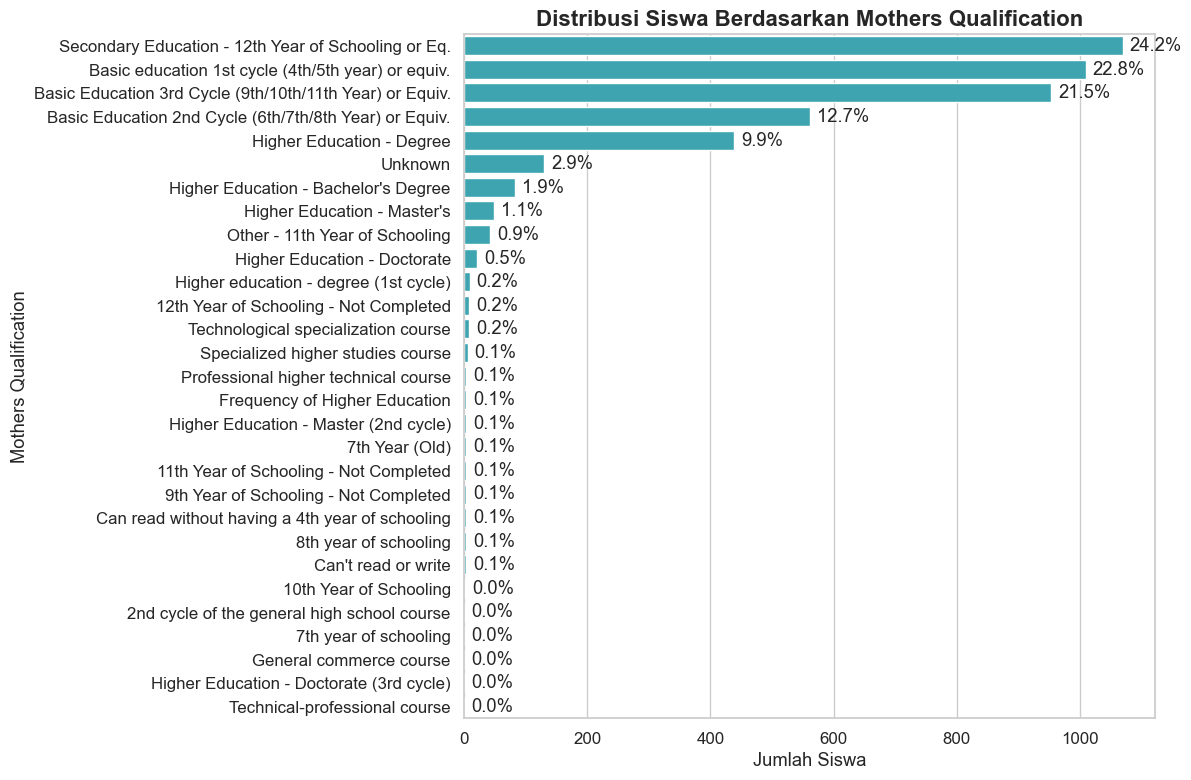

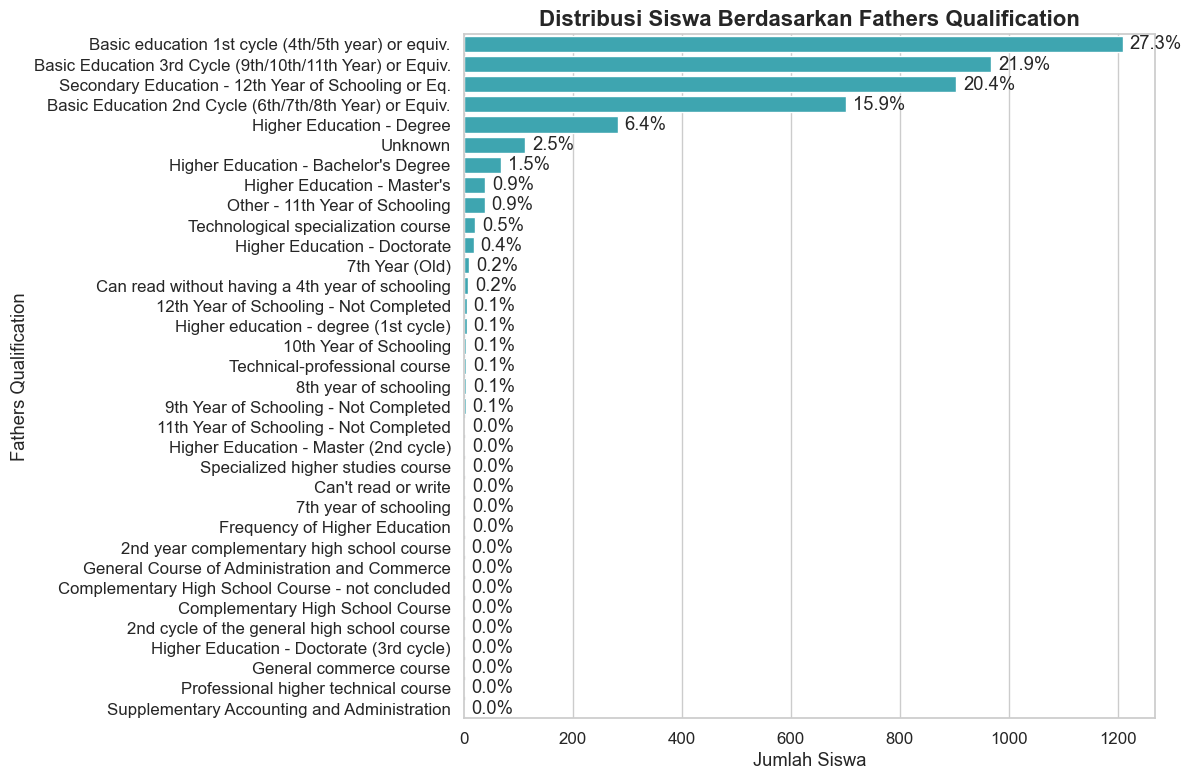

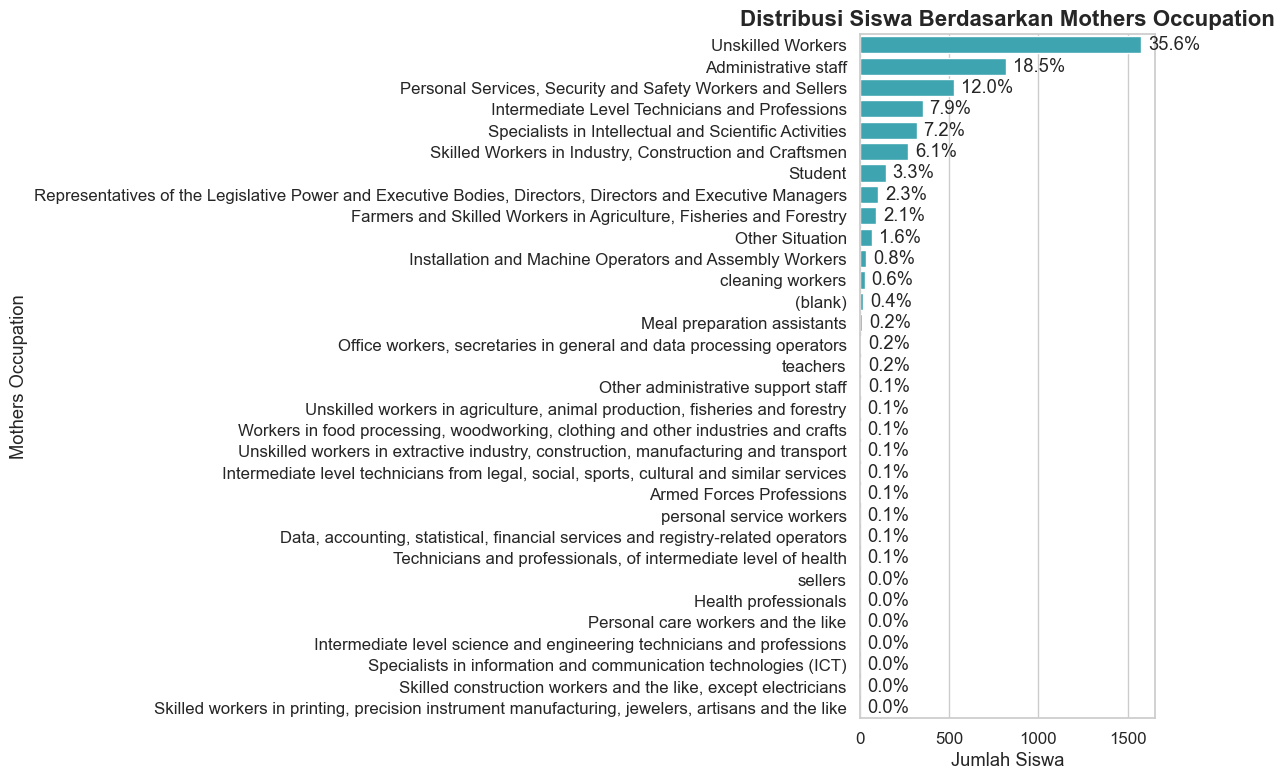

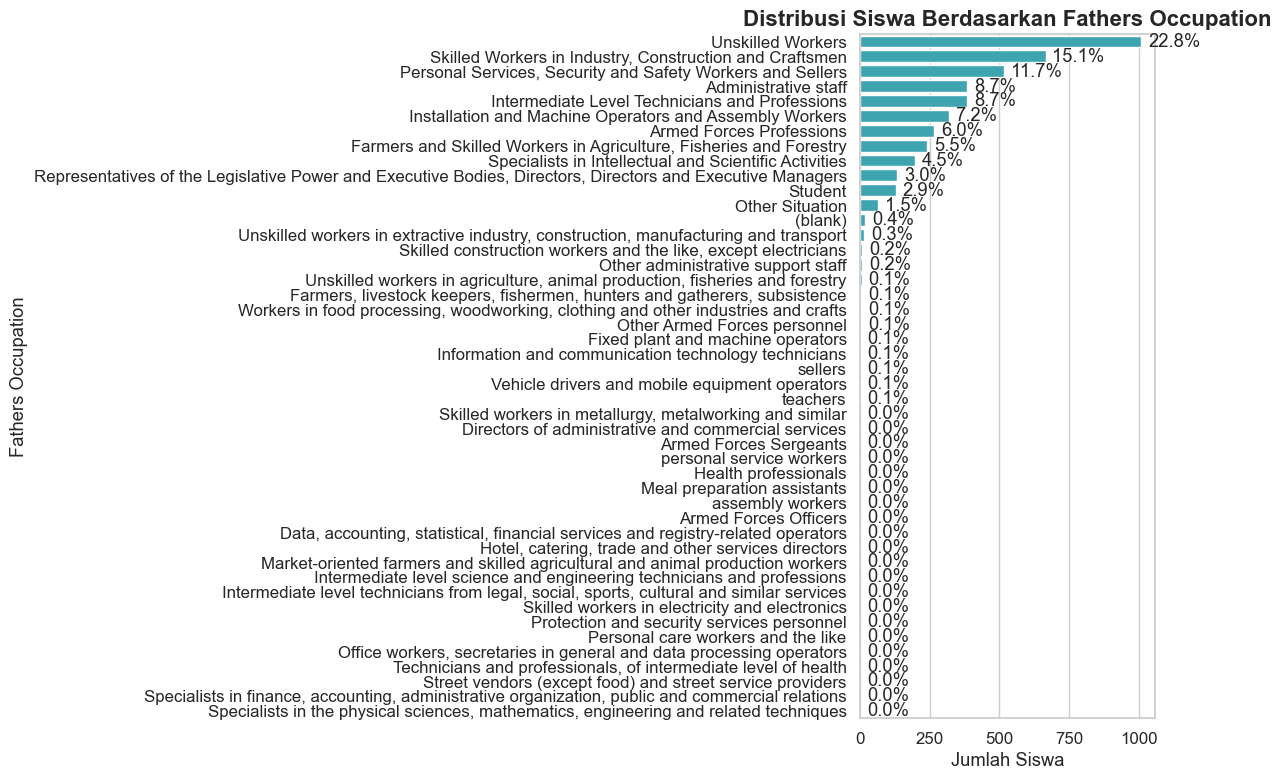

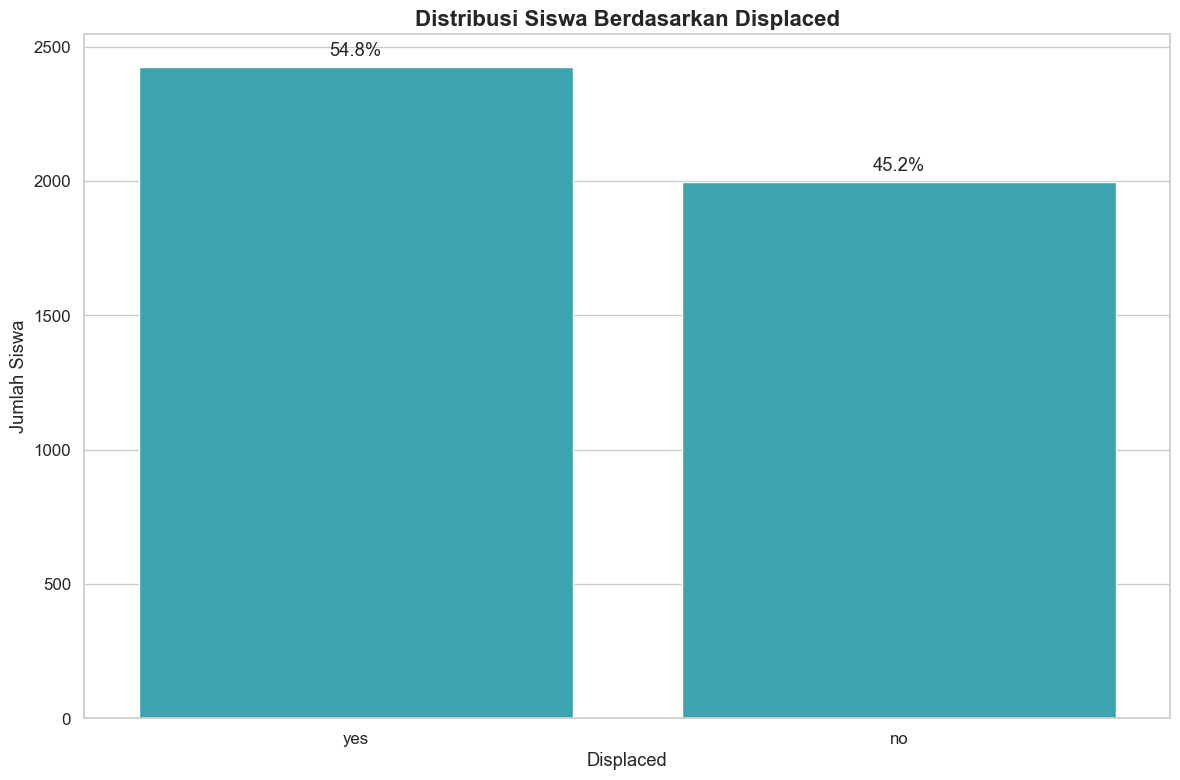

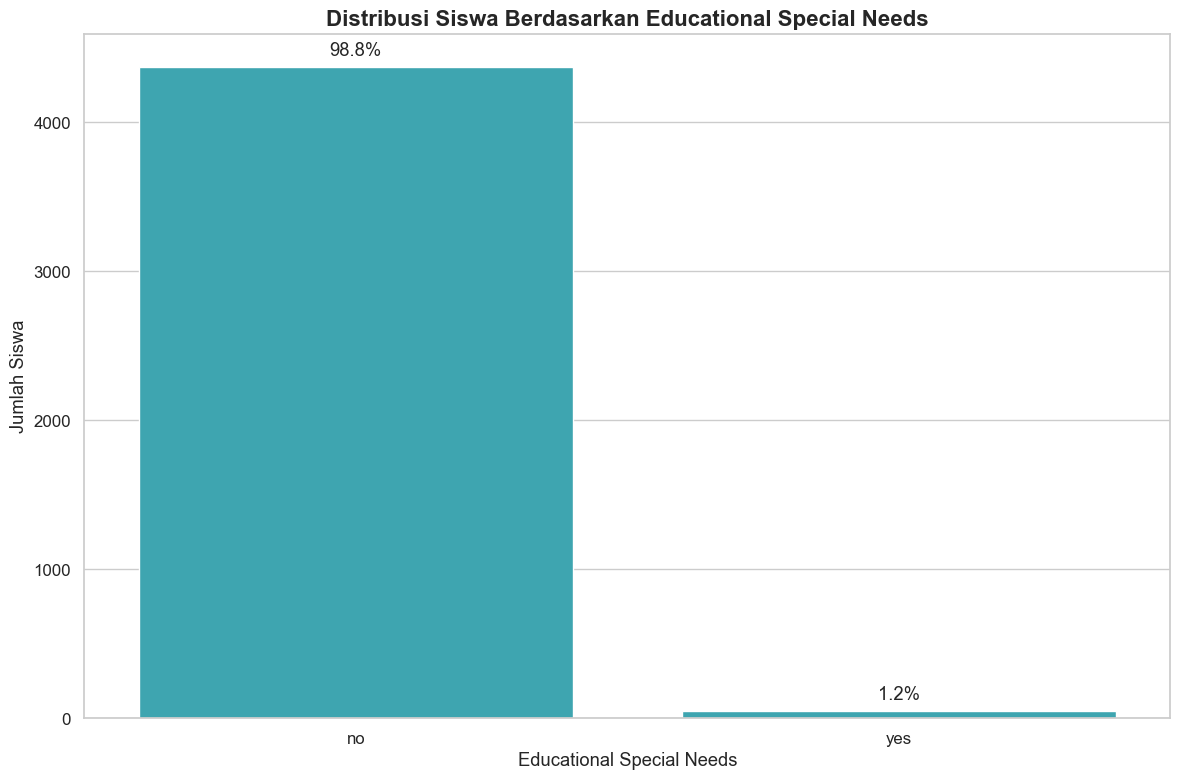

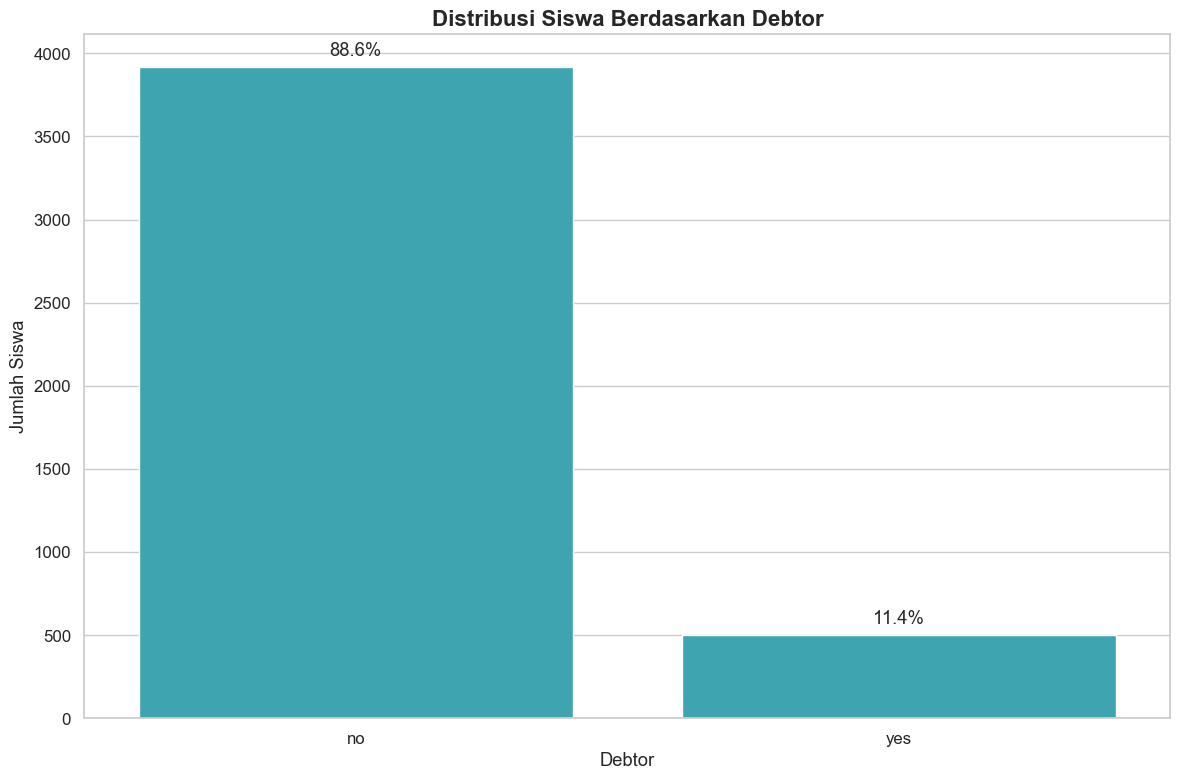

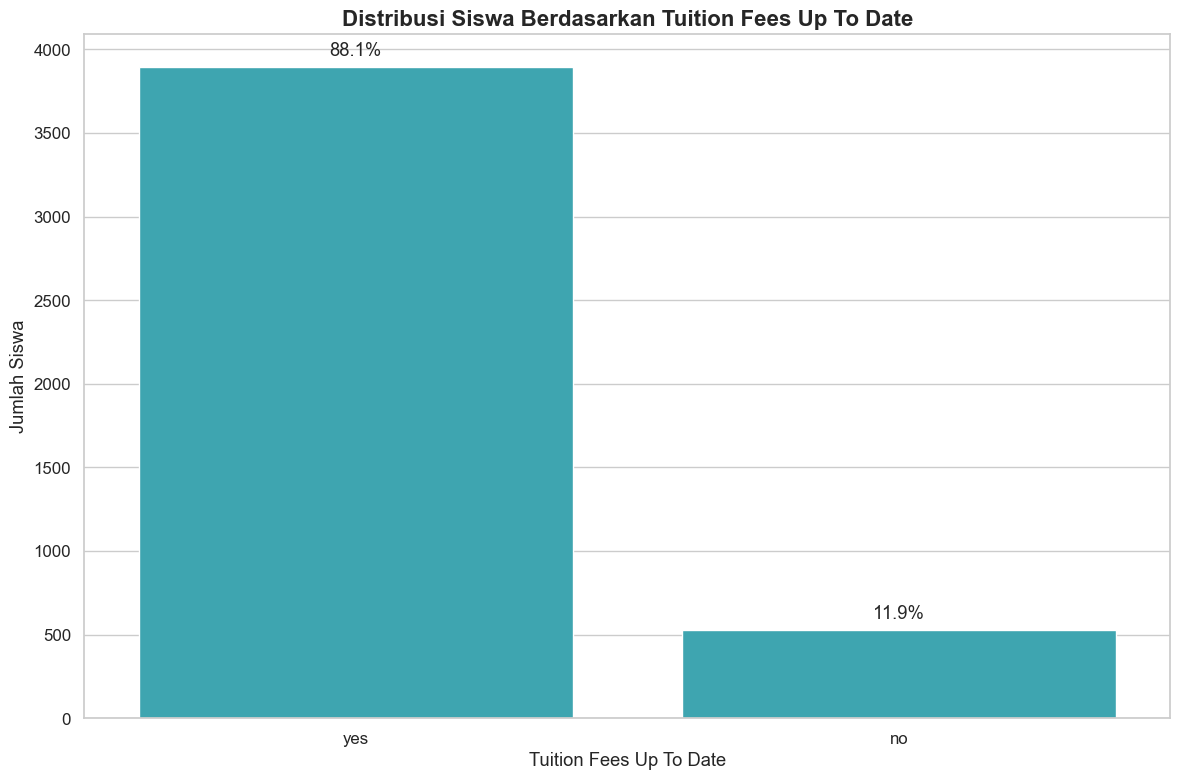

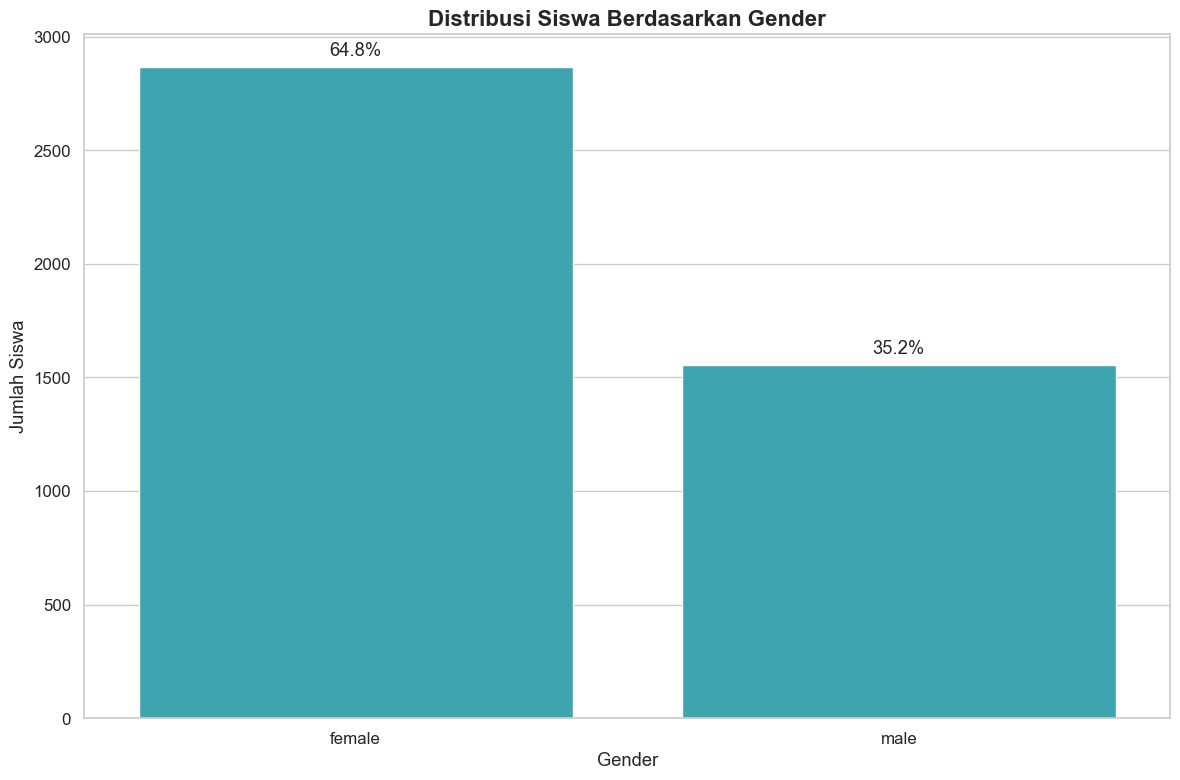

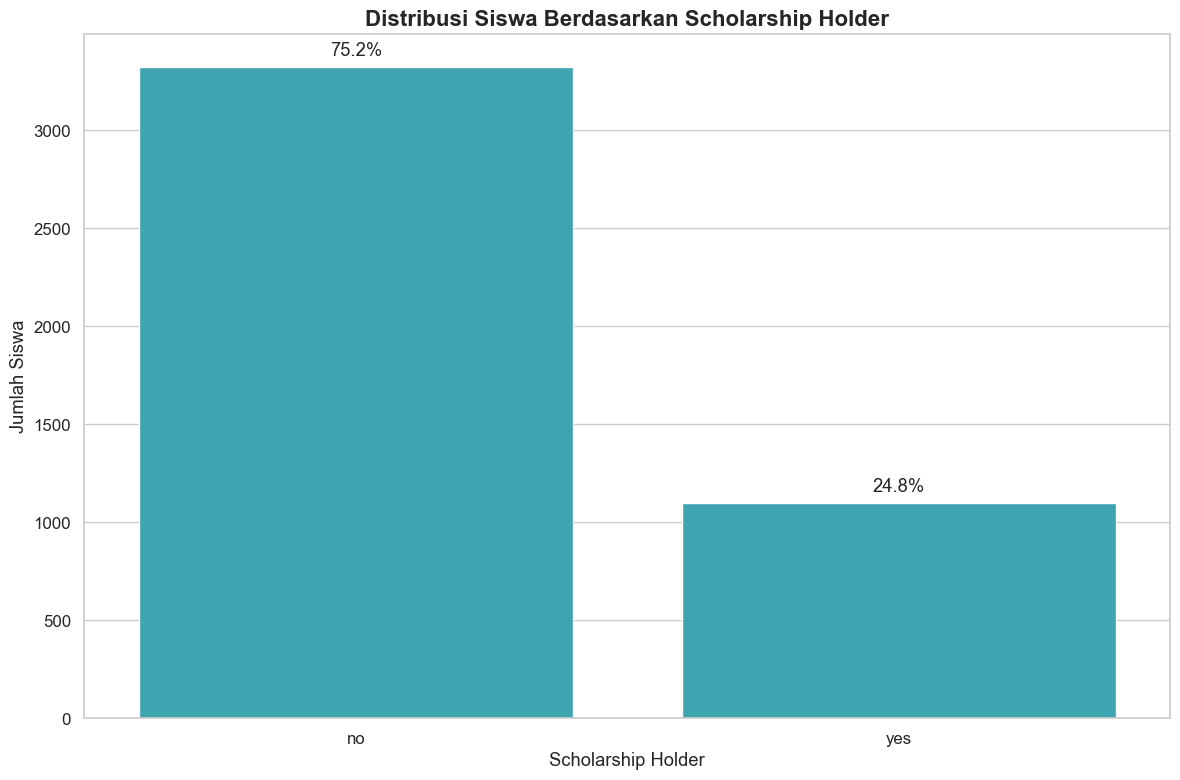

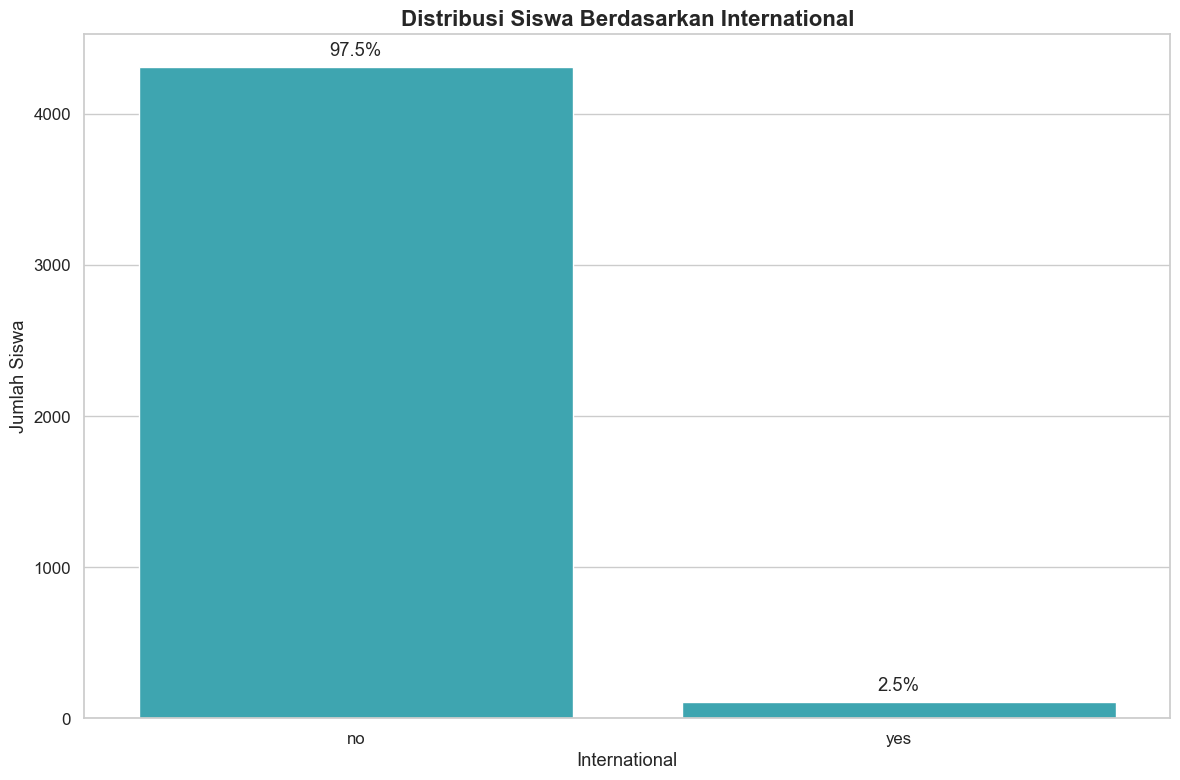

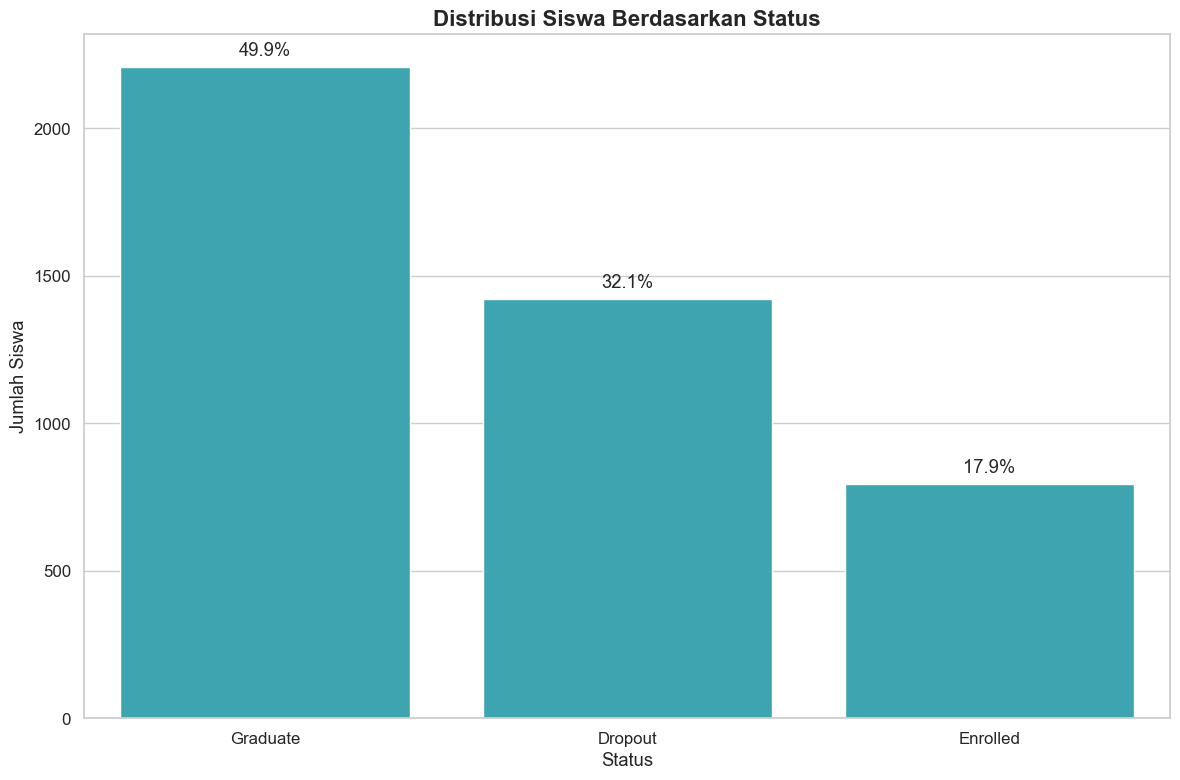

In [18]:
for col in categorical_cols:
    plt.figure(figsize=(12, 8))
    
    value_counts = new_df[col].value_counts()
    num_categories = len(value_counts)
    
    total = len(new_df) 

    if num_categories > 5:
        # Horizontal bar chart
        ax = sns.countplot(y=col, data=new_df, order=value_counts.index, color="#2BB4C3")
        plt.xlabel('Jumlah Siswa')
        plt.ylabel(col.replace("_", " ").title())
    else:
        # Vertical bar chart
        ax = sns.countplot(x=col, data=new_df, order=value_counts.index, color="#2BB4C3")
        plt.xlabel(col.replace("_", " ").title()) 
        plt.ylabel('Jumlah Siswa')

    plt.title(f'Distribusi Siswa Berdasarkan {col.replace("_", " ").title()}', fontsize=16, fontweight='bold')

    # Add percentage annotations
    for p in ax.patches:
        if num_categories > 5: 
            percentage = f'{(p.get_width()/total)*100:.1f}%'
            x = p.get_width()
            y = p.get_y() + p.get_height() / 2
            ax.annotate(percentage, (x, y), ha='left', va='center', xytext=(5, 0), textcoords='offset points')
        else: 
            percentage = f'{(p.get_height()/total)*100:.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

#### Multivariate

##### Categorical vs Status

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


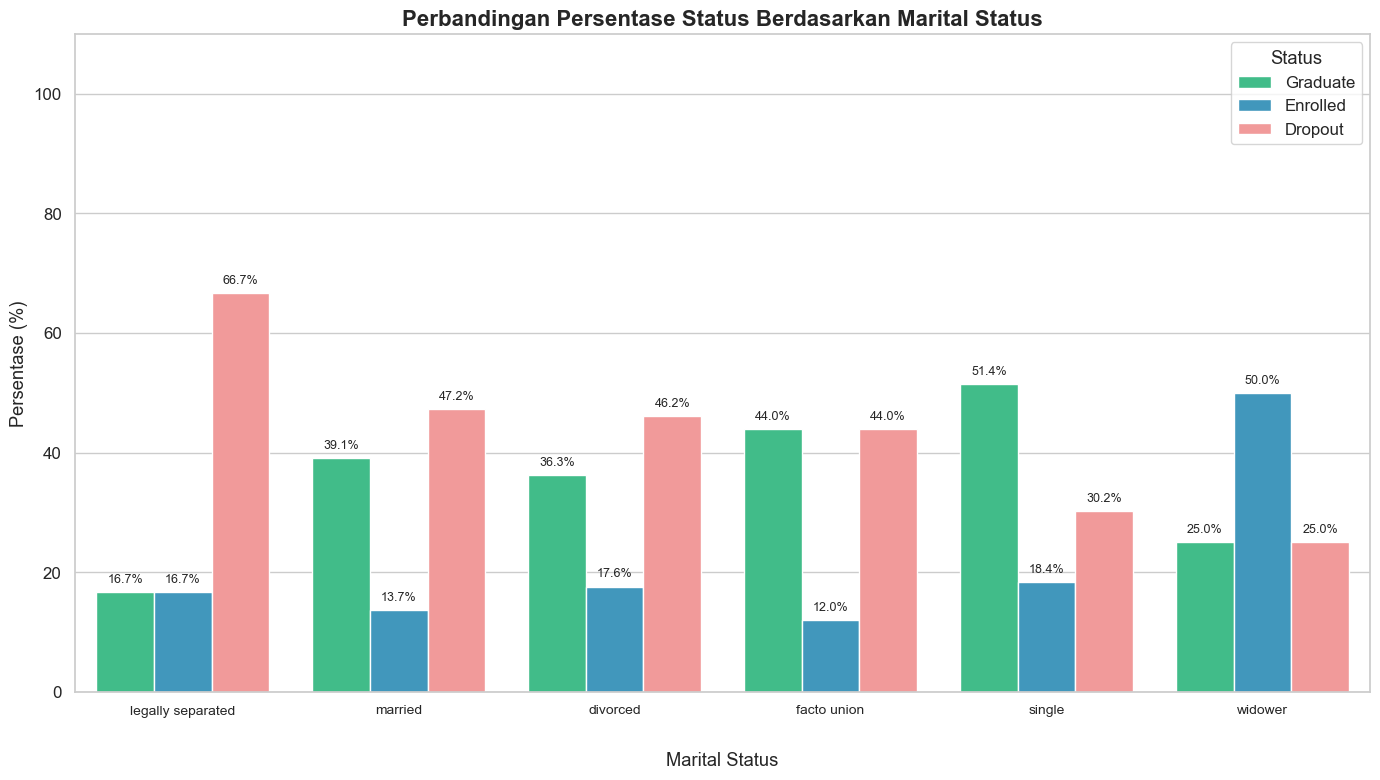

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=50, ha='right', fontsize=10)


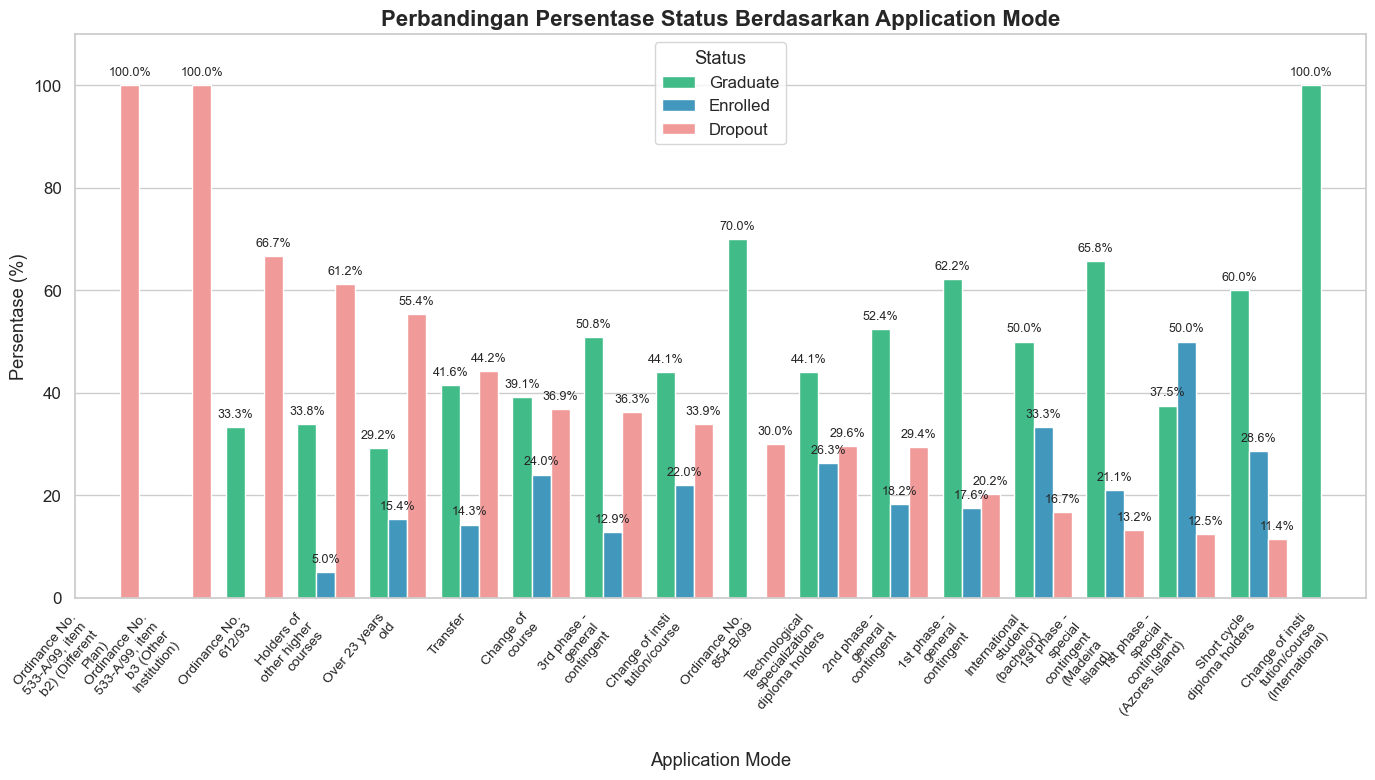

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=50, ha='right', fontsize=10)


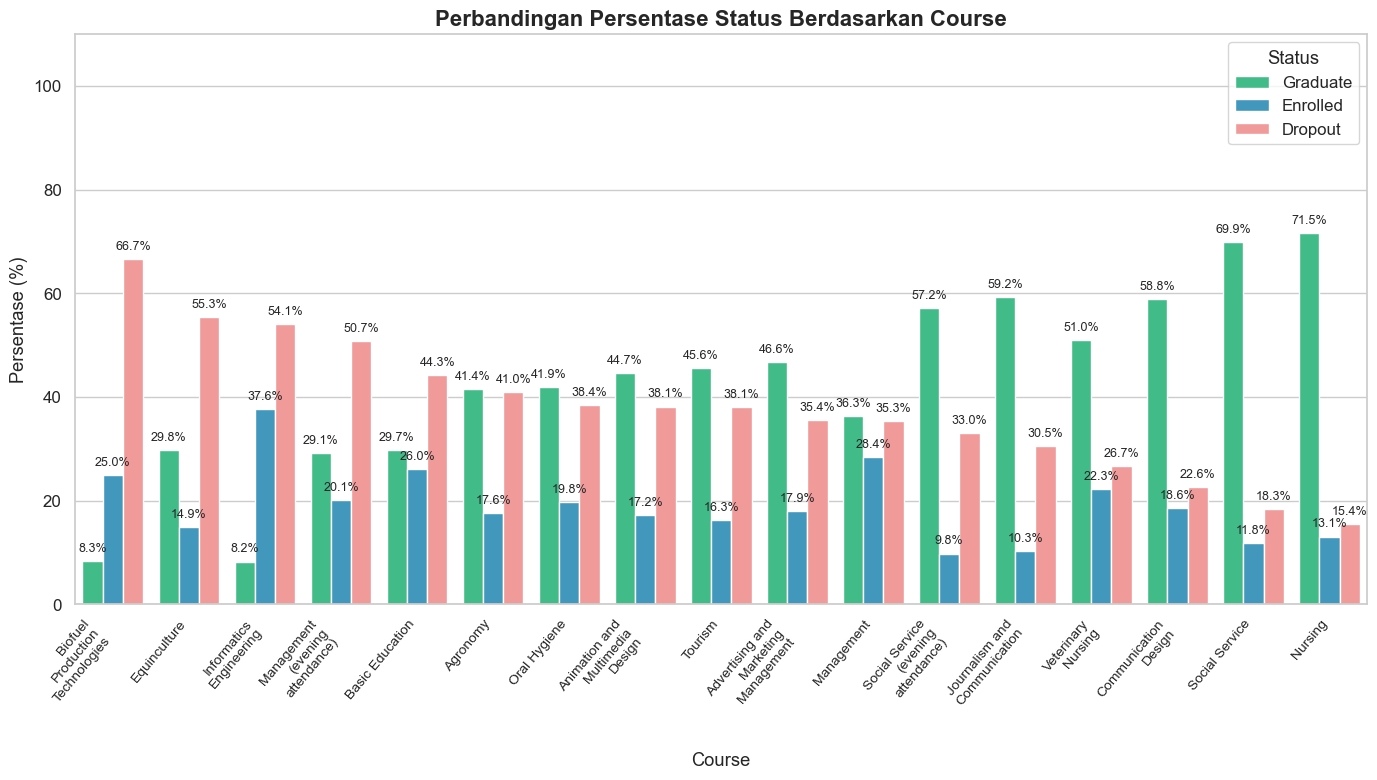

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


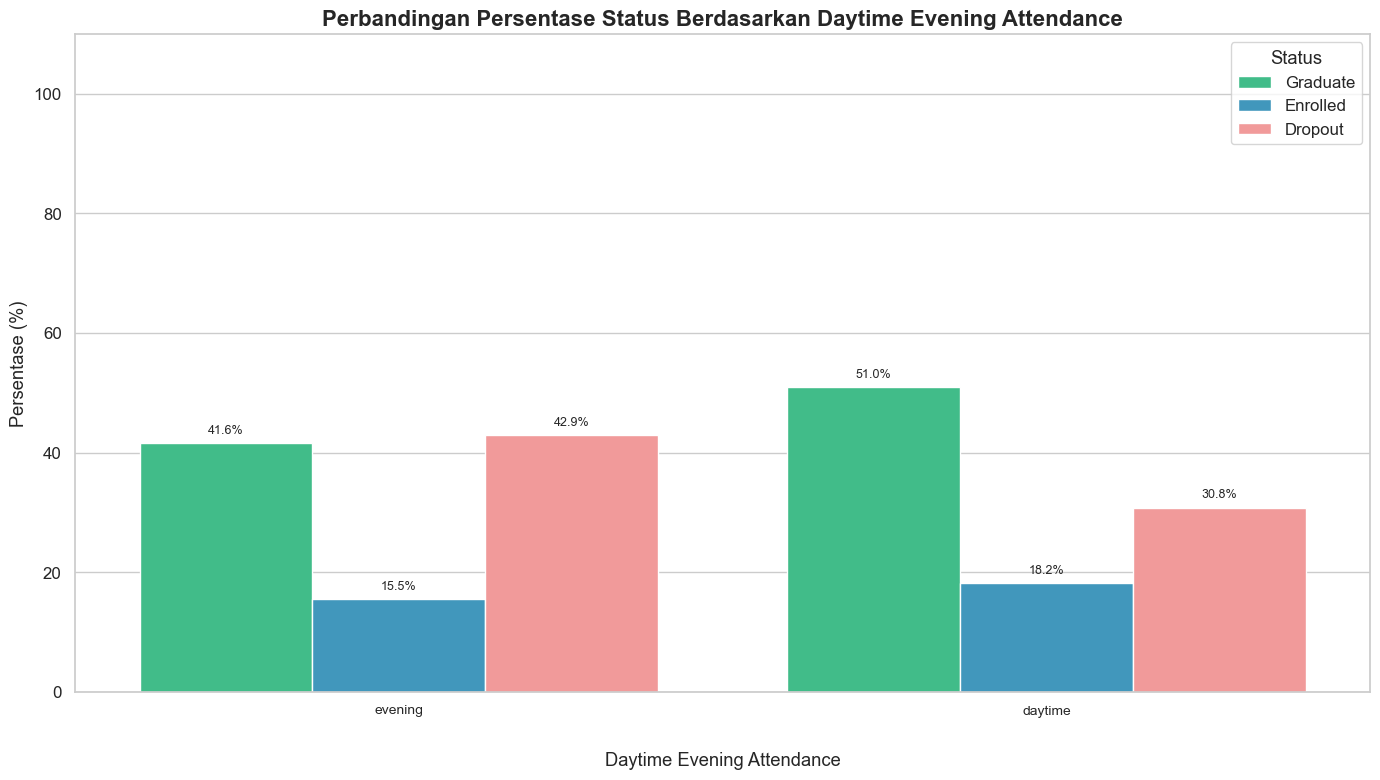

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


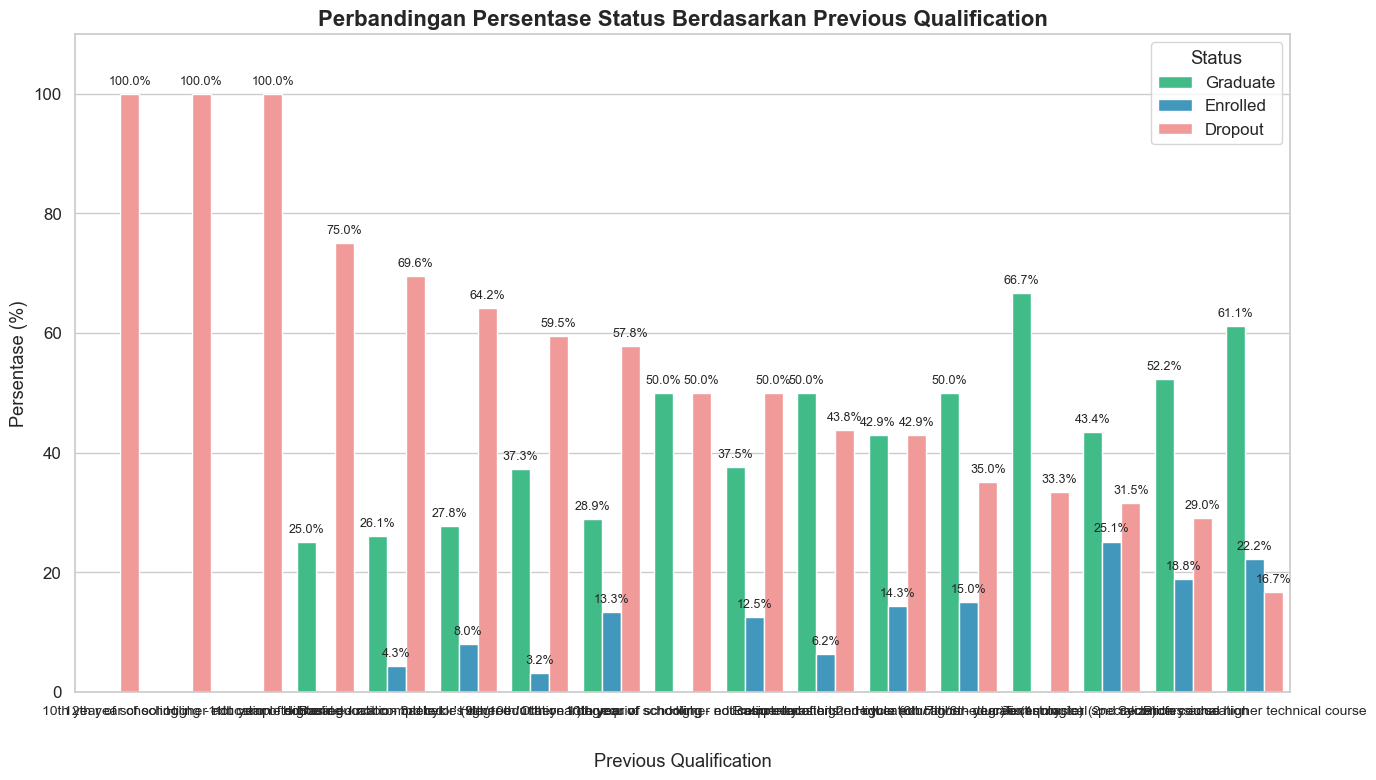

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=50, ha='right', fontsize=10)


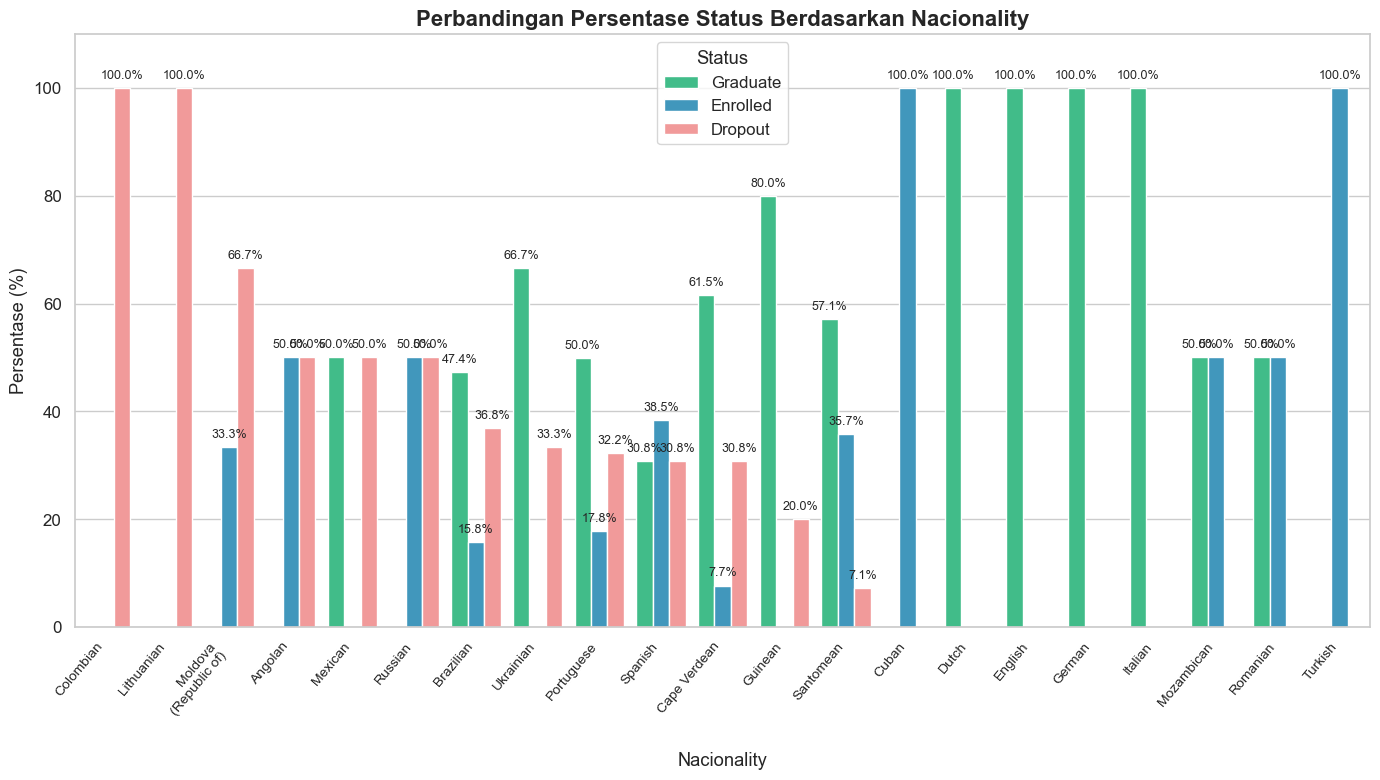

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


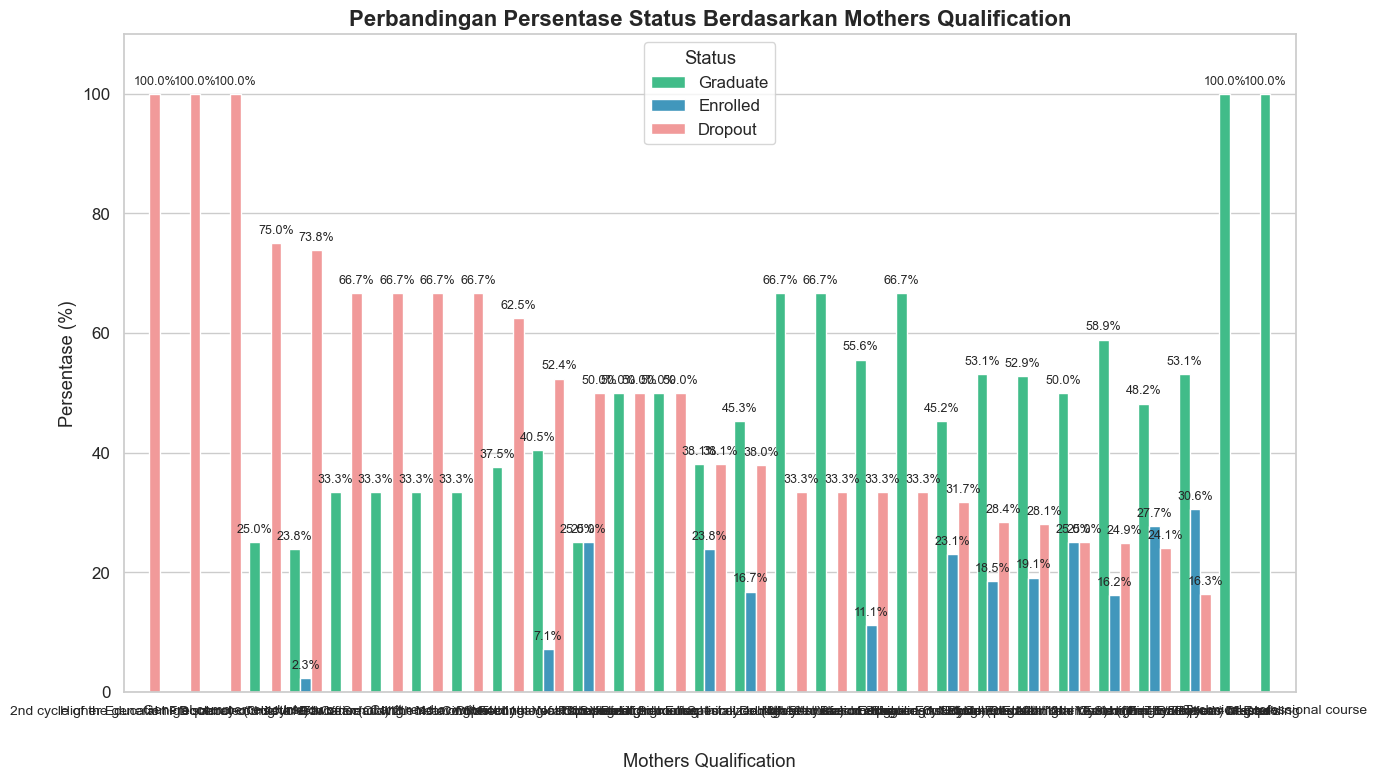

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


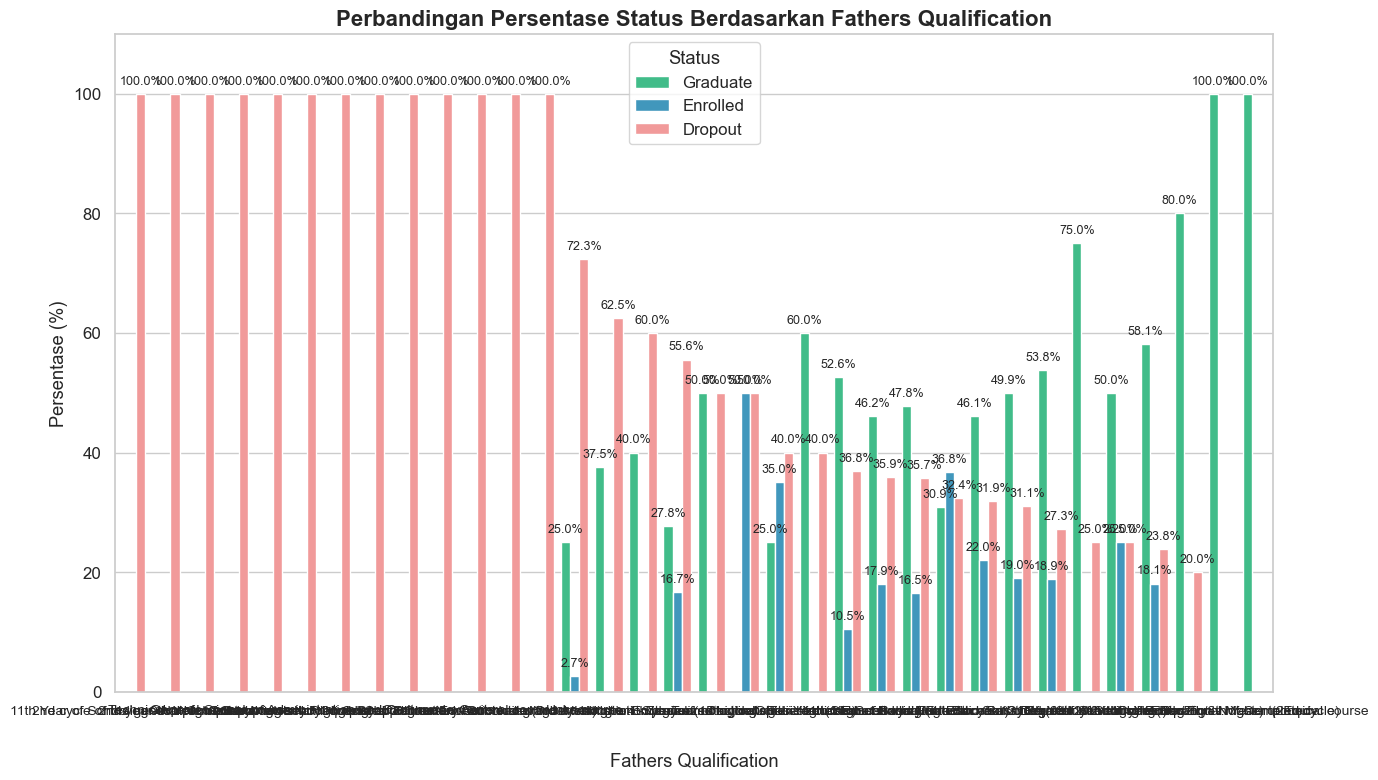

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=50, ha='right', fontsize=10)


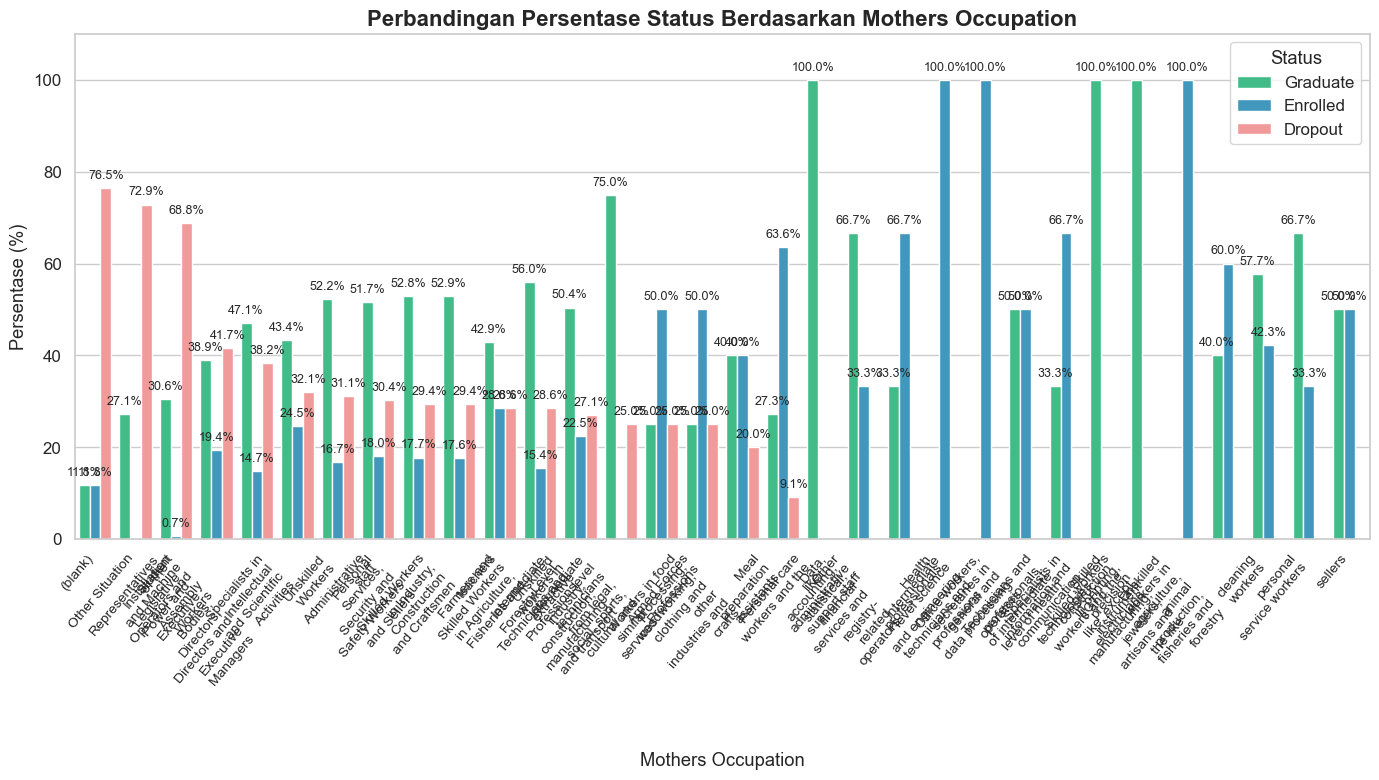

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=50, ha='right', fontsize=10)


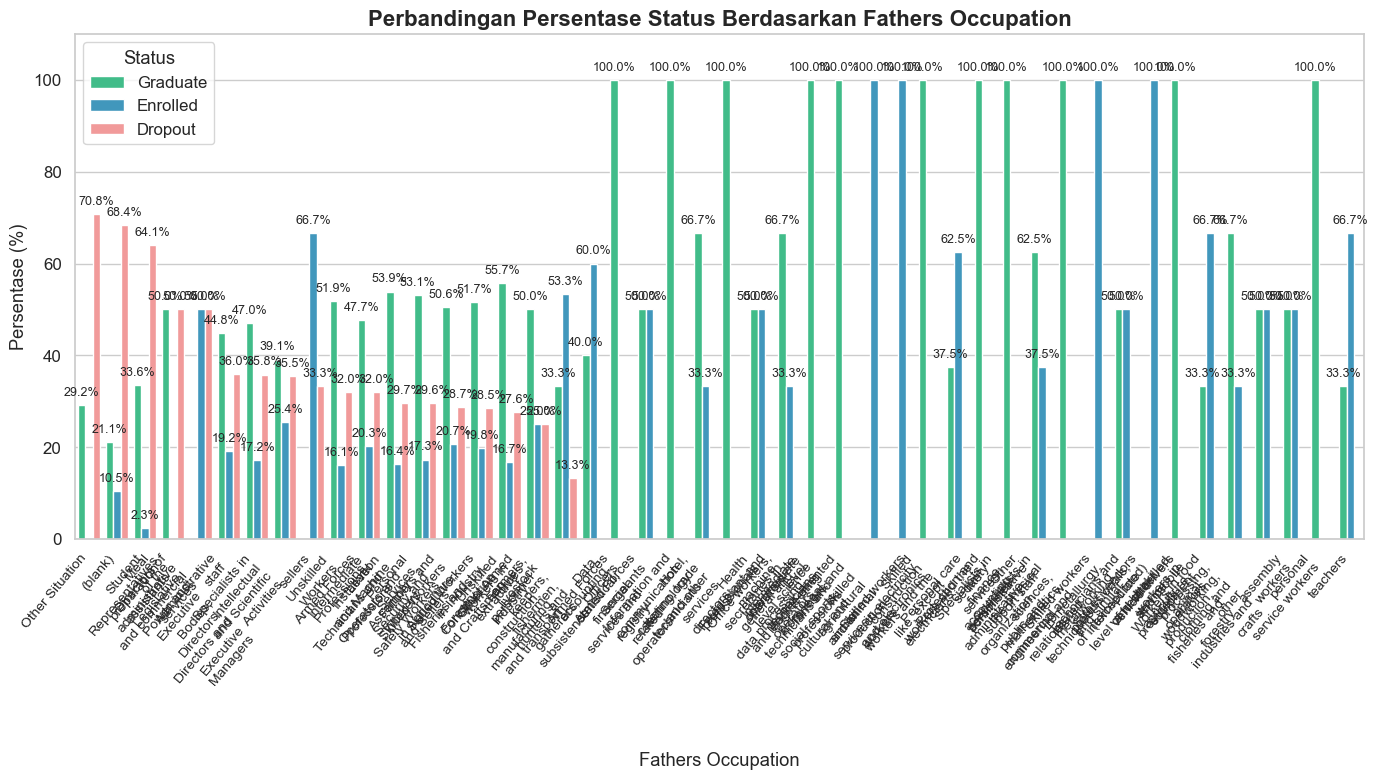

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


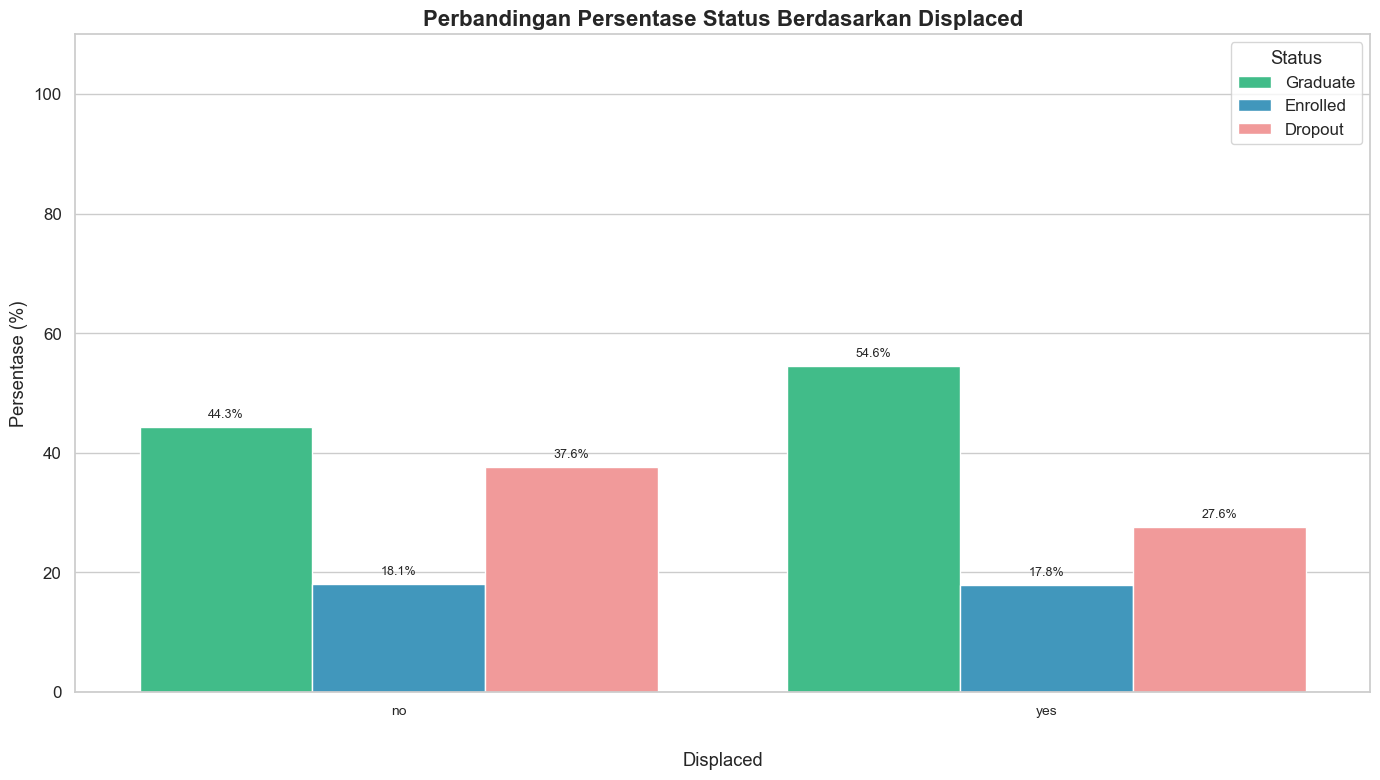

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


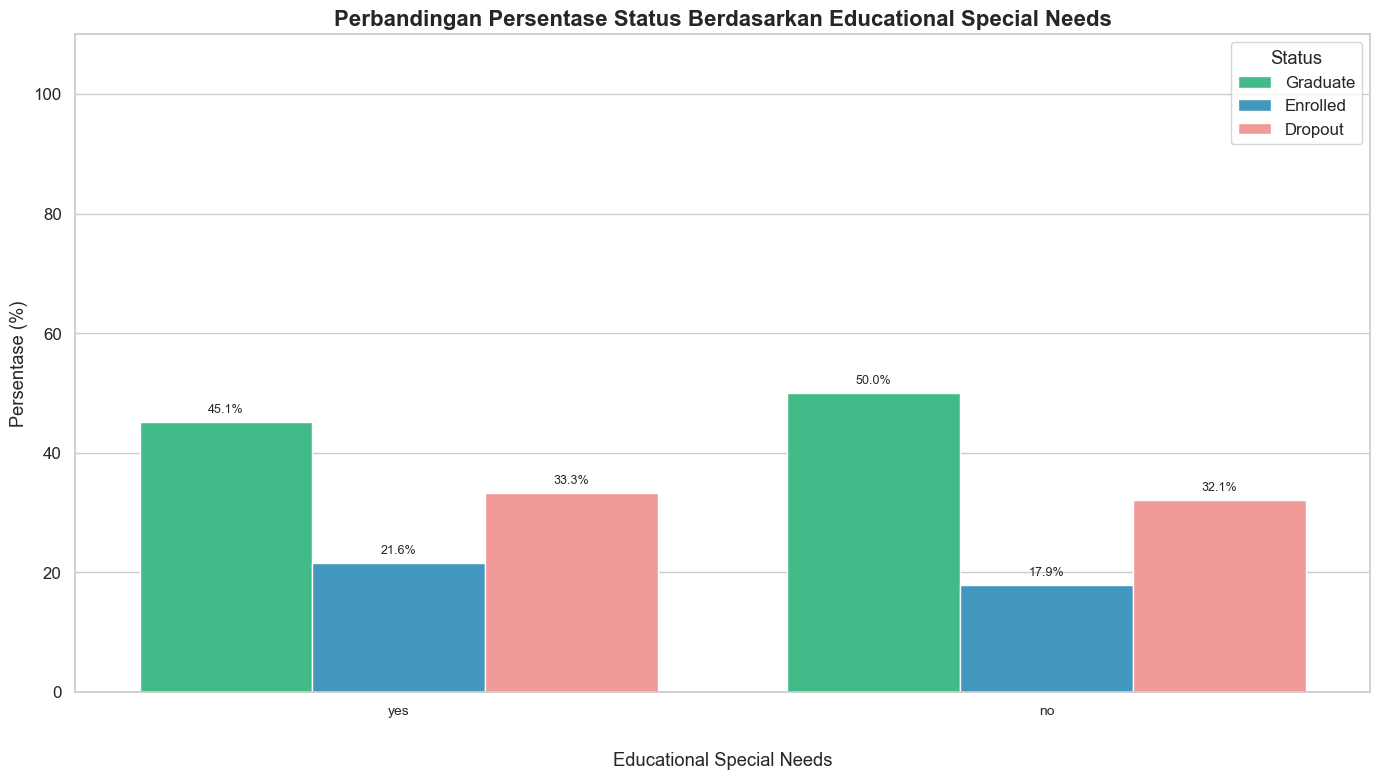

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


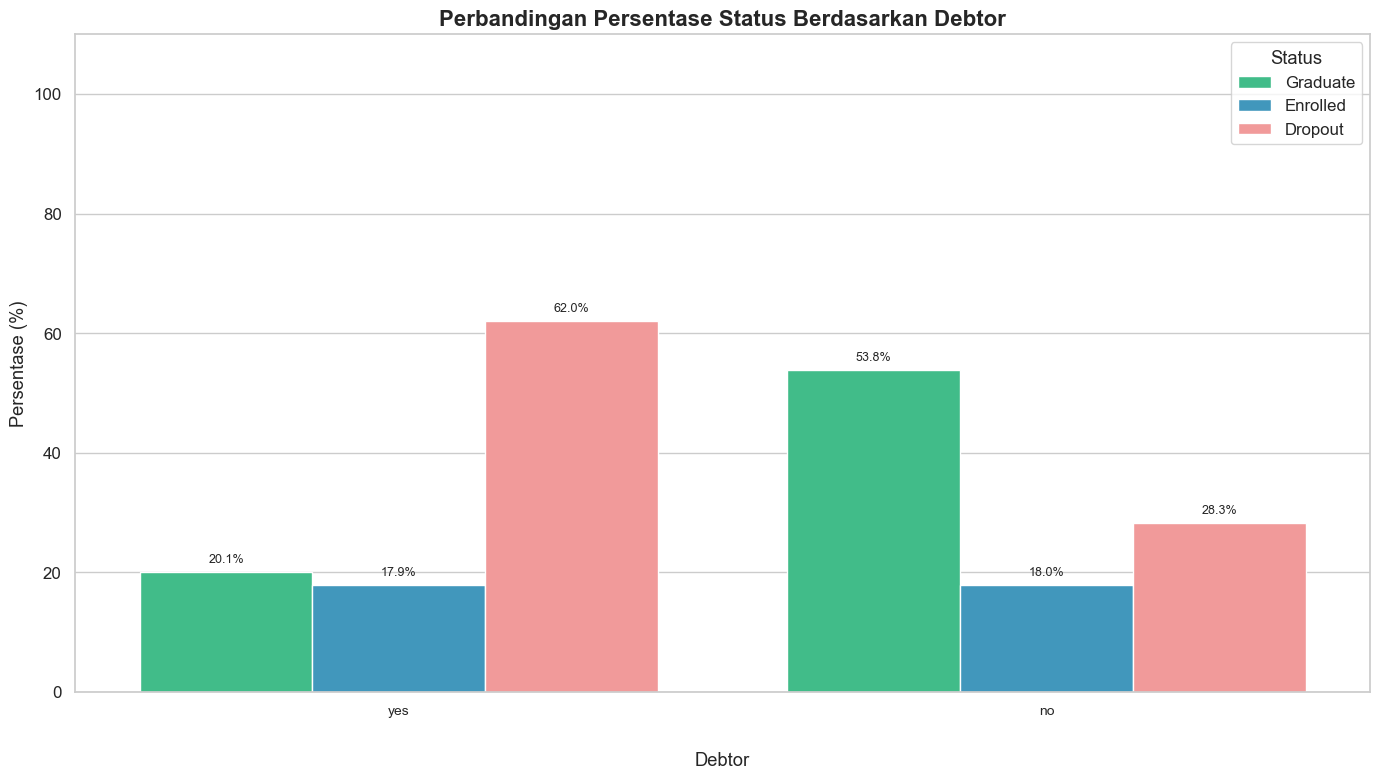

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


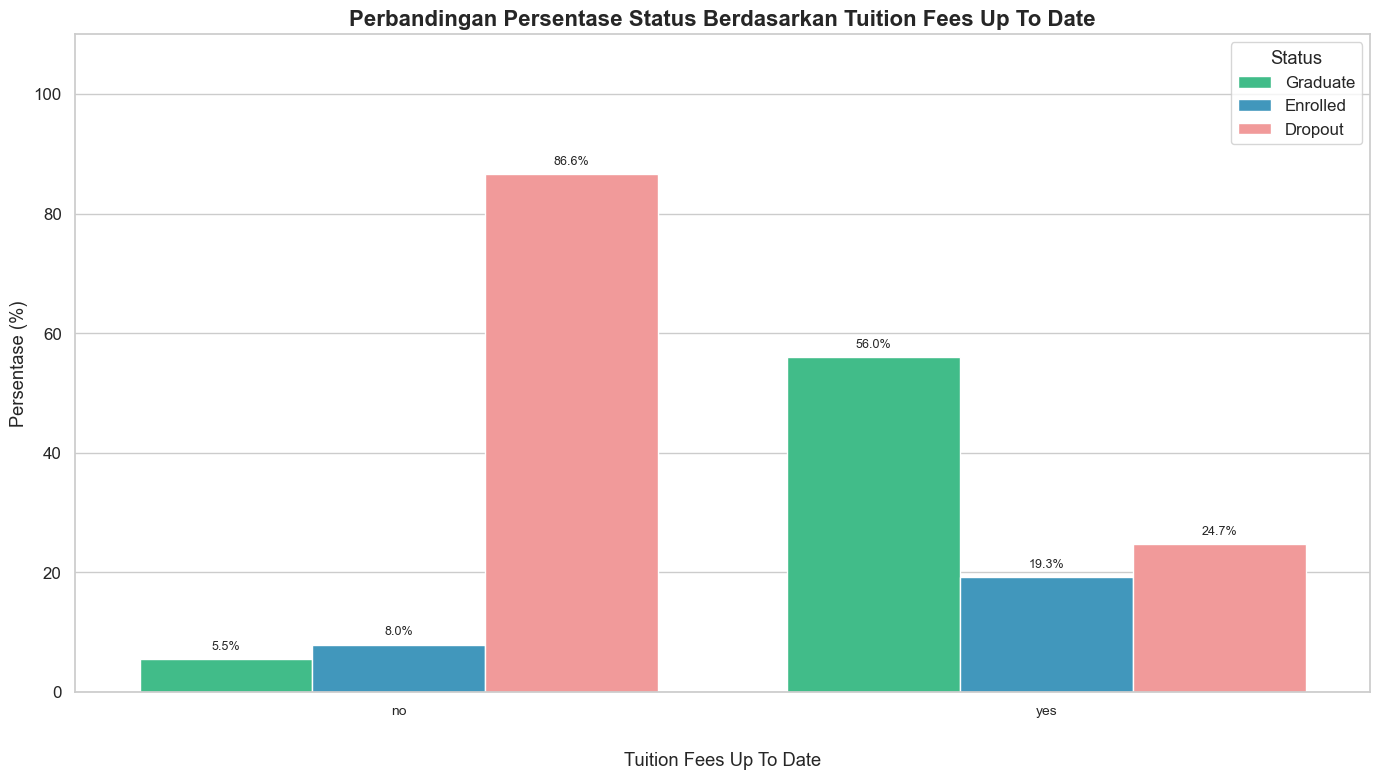

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


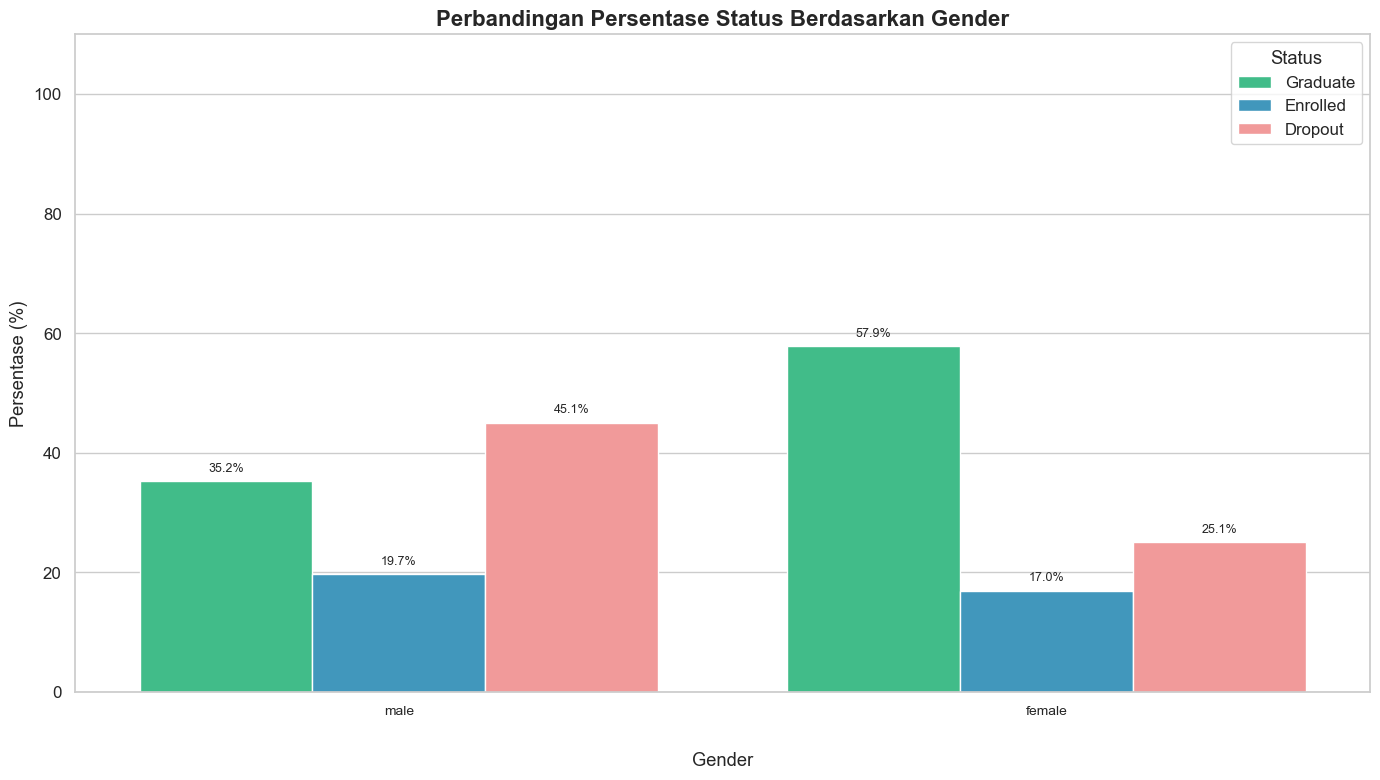

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


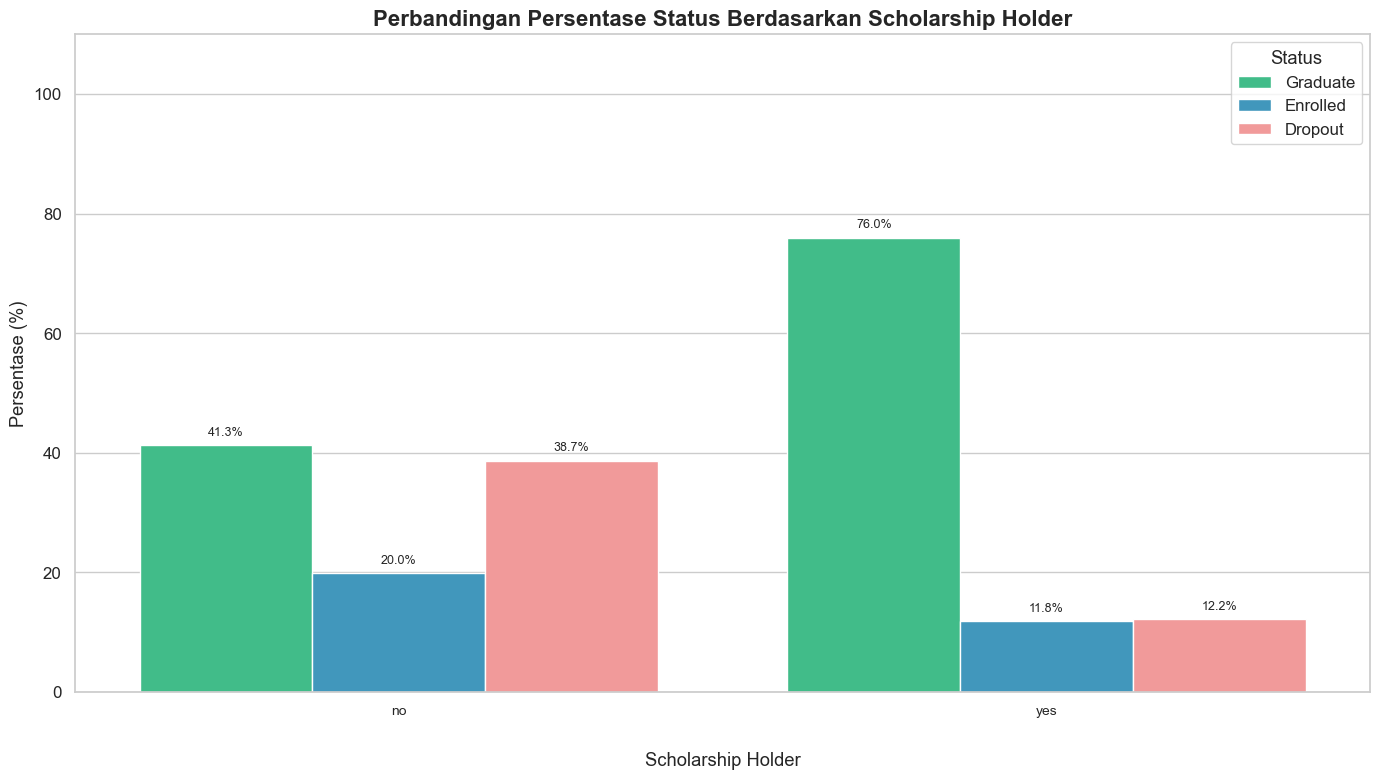

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


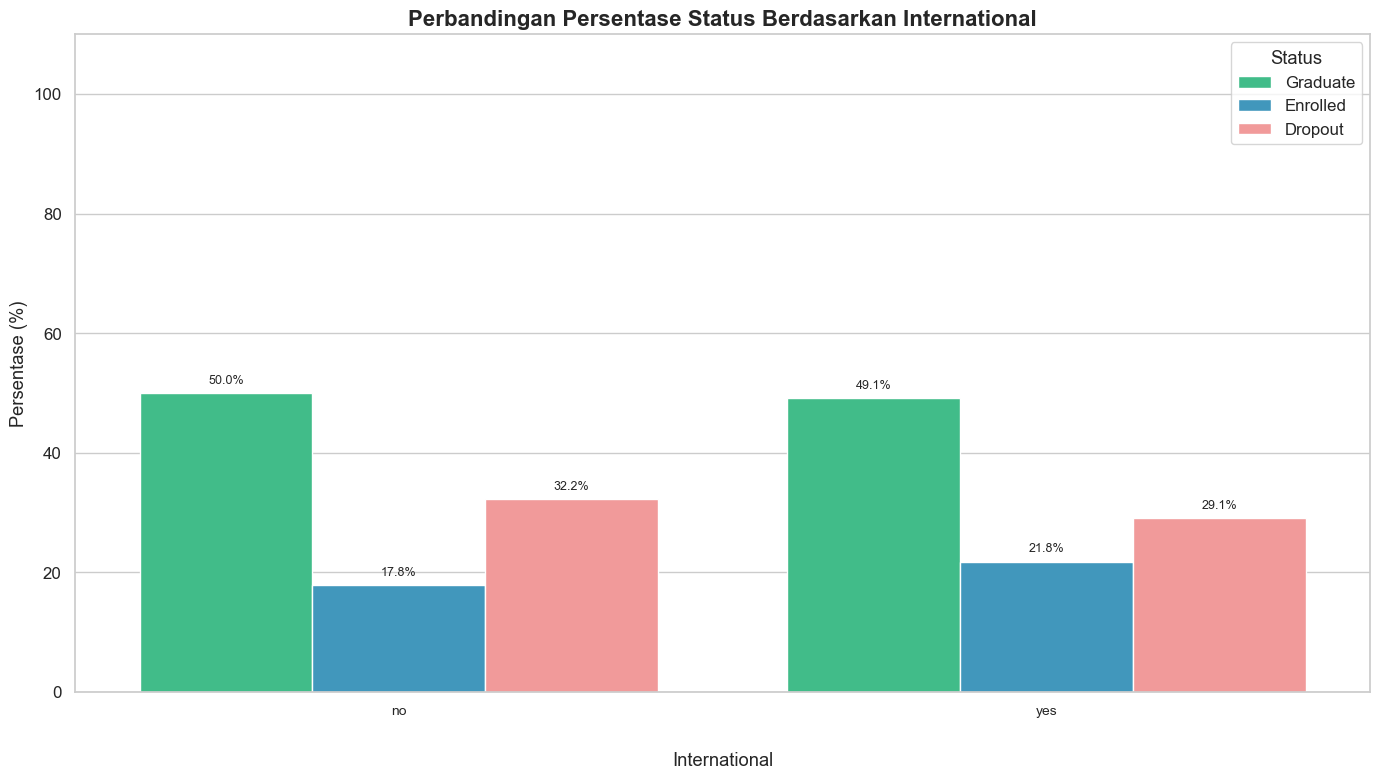

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = new_df.groupby(feature)['Status'] \
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\2766245925.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)


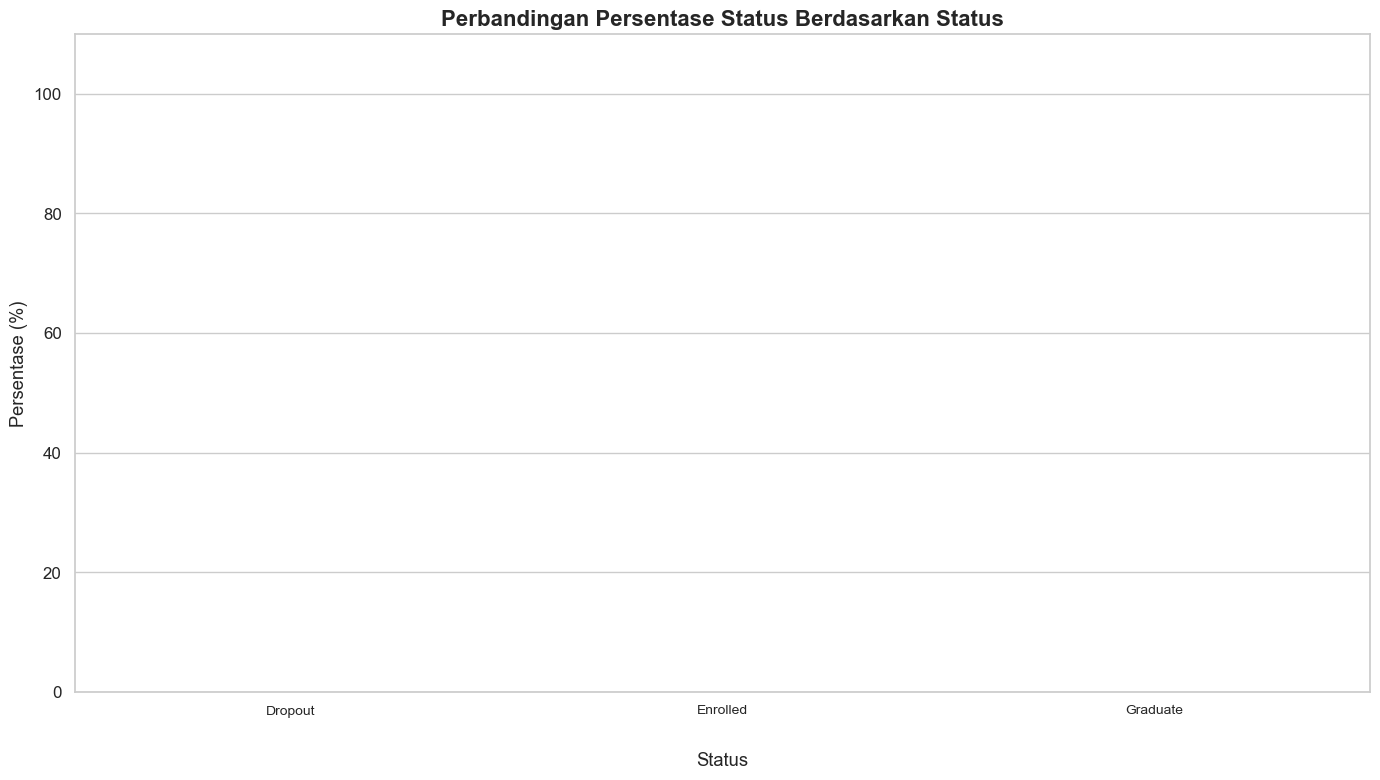

In [19]:
temp = [
    'Application_mode', 'Course', 'Nacionality', 'Mothers_occupation', 'Fathers_occupation'
]

for feature in categorical_cols:
    # 1. Hitung persentase dan ubah ke format long-form
    plot_data = new_df.groupby(feature)['Status'] \
                      .value_counts(normalize=True) \
                      .mul(100) \
                      .rename('percentage') \
                      .reset_index()
    
    # print(f"Columns in plot_data for {feature}: {plot_data.columns.tolist()}")
    
    # 2. Tentukan urutan kategori berdasarkan tingkat 'Dropout' tertinggi
    pivot_data = plot_data.pivot_table(index=feature, columns='Status', values='percentage', fill_value=0)
    
    if 'Dropout' in pivot_data.columns:
        sort_order = pivot_data.sort_values('Dropout', ascending=False).index
    else:
        print(f"Warning: 'Dropout' status not found for feature '{feature}'. Sorting by default.")
        sort_order = plot_data[feature].unique() # Urutan unik dari feature
        
    # 3. Buat visualisasi menggunakan barplot dengan 'hue'
    plt.figure(figsize=(14, 8)) 
    ax = sns.barplot(x=feature, y='percentage', hue='Status', data=plot_data, 
                     order=sort_order, hue_order=['Graduate', 'Enrolled', 'Dropout'], 
                     palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})

    # 4. Tambahkan anotasi persentase di atas setiap bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0.01: 
            ax.annotate(f'{height:.1f}%', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points',
                        fontsize=9,) 
    
    plt.title(f'Perbandingan Persentase Status Berdasarkan {feature.replace("_", " ").title()}', fontsize=16, fontweight='bold')
    plt.ylabel('Persentase (%)')
    plt.xlabel(feature.replace("_", " ").title(), labelpad=25) 

    # Penyesuaian label x-axis
    if feature in temp:
        # textwrap.fill untuk memecah teks panjang menjadi beberapa baris
        labels = [textwrap.fill(label.get_text(), width=15) for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=50, ha='right', fontsize=10) 
    else:
        plt.xticks(rotation=0, fontsize=10)


    plt.ylim(0, 110) # Batas y-axis hingga 110% untuk memberi ruang anotasi
    plt.tight_layout()
    plt.show()

##### Numerical vs Status

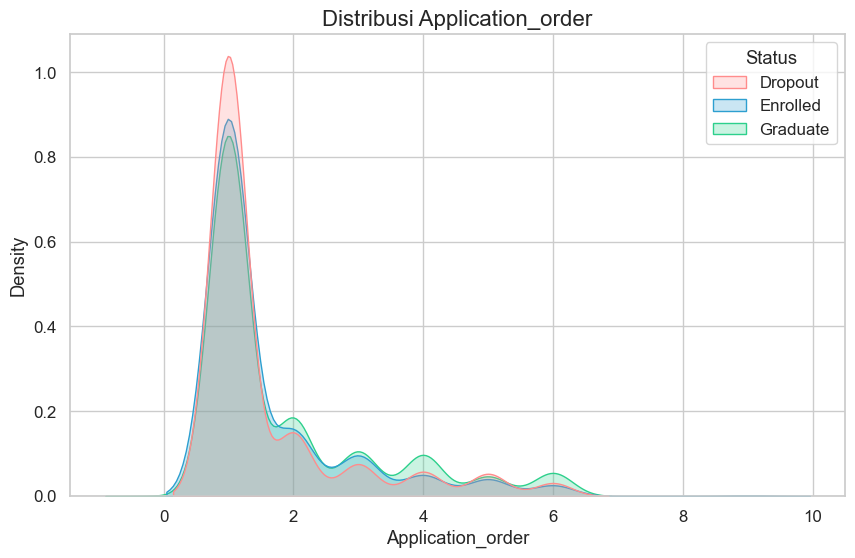

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


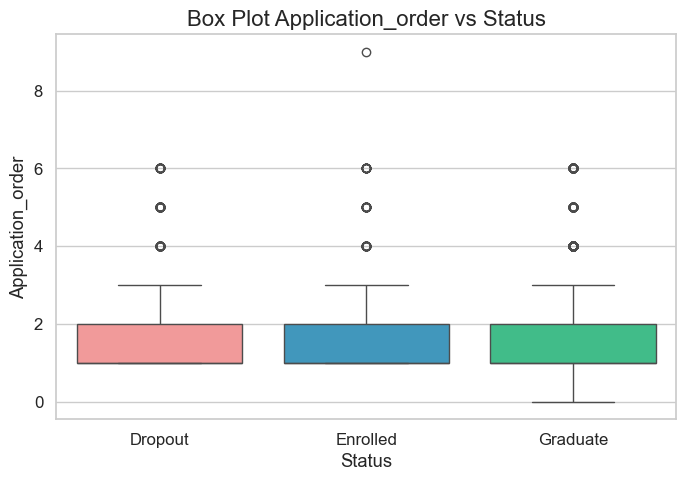

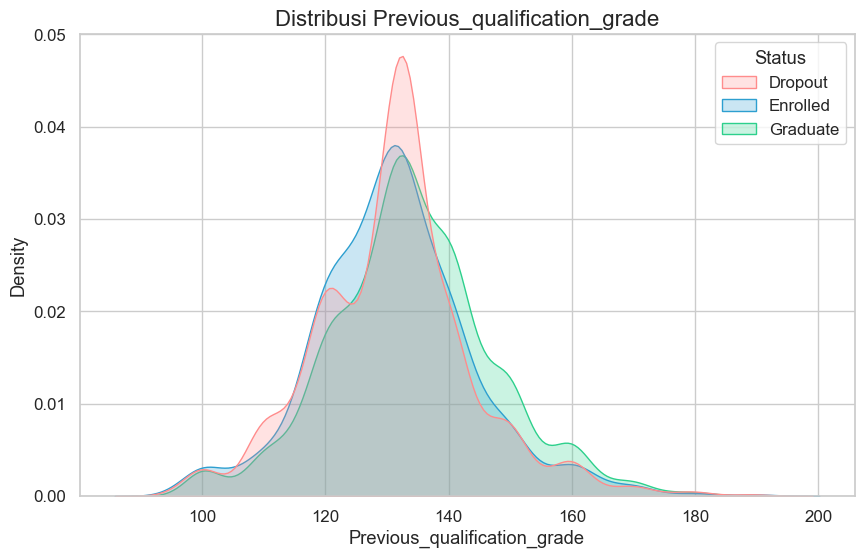

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


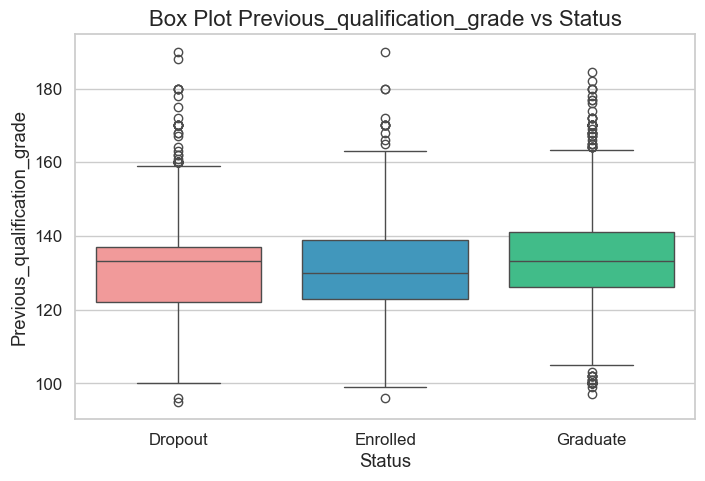

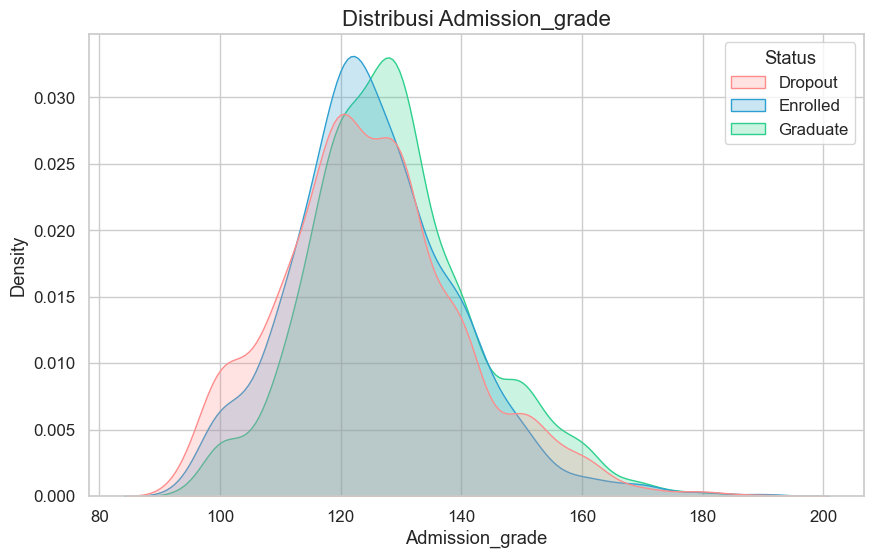

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


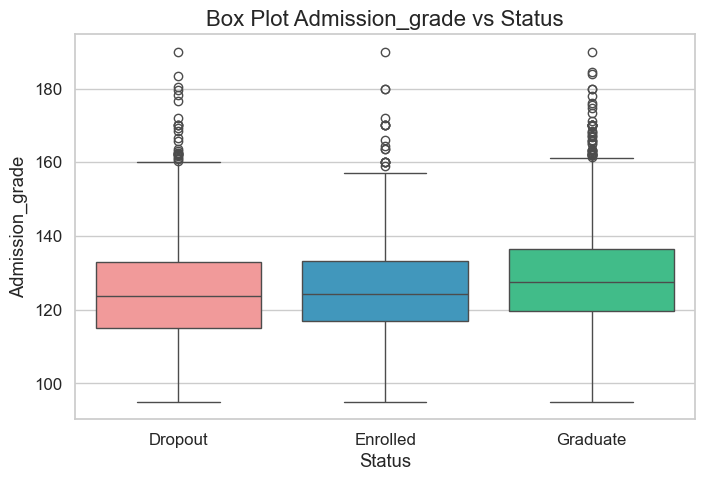

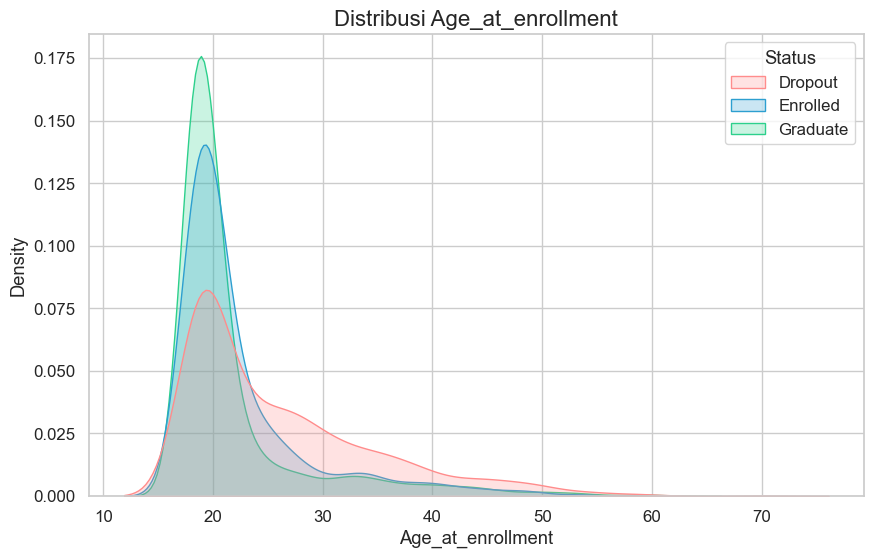

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


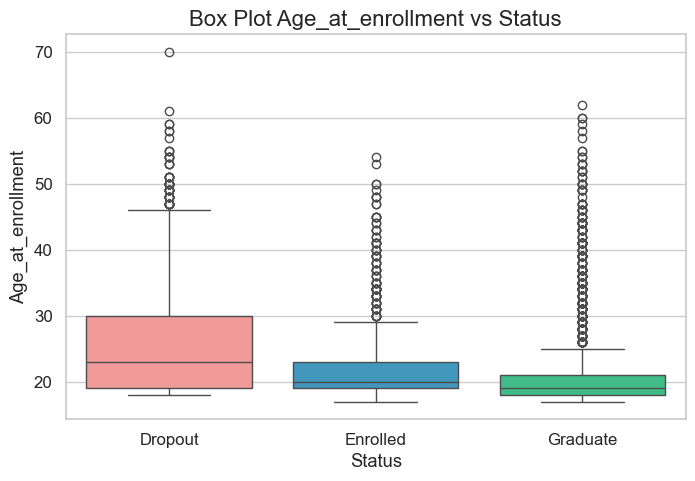

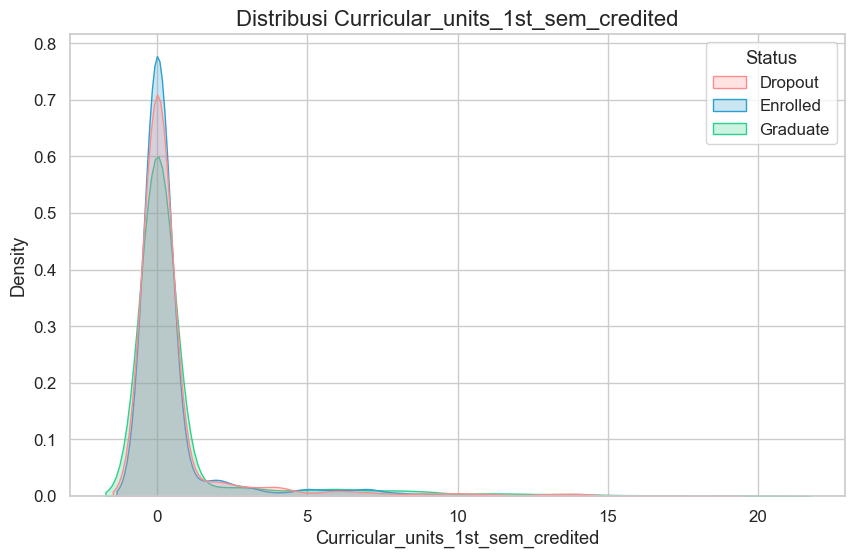

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


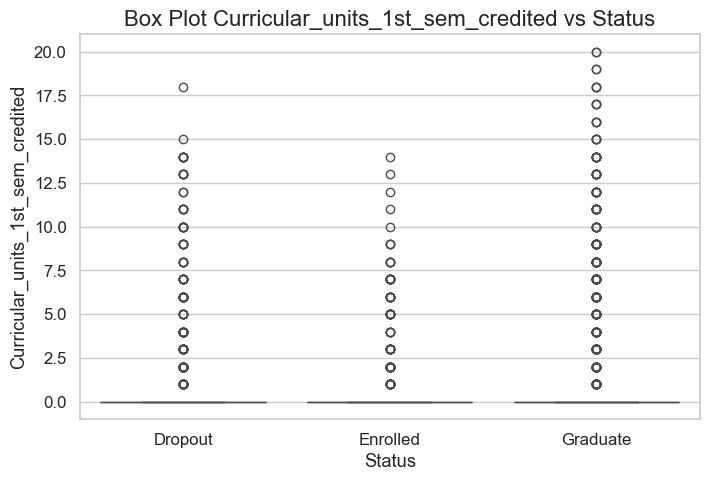

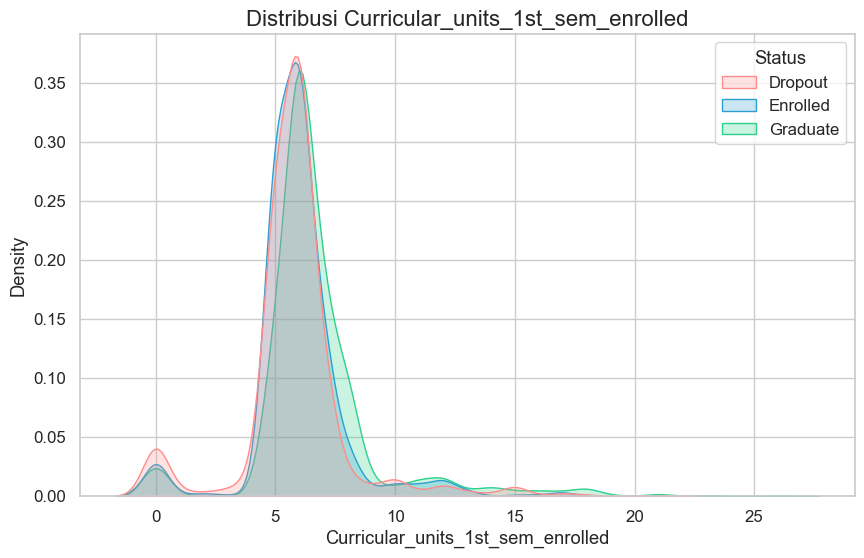

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


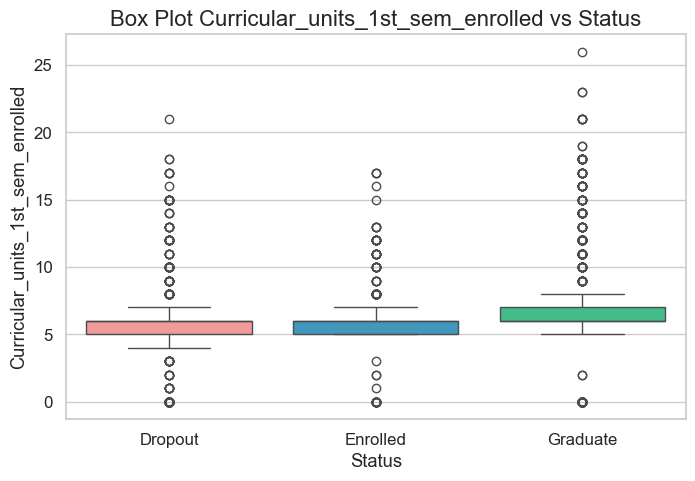

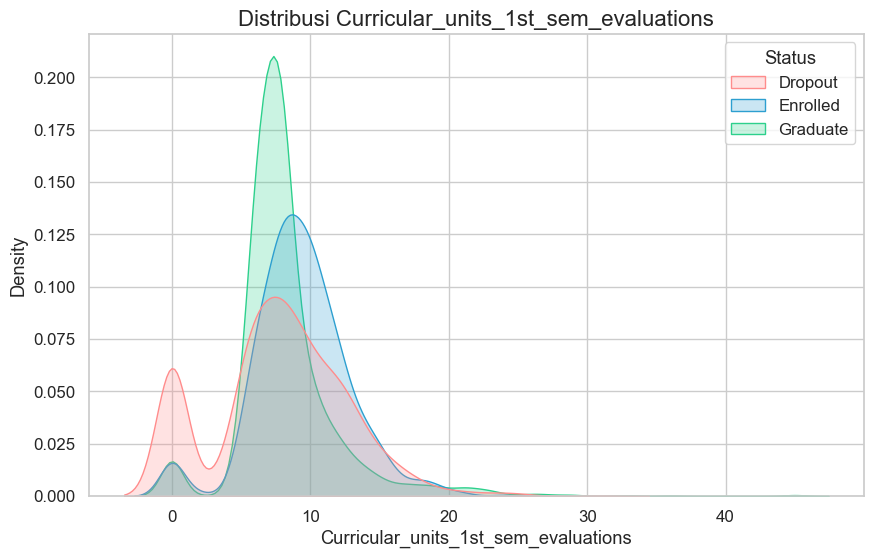

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


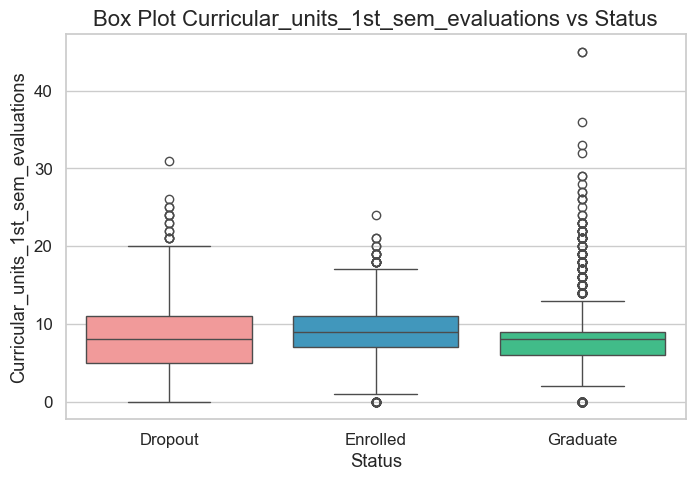

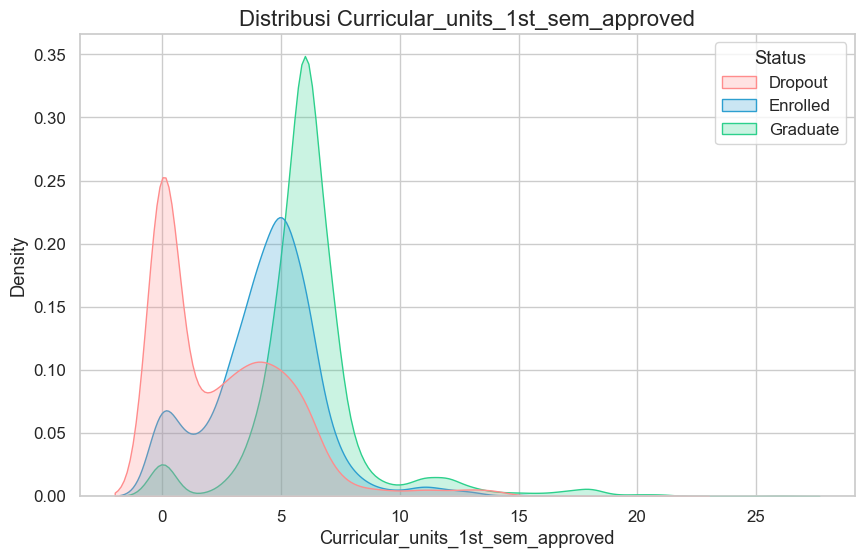

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


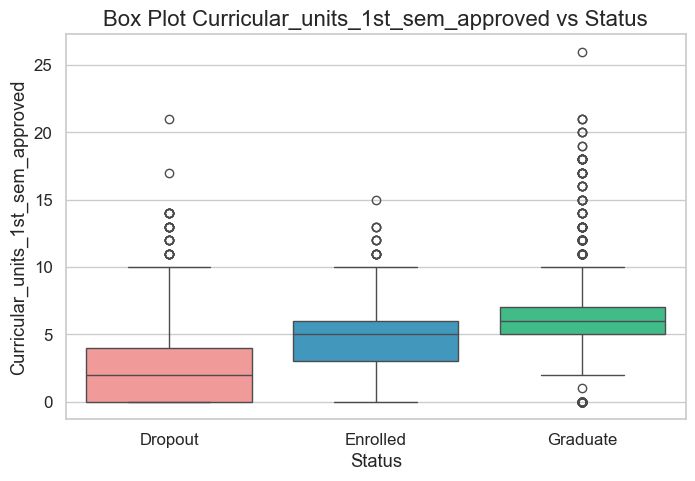

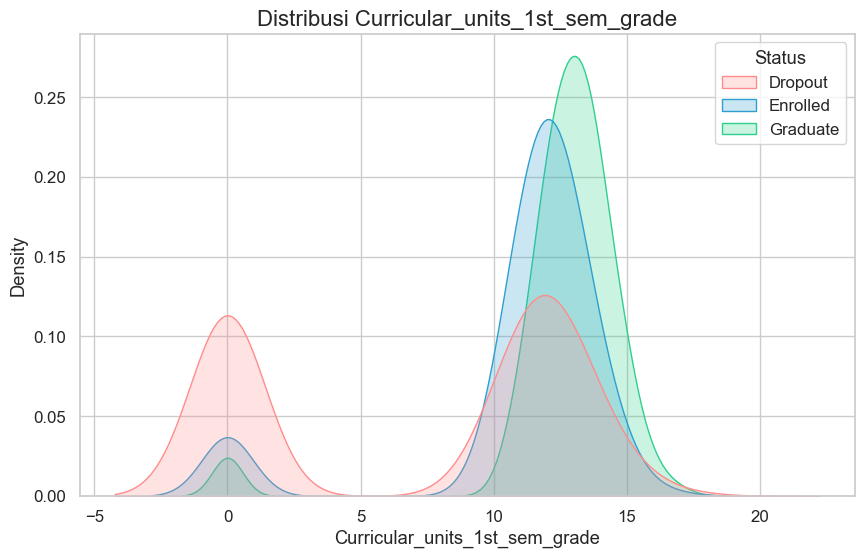

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


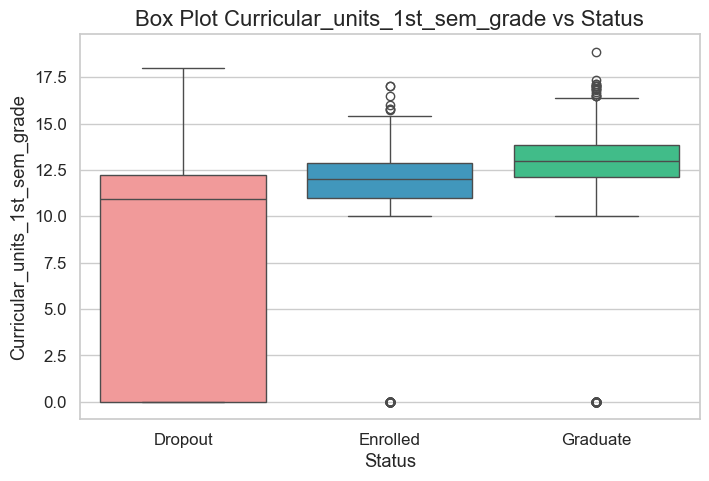

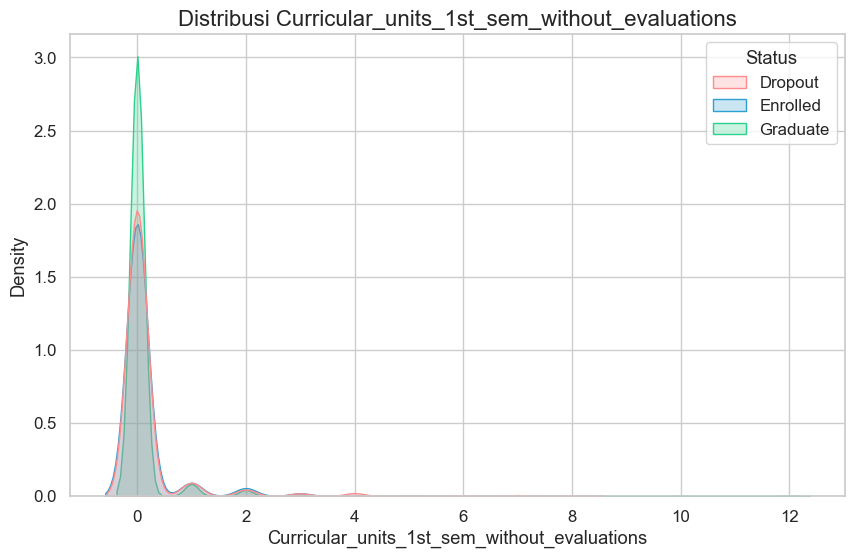

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


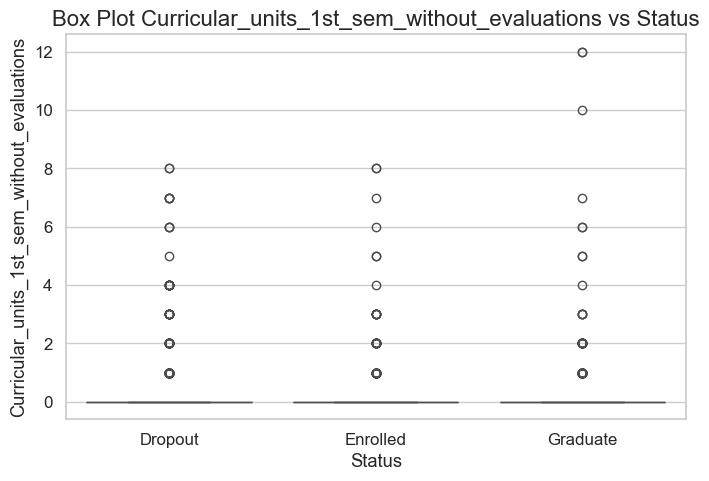

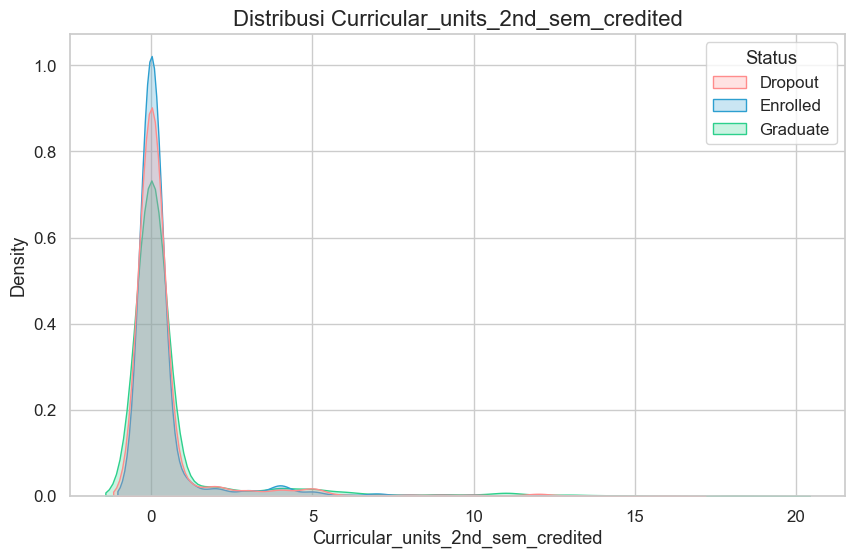

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


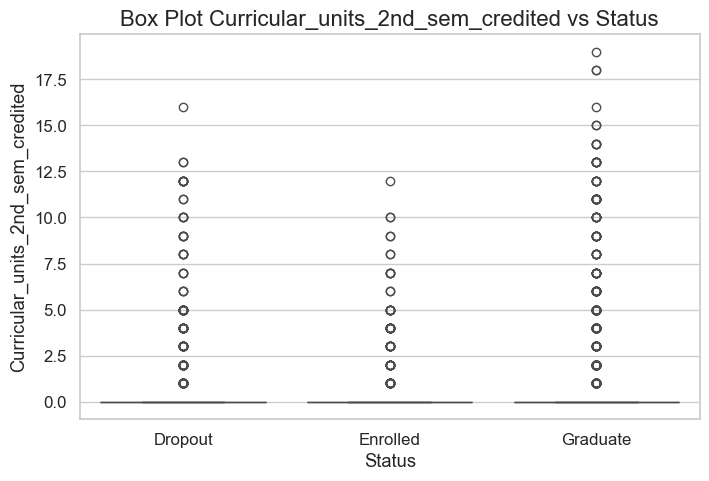

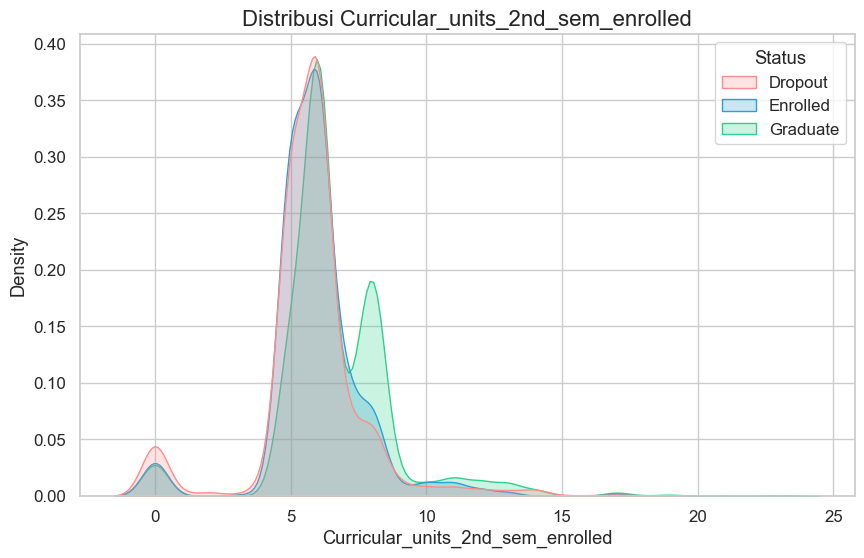

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


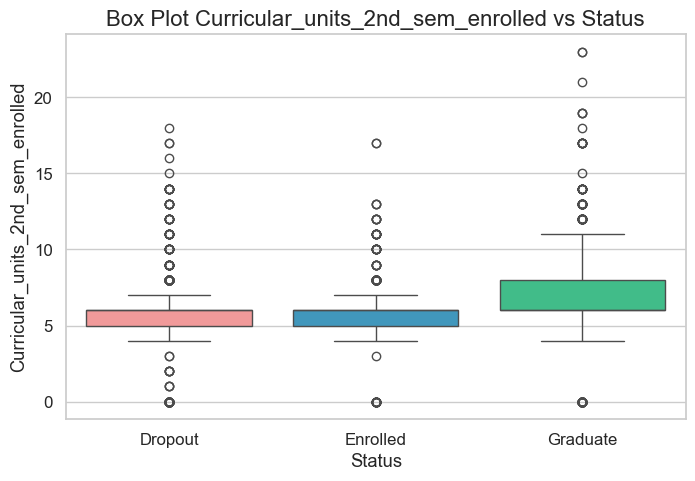

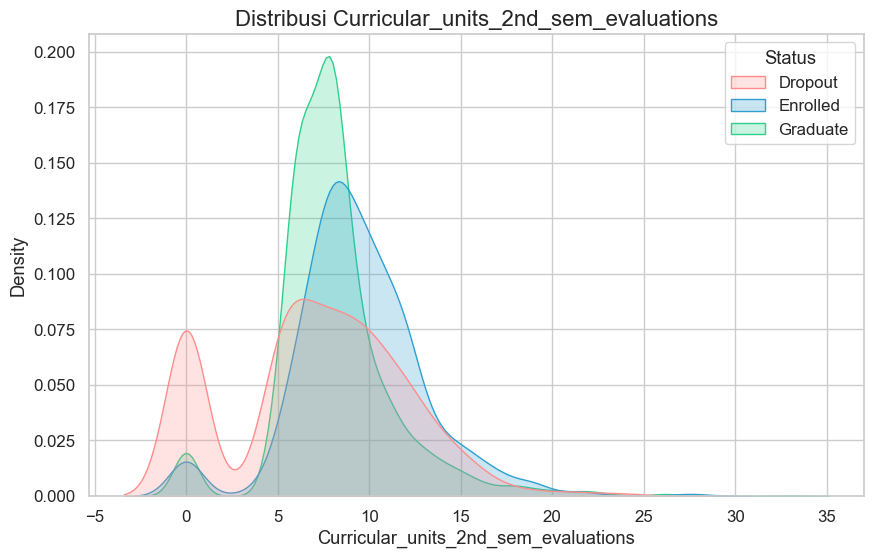

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


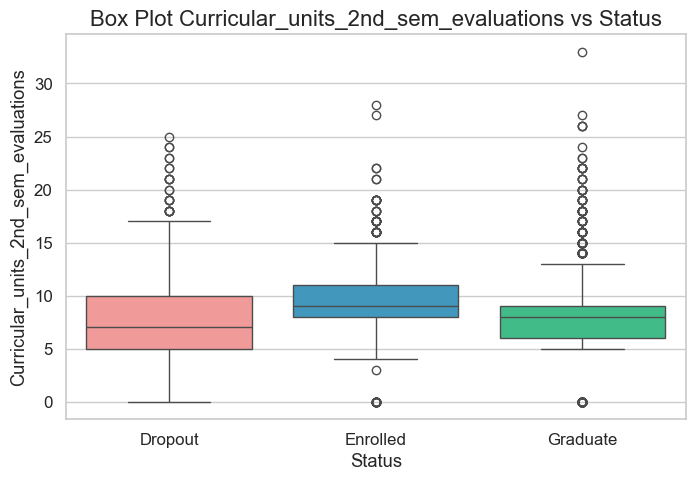

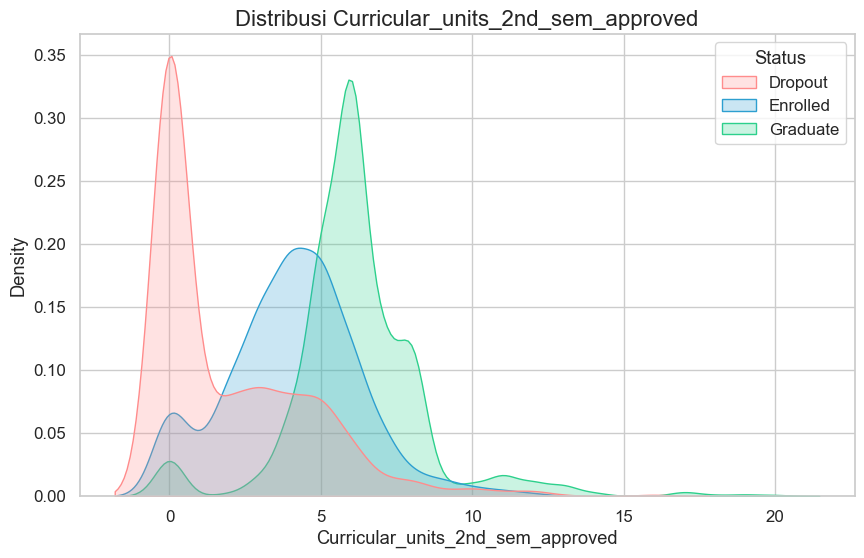

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


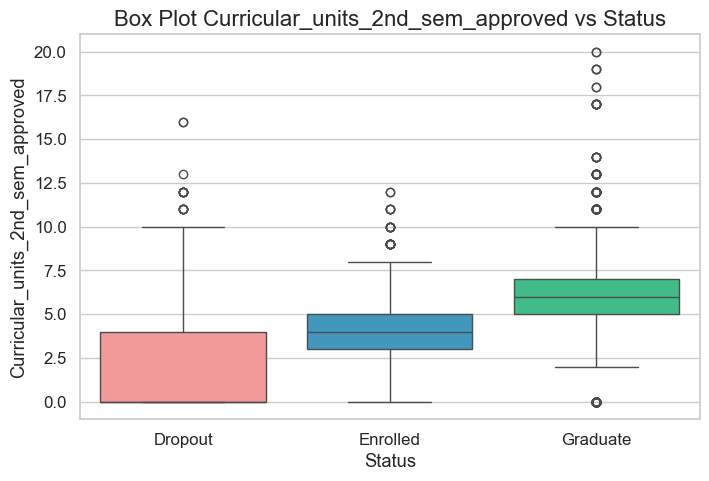

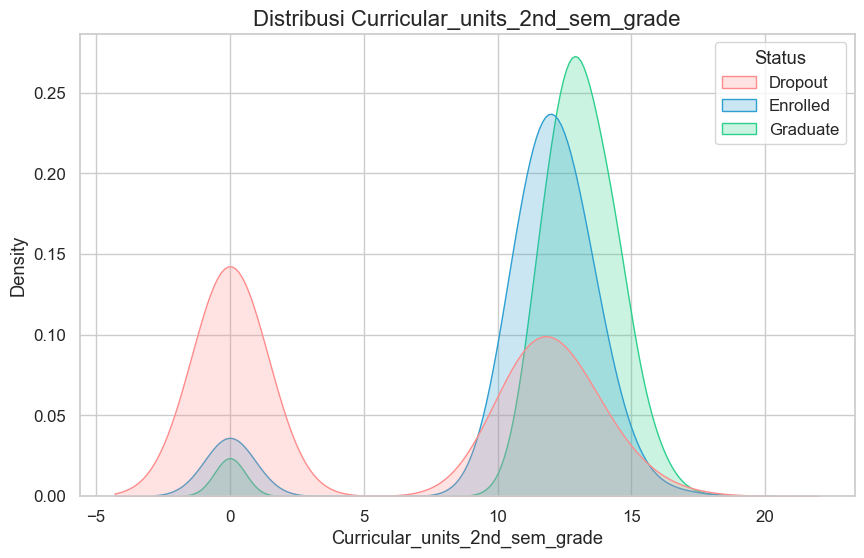

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


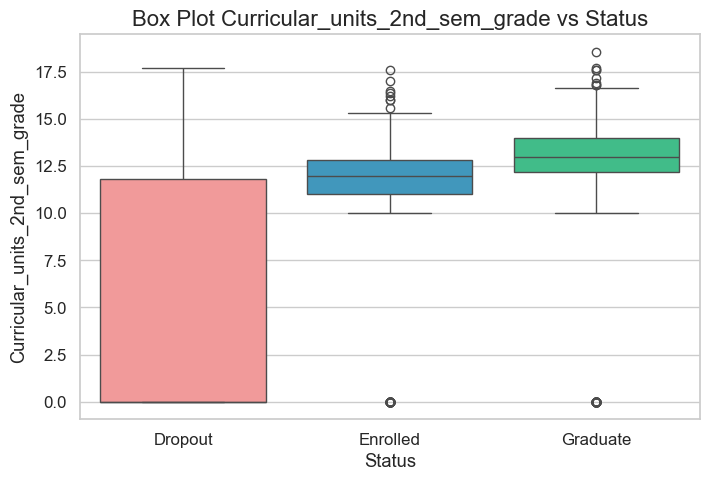

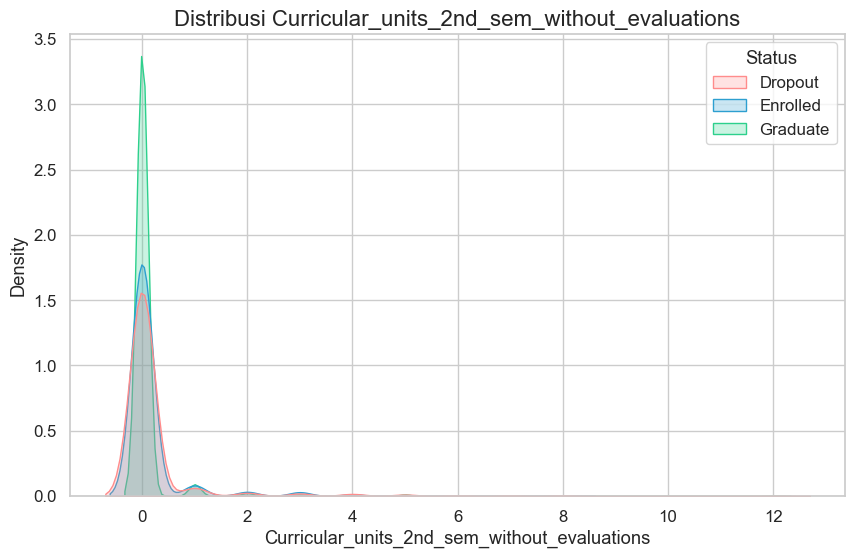

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


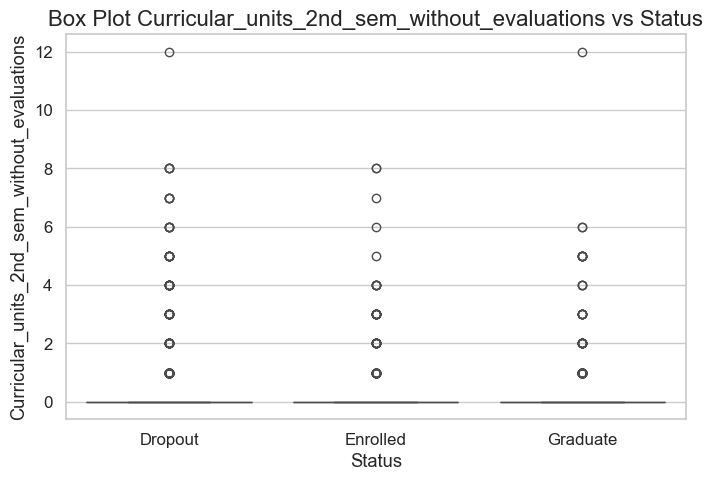

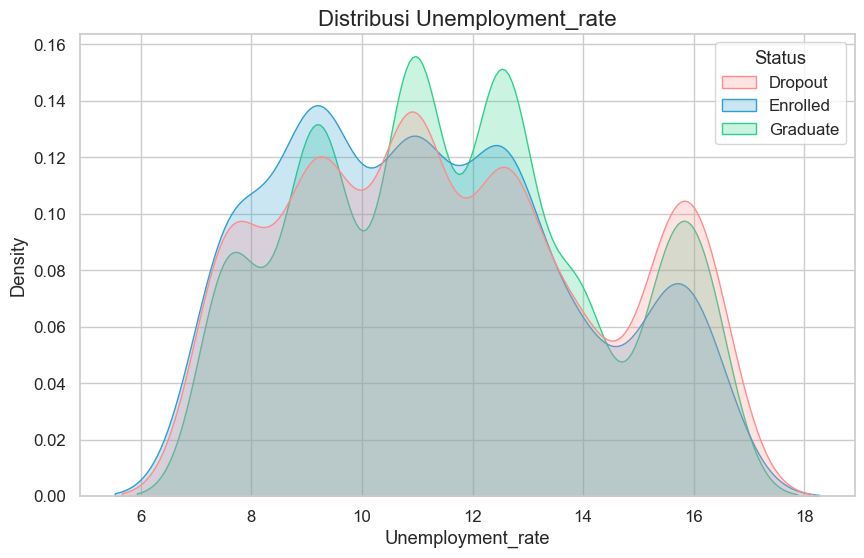

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


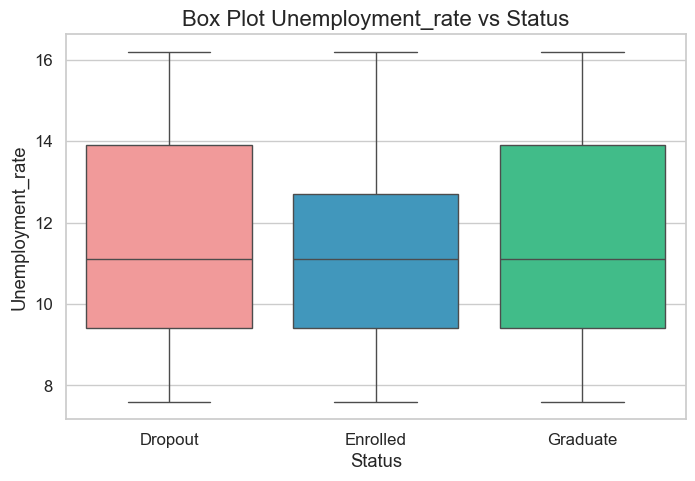

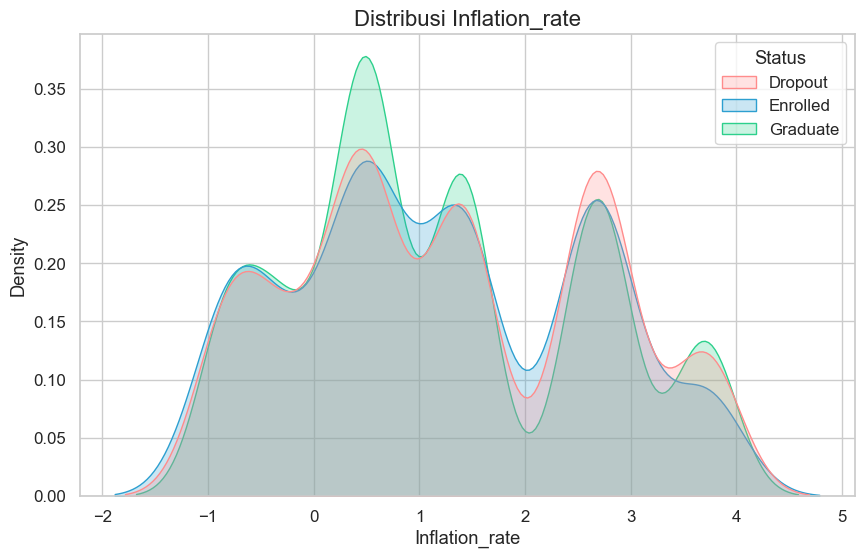

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


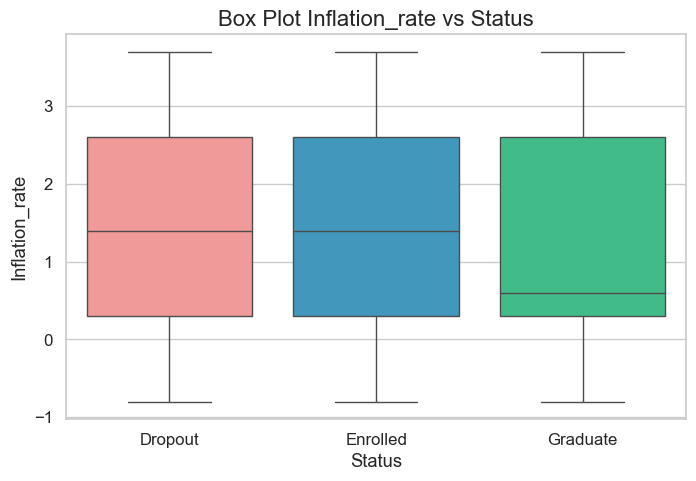

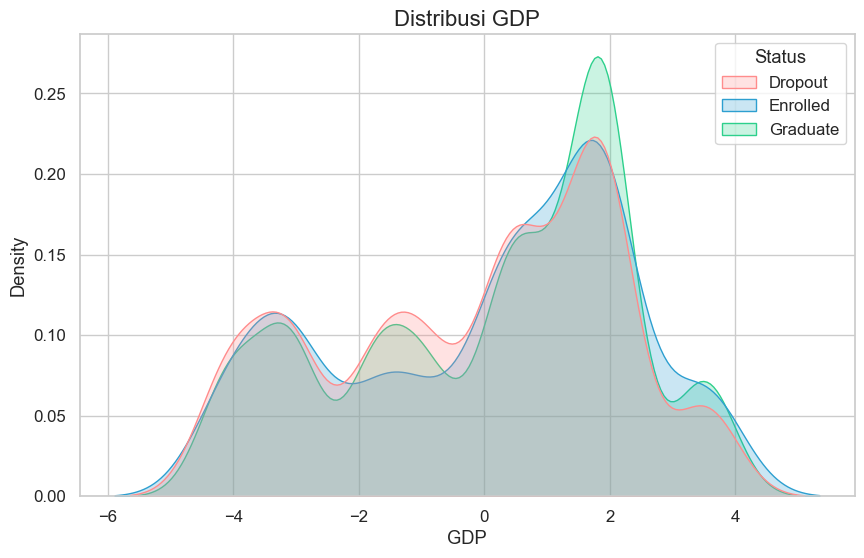

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16796\1227174548.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})


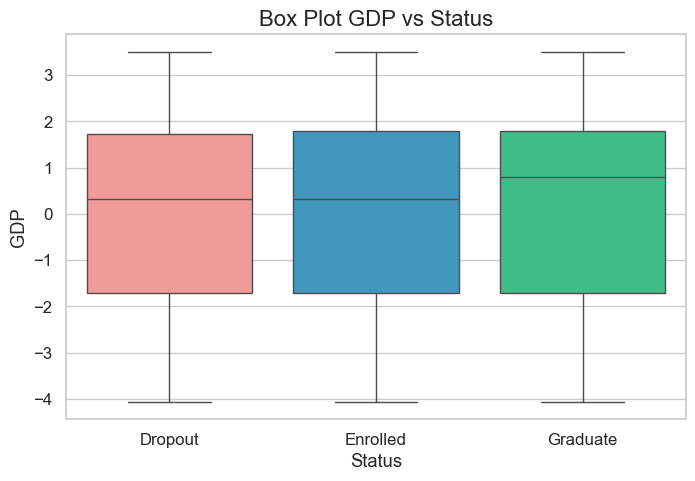

In [20]:
for feature in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=new_df, x=feature, hue='Status', fill=True, common_norm=False, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})
    plt.title(f'Distribusi {feature}', fontsize=16)
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Status', y=feature, data=new_df, palette={'Graduate': '#2DD08C', 'Enrolled': '#2D9FD0', 'Dropout':'#ff8c8c'})
    plt.title(f'Box Plot {feature} vs Status', fontsize=16)
    plt.show()

##### Correlation

In [21]:
correlation_matrix_features = new_df[numerical_cols].corr()

upper_tri = correlation_matrix_features.where(np.triu(np.ones(correlation_matrix_features.shape), k=1).astype(bool))

high_corr_features = upper_tri.stack().sort_values(ascending=False)
high_corr_features = high_corr_features[high_corr_features.abs() > 0.2]

print("\nPasangan fitur numerik dengan korelasi absolut > 0.2:")
if not high_corr_features.empty:
    print(high_corr_features)
else:
    print("Tidak ada pasangan fitur numerik dengan korelasi absolut > 0.2.")


Pasangan fitur numerik dengan korelasi absolut > 0.2:
Curricular_units_1st_sem_credited             Curricular_units_2nd_sem_credited               0.944811
Curricular_units_1st_sem_enrolled             Curricular_units_2nd_sem_enrolled               0.942627
Curricular_units_1st_sem_approved             Curricular_units_2nd_sem_approved               0.904002
Curricular_units_1st_sem_grade                Curricular_units_2nd_sem_grade                  0.837170
Curricular_units_1st_sem_evaluations          Curricular_units_2nd_sem_evaluations            0.778863
Curricular_units_1st_sem_credited             Curricular_units_1st_sem_enrolled               0.774344
Curricular_units_1st_sem_enrolled             Curricular_units_1st_sem_approved               0.769083
Curricular_units_2nd_sem_approved             Curricular_units_2nd_sem_grade                  0.760804
Curricular_units_1st_sem_enrolled             Curricular_units_2nd_sem_credited               0.753747
Curricular_units_1

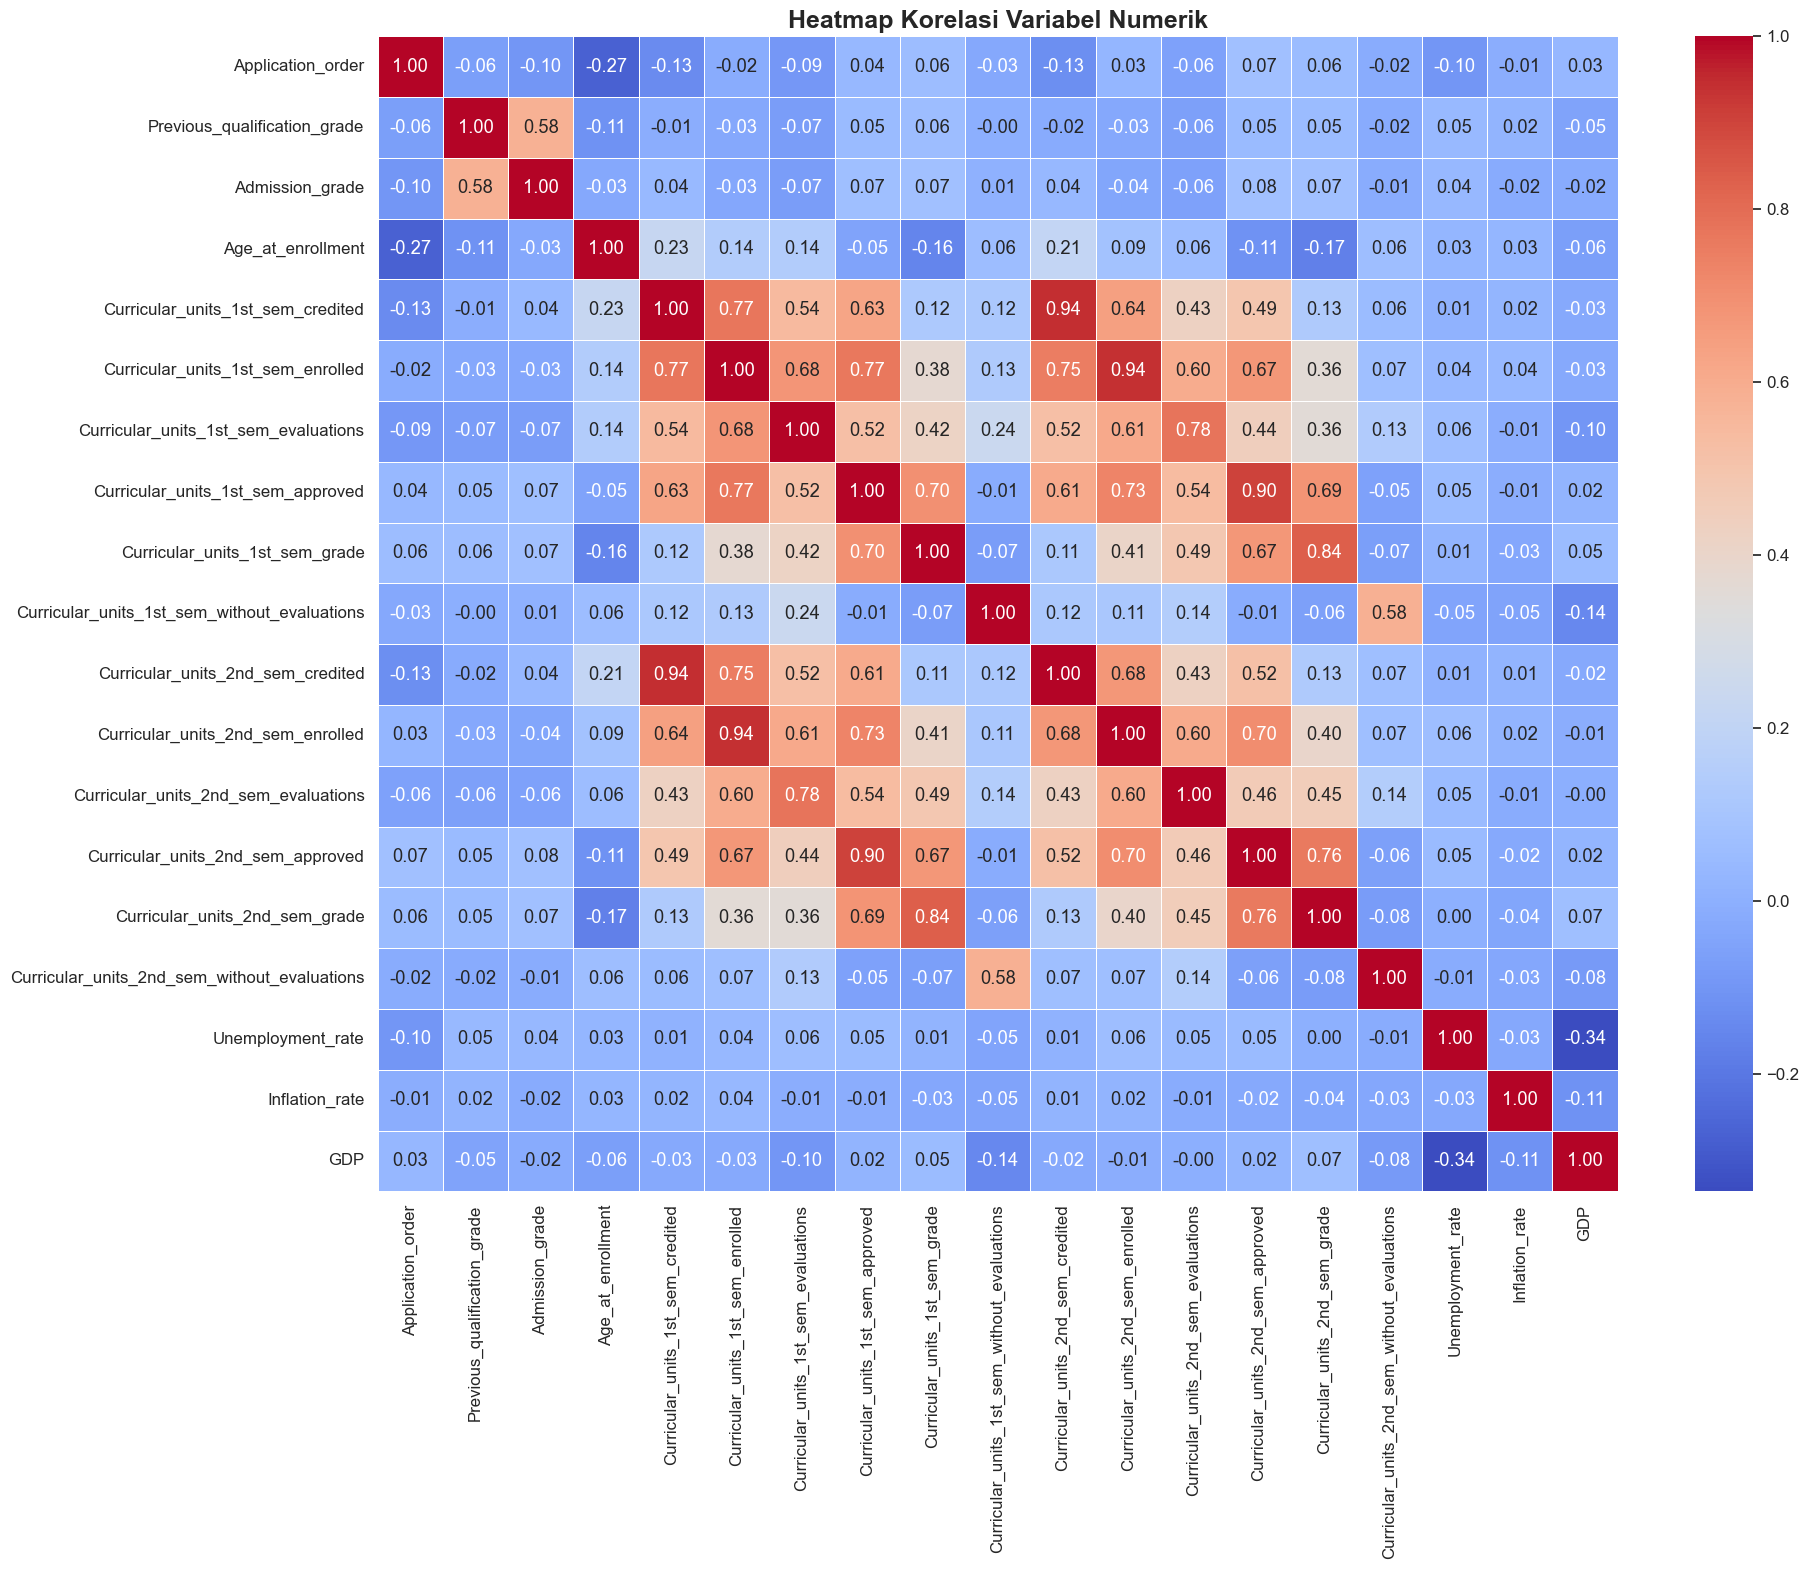

In [22]:
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix_features, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Heatmap Korelasi Variabel Numerik', fontsize=18, fontweight='bold')
plt.show()

## Data Preparation / Preprocessing

### Re-categorized

In [23]:
def group_education_qualification(df, column_name):
    """
    Mengelompokkan kategori kualifikasi pendidikan (Previous, Mothers, Fathers)
    ke dalam kategori yang lebih luas dan konsisten.
    """
    def map_qual(qual):
        # Kualifikasi Pendidikan Tinggi
        higher_edu_quals = [
            'Higher education - degree', 'Higher education - degree (1st cycle)',
            'Higher education - bachelor\'s degree', 'Higher education - master\'s',
            'Higher education - master (2nd cycle)', 'Higher education - doctorate',
            'Higher Education - Bachelor\'s Degree', 'Higher Education - Degree',
            'Higher Education - Master\'s', 'Higher Education - Doctorate',
            'Higher Education - Master (2nd cycle)', 'Higher Education - Doctorate (3rd cycle)',
            'Frequency of Higher Education', 'Technological specialization course',
            'Specialized higher studies course', 'Professional higher technical course'
        ]

        # Kualifikasi Pendidikan Menengah (Secondary)
        secondary_edu_quals = [
            'Secondary education', # Khusus untuk Previous_qualification
            'Secondary Education - 12th Year of Schooling or Eq.',
            '12th Year of Schooling - Not Completed',
            '11th Year of Schooling - Not Completed',
            'Other - 11th Year of Schooling'
            '10th Year of Schooling', '10th Year of Schooling - Not Completed',
            '2nd year complementary high school course', 'General commerce course',
            'Complementary High School Course', 'Complementary High School Course - not concluded',
            'Supplementary Accounting and Administration', 'Technical-professional course'
        ]

        # Kualifikasi Pendidikan Dasar (Basic)
        basic_edu_quals = [
            'Basic education 1st cycle (4th/5th year) or equiv.',
            'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
            'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
            '9th Year of Schooling - Not Completed', '8th year of schooling',
            '7th Year (Old)', '7th year of schooling',
            '2nd cycle of the general high school course'
        ]

        # Kualifikasi Lain-lain / Tidak Lengkap / Tidak Diketahui
        incomplete_other_quals = [
            'Can\'t read or write', 
            'Can read without having a 4th year of schooling'
        ]

        if qual in higher_edu_quals:
            return 'Higher Education'
        elif qual in secondary_edu_quals:
            return 'Secondary Education'
        elif qual in basic_edu_quals:
            return 'Basic Education'
        elif qual in incomplete_other_quals:
            return 'Not Educated'
        else:
            return 'Unknown'

    # Buat kolom baru dengan menerapkan fungsi pemetaan
    df[f'{column_name}'] = df[column_name].apply(map_qual).astype('category')

    # Verifikasi hasilnya
    print(f"\n--- Grouping for: {column_name} ---")
    print(f"Original unique categories: {df[column_name].nunique()}")
    print(f"Grouped unique categories: {df[f'{column_name}'].nunique()}")
    print(f"New distribution:\n{df[f'{column_name}'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')}")

    return df

def group_occupation(df, column_name):
    """
    Mengelompokkan kategori pekerjaan (Mothers_occupation, Fathers_occupation)
    ke dalam kategori yang lebih luas dan bermakna.
    """
    def map_occ(occupation):
        # Kategori 1: Professional & Managerial
        professional_managerial = [
            'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
            'Specialists in Intellectual and Scientific Activities',
            'Specialists in information and communication technologies (ICT)',
            'Specialists in the physical sciences, mathematics, engineering and related techniques',
            'Specialists in finance, accounting, administrative organization, public and commercial relations',
            'Directors of administrative and commercial services',
            'Hotel, catering, trade and other services directors'
        ]

        # Kategori 2: Technical & Associate Professionals
        technical_associate = [
            'Intermediate Level Technicians and Professions',
            'Intermediate level science and engineering technicians and professions',
            'Technicians and professionals, of intermediate level of health',
            'Intermediate level technicians from legal, social, sports, cultural and similar services',
            'Information and communication technology technicians'
        ]

        # Kategori 3: Administrative & Clerical
        administrative_clerical = [
            'Administrative staff',
            'Office workers, secretaries in general and data processing operators',
            'Data, accounting, statistical, financial services and registry-related operators',
            'Other administrative support staff'
        ]

        # Kategori 4: Service & Sales Workers
        service_sales = [
            'Personal Services, Security and Safety Workers and Sellers',
            'personal service workers',
            'sellers',
            'Personal care workers and the like',
            'Protection and security services personnel',
            'Street vendors (except food) and street service providers'
        ]

        # Kategori 5: Skilled & Semi-Skilled Trades
        skilled_trades = [
            'Skilled Workers in Industry, Construction and Craftsmen',
            'Skilled construction workers and the like, except electricians',
            'Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like',
            'Workers in food processing, woodworking, clothing and other industries and crafts',
            'Skilled workers in metallurgy, metalworking and similar',
            'Skilled workers in electricity and electronics',
            'Fixed plant and machine operators',
            'assembly workers',
            'Vehicle drivers and mobile equipment operators'
        ]

        # Kategori 6: Agricultural & Fishery Workers
        agricultural_fishery = [
            'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
            'Market-oriented farmers and skilled agricultural and animal production workers',
            'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence',
            'Unskilled workers in agriculture, animal production, fisheries and forestry'
        ]

        # Kategori 7: Unskilled & Elementary Occupations
        unskilled_elementary = [
            'Unskilled Workers',
            'Installation and Machine Operators and Assembly Workers',
            'cleaning workers',
            'Meal preparation assistants',
            'Unskilled workers in extractive industry, construction, manufacturing and transport'
        ]

        # Kategori 8: Specific Roles / Public Services
        specific_public_roles = [
            'Health professionals',
            'teachers',
            'Armed Forces Professions',
            'Armed Forces Officers',
            'Armed Forces Sergeants',
            'Other Armed Forces personnel'
        ]

        # Kategori 9: Student
        student = ['Student']

        # Kategori 10: Other / Unknown
        other_unknown = [
            'Other Situation',
            '(blank)'
        ]

        if occupation in professional_managerial:
            return 'Professional & Managerial'
        elif occupation in technical_associate:
            return 'Technical & Associate Professionals'
        elif occupation in administrative_clerical:
            return 'Administrative & Clerical'
        elif occupation in service_sales:
            return 'Service & Sales Workers'
        elif occupation in skilled_trades:
            return 'Skilled & Semi-Skilled Trades'
        elif occupation in agricultural_fishery:
            return 'Agricultural & Fishery Workers'
        elif occupation in unskilled_elementary:
            return 'Unskilled & Elementary Occupations'
        elif occupation in specific_public_roles:
            return 'Specific Roles / Public Services'
        elif occupation in student:
            return 'Student'
        elif occupation in other_unknown:
            return 'Other/Unknown'
        else:
            # Fallback untuk kategori yang tidak terdefinisi
            return 'Undefined Occupation'

    # Buat kolom baru dengan menerapkan fungsi pemetaan
    df[f'{column_name}'] = df[column_name].apply(map_occ).astype('category')

    # Verifikasi hasilnya
    print(f"\n--- Grouping for: {column_name} ---")
    print(f"Original unique categories: {df[column_name].nunique()}")
    print(f"Grouped unique categories: {df[f'{column_name}'].nunique()}")
    print(f"New distribution:\n{df[f'{column_name}'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')}")

    return df

def group_nacionality(df):
    """
    Mengelompokkan kategori Nacionality menjadi 'Portuguese' atau 'International'.

    Args:
        df (pd.DataFrame): DataFrame input yang berisi kolom 'Nacionality'.

    Returns:
        pd.DataFrame: DataFrame dengan kolom baru 'Nacionality_Grouped'.
    """

    def map_nacionality(nacionality):
        if nacionality == 'Portuguese':
            return 'Portuguese'
        else:
            return 'International'

    # Buat kolom baru dengan menerapkan fungsi pemetaan
    df['Nacionality'] = df['Nacionality'].apply(map_nacionality)
    df['Nacionality'] = df['Nacionality'].astype('category')

    # Verifikasi hasilnya
    print(f"\n--- Grouping for: Nacionality ---")
    print(f"Original unique categories: {df['Nacionality'].nunique()}")
    print(f"Grouped unique categories: {df['Nacionality'].nunique()}")
    print(f"New distribution:\n{df['Nacionality'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')}")

    return df

processed_df = new_df.copy()

processed_df = group_education_qualification(processed_df, 'Previous_qualification')
processed_df = group_education_qualification(processed_df, 'Mothers_qualification')
processed_df = group_education_qualification(processed_df, 'Fathers_qualification')
processed_df = group_occupation(processed_df, 'Mothers_occupation')
processed_df = group_occupation(processed_df, 'Fathers_occupation')
processed_df = group_nacionality(processed_df)


--- Grouping for: Previous_qualification ---
Original unique categories: 3
Grouped unique categories: 3
New distribution:
Previous_qualification
Secondary Education    84.02%
Higher Education       10.38%
Unknown                 5.61%
Name: proportion, dtype: object

--- Grouping for: Mothers_qualification ---
Original unique categories: 5
Grouped unique categories: 5
New distribution:
Mothers_qualification
Basic Education        57.30%
Secondary Education    24.46%
Higher Education       14.17%
Unknown                 3.93%
Not Educated            0.14%
Name: proportion, dtype: object

--- Grouping for: Fathers_qualification ---
Original unique categories: 5
Grouped unique categories: 5
New distribution:
Fathers_qualification
Basic Education        65.53%
Secondary Education    20.80%
Higher Education        9.95%
Unknown                 3.50%
Not Educated            0.23%
Name: proportion, dtype: object

--- Grouping for: Mothers_occupation ---
Original unique categories: 10
Grouped

In [24]:
# categorical_cols = processed_df.select_dtypes(include=['category']).columns.tolist()

# for col in categorical_cols:
#     plt.figure(figsize=(12, 8))
    
#     value_counts = processed_df[col].value_counts()
#     num_categories = len(value_counts)
    
#     total = len(processed_df) 

#     if num_categories > 5:
#         # Horizontal bar chart
#         ax = sns.countplot(y=col, data=processed_df, order=value_counts.index, color="#2BB4C3")
#         plt.xlabel('Jumlah Siswa')
#         plt.ylabel(col.replace("_", " ").title())
#     else:
#         # Vertical bar chart
#         ax = sns.countplot(x=col, data=processed_df, order=value_counts.index, color="#2BB4C3")
#         plt.xlabel(col.replace("_", " ").title()) 
#         plt.ylabel('Jumlah Siswa')

#     plt.title(f'Distribusi Siswa Berdasarkan {col.replace("_", " ").title()}', fontsize=16, fontweight='bold')

#     # Add percentage annotations
#     for p in ax.patches:
#         if num_categories > 5: 
#             percentage = f'{(p.get_width()/total)*100:.1f}%'
#             x = p.get_width()
#             y = p.get_y() + p.get_height() / 2
#             ax.annotate(percentage, (x, y), ha='left', va='center', xytext=(5, 0), textcoords='offset points')
#         else: 
#             percentage = f'{(p.get_height()/total)*100:.1f}%'
#             x = p.get_x() + p.get_width() / 2
#             y = p.get_height()
#             ax.annotate(percentage, (x, y), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

#     plt.tight_layout()
#     plt.show()

### Feature Engineering

In [25]:
def create_academic_performance_features(df):
    """
    Menciptakan fitur-fitur baru terkait kinerja akademik mahasiswa
    dari nilai dan unit kurikuler yang ada.

    Args:
        df (pd.DataFrame): DataFrame input yang berisi fitur-fitur akademik mentah.

    Returns:
        pd.DataFrame: DataFrame dengan fitur-fitur akademik yang sudah direkayasa.
    """

    # 1. Rasio Efisiensi Per Semester
    # Tingkat Kelulusan / Keberhasilan (Approval Rate)
    # Menghindari pembagian dengan nol: jika enrolled = 0, rate = 0
    df['Approval_Rate_1st_Sem'] = np.where(
        df['Curricular_units_1st_sem_enrolled'] > 0,
        df['Curricular_units_1st_sem_approved'] / df['Curricular_units_1st_sem_enrolled'],
        0
    )
    df['Approval_Rate_2nd_Sem'] = np.where(
        df['Curricular_units_2nd_sem_enrolled'] > 0,
        df['Curricular_units_2nd_sem_approved'] / df['Curricular_units_2nd_sem_enrolled'],
        0
    )

    # Tingkat Tanpa Evaluasi (No-Evaluation Rate)
    df['No_Eval_Rate_1st_Sem'] = np.where(
        df['Curricular_units_1st_sem_enrolled'] > 0,
        df['Curricular_units_1st_sem_without_evaluations'] / df['Curricular_units_1st_sem_enrolled'],
        0
    )
    df['No_Eval_Rate_2nd_Sem'] = np.where(
        df['Curricular_units_2nd_sem_enrolled'] > 0,
        df['Curricular_units_2nd_sem_without_evaluations'] / df['Curricular_units_2nd_sem_enrolled'],
        0
    )
    
    # Rasio Unit Dikreditkan (Credit Rate)
    df['Credit_Rate_1st_Sem'] = np.where(
        df['Curricular_units_1st_sem_enrolled'] > 0,
        df['Curricular_units_1st_sem_credited'] / df['Curricular_units_1st_sem_enrolled'],
        0
    )
    df['Credit_Rate_2nd_Sem'] = np.where(
        df['Curricular_units_2nd_sem_enrolled'] > 0,
        df['Curricular_units_2nd_sem_credited'] / df['Curricular_units_2nd_sem_enrolled'],
        0
    )


    # 2. Perubahan Kinerja Antar Semester (Delta Features) 
    # Perubahan Nilai Rata-Rata (Grade Change)
    # Handle kasus jika salah satu semester memiliki grade 0 atau NaN yang berarti tidak ada mata kuliah
    # Jika salah satu grade NaN, atau 0, perubahan juga bisa jadi 0 atau NaN
    df['Grade_Change_1st_2nd_Sem'] = df['Curricular_units_2nd_sem_grade'] - df['Curricular_units_1st_sem_grade']

    # Perubahan Tingkat Kelulusan (Approval Rate Change)
    df['Approval_Rate_Change_1st_2nd_Sem'] = df['Approval_Rate_2nd_Sem'] - df['Approval_Rate_1st_Sem']

    # Perubahan Beban Studi (Enrolled Units Change)
    df['Enrolled_Units_Change'] = df['Curricular_units_2nd_sem_enrolled'] - df['Curricular_units_1st_sem_enrolled']
    
    # Perubahan Unit Tanpa Evaluasi
    df['No_Eval_Units_Change'] = df['No_Eval_Rate_2nd_Sem'] - df['No_Eval_Rate_1st_Sem']


    # 3. Fitur Agregat / Kumulatif 
    # Rata-rata Nilai Global (Overall Average Grade)
    # Menggunakan rata-rata tertimbang jika memungkinkan (approved units sebagai bobot)
    # Jika total approved units 0, grade global juga 0
    total_approved = df['Curricular_units_1st_sem_approved'] + df['Curricular_units_2nd_sem_approved']
    df['Overall_Avg_Grade'] = np.where(
        total_approved > 0,
        (df['Curricular_units_1st_sem_grade'] * df['Curricular_units_1st_sem_approved'] +
         df['Curricular_units_2nd_sem_grade'] * df['Curricular_units_2nd_sem_approved']) / total_approved,
        0
    )
    # Fallback jika total approved units 0, tapi ada grade yang bukan 0
    df['Overall_Avg_Grade'] = np.where(
        (total_approved == 0) & ((df['Curricular_units_1st_sem_grade'] != 0) | (df['Curricular_units_2nd_sem_grade'] != 0)),
        (df['Curricular_units_1st_sem_grade'] + df['Curricular_units_2nd_sem_grade']) / 2,
        df['Overall_Avg_Grade']
    )

    # Total Unit yang Disetujui / Diambil
    df['Total_Approved_Units'] = df['Curricular_units_1st_sem_approved'] + df['Curricular_units_2nd_sem_approved']
    df['Total_Enrolled_Units'] = df['Curricular_units_1st_sem_enrolled'] + df['Curricular_units_2nd_sem_enrolled']

    # Total Unit Tanpa Evaluasi
    df['Total_No_Eval_Units'] = df['Curricular_units_1st_sem_without_evaluations'] + df['Curricular_units_2nd_sem_without_evaluations']

    # 4. Fitur dari Nilai Masuk dan Kualifikasi Sebelumnya 
    # Perbedaan Nilai Masuk dan Kualifikasi Sebelumnya
    df['Grade_Admission_PrevQual_Diff'] = df['Admission_grade'] - df['Previous_qualification_grade']

    return df

engineered_df = create_academic_performance_features(processed_df.copy())
engineered_df

Marital_status                  Application_mode  Application_order  \
0            single    2nd phase - general contingent                  5   
1            single  International student (bachelor)                  1   
2            single    1st phase - general contingent                  5   
3            single    2nd phase - general contingent                  2   
4           married                 Over 23 years old                  1   
...             ...                               ...                ...   
4419         single    1st phase - general contingent                  6   
4420         single    1st phase - general contingent                  2   
4421         single    1st phase - general contingent                  1   
4422         single    1st phase - general contingent                  1   
4423         single            Ordinance No. 854-B/99                  1   

                                   Course Daytime_evening_attendance  \
0         Animation and Multimedia Design                    daytime   
1                                 Tourism                    daytime   
2                    Communication Design                    daytime   
3            Journalism and Communication                    daytime   
4     Social Service (evening attendance)                    evening   
...                                   ...                        ...   
4419         Journalism and Communication                    daytime   
4420         Journalism and Communication                    daytime   
4421                              Nursing                    daytime   
4422                           Management                    daytime   
4423         Journalism and Communication                    daytime   

     Previous_qualification  Previous_qualification_grade    Nacionality  \
0       Secondary Education                         122.0     Portuguese   
1       Secondary Education                         160.0     Portuguese   
2       Secondary Education                         122.0     Portuguese   
3       Secondary Education                         122.0     Portuguese   
4       Secondary Education                         100.0     Portuguese   
...                     ...                           ...            ...   
4419    Secondary Education                         125.0     Portuguese   
4420    Secondary Education                         120.0  International   
4421    Secondary Education                         154.0     Portuguese   
4422    Secondary Education                         180.0     Portuguese   
4423    Secondary Education                         152.0  International   

     Mothers_qualification Fathers_qualification  \
0          Basic Education               Unknown   
1      Secondary Education      Higher Education   
2          Basic Education       Basic Education   
3          Basic Education       Basic Education   
4          Basic Education       Basic Education   
...                    ...                   ...   
4419   Secondary Education   Secondary Education   
4420   Secondary Education   Secondary Education   
4421       Basic Education       Basic Education   
4422       Basic Education       Basic Education   
4423       Basic Education       Basic Education   

                       Mothers_occupation  \
0                 Service & Sales Workers   
1     Technical & Associate Professionals   
2      Unskilled & Elementary Occupations   
3                 Service & Sales Workers   
4      Unskilled & Elementary Occupations   
...                                   ...   
4419              Service & Sales Workers   
4420   Unskilled & Elementary Occupations   
4421   Unskilled & Elementary Occupations   
4422        Skilled & Semi-Skilled Trades   
4423              Service & Sales Workers   

                       Fathers_occupation  Admission_grade Displaced  \
0      Unskilled & Elementary Occupations            127.3       yes   
1   

In [26]:
engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 52 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   int64   
 3   Course                                        4424 non-null   category
 4   Daytime_evening_attendance                    4424 non-null   category
 5   Previous_qualification                        4424 non-null   category
 6   Previous_qualification_grade                  4424 non-null   float64 
 7   Nacionality                                   4424 non-null   category
 8   Mothers_qualification                         4424 non-null   category
 9   Fathers_qualification                         4424 n

In [27]:
# numerical_cols_2 = engineered_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# for col in numerical_cols_2:
#     plt.figure(figsize=(12, 7))
#     sns.histplot(engineered_df[col], kde=True, bins=30, color='#2BB4C3')

#     mean_val = engineered_df[col].mean()
#     median_val = engineered_df[col].median()

#     if col in ['MonthlyIncome', 'DailyRate', 'HourlyRate', 'MonthlyRate']:
#         plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_val:,.2f}')
#         plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: ${median_val:,.2f}')
#         plt.xlabel(f'{col} ($)')
#     else:
#         plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
#         plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
#         plt.xlabel(f'{col}')

#     plt.title(f'Distribusi {col.replace("_", " ")} Karyawan', fontsize=16, fontweight='bold')
#     plt.ylabel('Frequency')
#     plt.legend()
#     plt.show()

### Load to Database

In [28]:
DB_USER = "postgres.pjcrbjxdrmnqpyorbqqe"
DB_PASSWORD = "zxcvbnm4321#"
DB_HOST = "aws-0-ap-southeast-1.pooler.supabase.com"
DB_PORT = "5432"
DB_NAME = "postgres"

DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

In [29]:
try:
    engine = create_engine(DATABASE_URL)
    print("Engine SQLAlchemy berhasil dibuat.")
except Exception as e:
    print(f"Error saat membuat engine SQLAlchemy: {e}")

Engine SQLAlchemy berhasil dibuat.


In [30]:
# table_name = "student_performance" 

# try:
#     with engine.connect() as connection:
#         # Menggunakan to_sql() dari Pandas untuk mengirim DataFrame
#         # if_exists: 'fail' (default), 'replace', 'append'
#         # 'append': Menambahkan baris baru ke tabel jika sudah ada
#         # 'replace': Menghapus tabel yang ada dan membuat yang baru, lalu menyisipkan data
#         # index=False: Jangan menyertakan indeks DataFrame sebagai kolom di tabel
#         engineered_df.to_sql(table_name, connection, if_exists='append', index=False, method='multi')

#         print(f"\nData berhasil dikirim ke tabel '{table_name}' di Supabase.")

#         # verifikasi
#         print(f"\nMemverifikasi data dari tabel '{table_name}'...")
#         query_verifikasi = text(f"SELECT * FROM {table_name} LIMIT 5;")
#         df_read_back = pd.read_sql(query_verifikasi, connection)
#         print("Data yang dibaca kembali:")
#         print(df_read_back)

# except SQLAlchemyError as e:
#     print(f"\nError saat mengirim data ke Supabase: {e}")
# except Exception as e:
#     print(f"\nTerjadi error tak terduga: {e}")
# finally:
#     print("\nProses selesai.")

### Feature Selection

In [31]:
temp = [ 'International'
        ,'Curricular_units_1st_sem_grade', 'Curricular_units_2nd_sem_grade', 'Approval_Rate_1st_Sem', 'Approval_Rate_2nd_Sem', 
        'Curricular_units_1st_sem_credited', 'Curricular_units_2nd_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_2nd_sem_enrolled',
        'Curricular_units_1st_sem_evaluations', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_2nd_sem_approved',
        'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_without_evaluations', 'Credit_Rate_1st_Sem', 'No_Eval_Rate_1st_Sem', 'Total_No_Eval_Units', 
        'Total_Enrolled_Units']

dropped_df = engineered_df.drop(temp, axis=1)
dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Marital_status                    4424 non-null   category
 1   Application_mode                  4424 non-null   category
 2   Application_order                 4424 non-null   int64   
 3   Course                            4424 non-null   category
 4   Daytime_evening_attendance        4424 non-null   category
 5   Previous_qualification            4424 non-null   category
 6   Previous_qualification_grade      4424 non-null   float64 
 7   Nacionality                       4424 non-null   category
 8   Mothers_qualification             4424 non-null   category
 9   Fathers_qualification             4424 non-null   category
 10  Mothers_occupation                4424 non-null   category
 11  Fathers_occupation                4424 non-null   catego

### Categoric Encoding

##### Target

In [32]:
status_mapping = {
    'Dropout': 1,
    'Graduate': 0,
    'Enrolled': 0
}
dropped_df['Status'] = dropped_df['Status'].map(status_mapping)

print("Mapping Status selesai.")
print("Proporsi Status setelah mapping:")
print(dropped_df['Status'].value_counts(normalize=True))

Mapping Status selesai.
Proporsi Status setelah mapping:
Status
0    0.678797
1    0.321203
Name: proportion, dtype: float64


In [33]:
categorical_cols = dropped_df.select_dtypes(include=['category']).columns.tolist()
categorical_cols

['Marital_status',
 'Application_mode',
 'Course',
 'Daytime_evening_attendance',
 'Previous_qualification',
 'Nacionality',
 'Mothers_qualification',
 'Fathers_qualification',
 'Mothers_occupation',
 'Fathers_occupation',
 'Displaced',
 'Educational_special_needs',
 'Debtor',
 'Tuition_fees_up_to_date',
 'Gender',
 'Scholarship_holder']

In [34]:
output_dir = 'models'
os.makedirs(output_dir, exist_ok=True)

label_encode_features = [
    'Daytime_evening_attendance', 'Displaced', 'Educational_special_needs',
    'Debtor', 'Tuition_fees_up_to_date', 'Gender',
    'Scholarship_holder', 'Nacionality'
]

one_hot_features = [
    'Marital_status',
    'Previous_qualification'
]

binary_encode_features = [
    'Application_mode',
    'Course',
    'Mothers_qualification',
    'Fathers_qualification',
    'Mothers_occupation',
    'Fathers_occupation'
]

df_encoded = dropped_df.copy()

encoders = {}

# Inisialisasi dictionary untuk menyimpan semua encoder
encoders = {}

# --- Label Encoding ---
print("\nMelakukan Label Encoding...")
for col in label_encode_features: # label_encode_features adalah daftar kolom biner
    le = LabelEncoder()
    # Pastikan df_encoded adalah DataFrame yang benar pada tahap ini
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[f'label_encoder_{col}'] = le # Simpan objek encoder ke dict
    # --- Tambahkan baris ini untuk menyimpan setiap LE secara individu ---
    joblib.dump(le, os.path.join(output_dir, f'label_encoder_{col}.joblib'))
    print(f"  - Kolom '{col}' di-Label Encode dan encoder diekspor.")


# --- One-Hot Encoding ---
print("\nMelakukan One-Hot Encoding...")
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
if one_hot_features:
    encoded_ohe_array = ohe.fit_transform(df_encoded[one_hot_features])
    encoded_ohe_df = pd.DataFrame(encoded_ohe_array, columns=ohe.get_feature_names_out(one_hot_features), index=df_encoded.index)
    
    df_encoded = df_encoded.drop(columns=one_hot_features)
    df_encoded = pd.concat([df_encoded, encoded_ohe_df], axis=1)
    encoders['one_hot_encoder'] = ohe
    # --- Simpan OHE ---
    joblib.dump(ohe, os.path.join(output_dir, 'one_hot_encoder.joblib'))
    print(f"  - Fitur '{one_hot_features}' di-One-Hot Encode dan encoder diekspor.")


# --- Binary Encoding ---
print("\nMelakukan Binary Encoding...")
be = BinaryEncoder(cols=binary_encode_features, handle_unknown='ignore')
if binary_encode_features:
    encoded_be_df = be.fit_transform(df_encoded[binary_encode_features])
    
    df_encoded = df_encoded.drop(columns=binary_encode_features)
    df_encoded = pd.concat([df_encoded, encoded_be_df], axis=1)
    
    encoders['binary_encoder'] = be
    # --- Simpan BE ---
    joblib.dump(be, os.path.join(output_dir, 'binary_encoder.joblib'))
    print(f"  - Fitur '{binary_encode_features}' di-Binary Encode dan encoder diekspor.")

# Export Encoder Models 
print("\nMengekspor model encoder...")
for name, encoder_obj in encoders.items():
    filename = os.path.join(output_dir, f'{name}.joblib')
    joblib.dump(encoder_obj, filename)
    print(f"  - '{name}' diekspor ke: {filename}")

print("\n--- Info DataFrame Final setelah Encoding ---")
print(f"Jumlah kolom awal (sebelum encoding): {len(processed_df.columns)}")
print(f"Jumlah kolom akhir (setelah encoding): {len(df_encoded.columns)}")
print("\nDetail DataFrame yang sudah di-encode:")
df_encoded


Melakukan Label Encoding...
  - Kolom 'Daytime_evening_attendance' di-Label Encode dan encoder diekspor.
  - Kolom 'Displaced' di-Label Encode dan encoder diekspor.
  - Kolom 'Educational_special_needs' di-Label Encode dan encoder diekspor.
  - Kolom 'Debtor' di-Label Encode dan encoder diekspor.
  - Kolom 'Tuition_fees_up_to_date' di-Label Encode dan encoder diekspor.
  - Kolom 'Gender' di-Label Encode dan encoder diekspor.
  - Kolom 'Scholarship_holder' di-Label Encode dan encoder diekspor.
  - Kolom 'Nacionality' di-Label Encode dan encoder diekspor.

Melakukan One-Hot Encoding...
  - Fitur '['Marital_status', 'Previous_qualification']' di-One-Hot Encode dan encoder diekspor.

Melakukan Binary Encoding...
  - Fitur '['Application_mode', 'Course', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation']' di-Binary Encode dan encoder diekspor.

Mengekspor model encoder...
  - 'label_encoder_Daytime_evening_attendance' diekspor ke: models\label_enc

Application_order  Daytime_evening_attendance  \
0                     5                           0   
1                     1                           0   
2                     5                           0   
3                     2                           0   
4                     1                           1   
...                 ...                         ...   
4419                  6                           0   
4420                  2                           0   
4421                  1                           0   
4422                  1                           0   
4423                  1                           0   

      Previous_qualification_grade  Nacionality  Admission_grade  Displaced  \
0                            122.0            1            127.3          1   
1                            160.0            1            142.5          1   
2                            122.0            1            124.8          1   
3                            122.0            1            119.6          1   
4                            100.0            1            141.5          0   
...                            ...          ...              ...        ...   
4419                         125.0            1            122.2          0   
4420                         120.0            0            119.0          1   
4421                         154.0            1            149.5          1   
4422                         180.0            1            153.8          1   
4423                         152.0            0            152.0          1   

      Educational_special_needs  Debtor  Tuition_fees_up_to_date  Gender  \
0                             0       0                        1       1   
1                             0       0                        0       1   
2                             0       0                        0       1   
3                             0       0                        1       0   
4                             0       0                        1       0   
...                         ...     ...                      ...     ...   
4419                          0       0                        1       1   
4420                          0       1                        0       0   
4421                          0       0                        1       0   
4422                          0       0                        1       0   
4423                          0       0                        1       0   

      Scholarship_holder  Age_at_enrollment  Unemployment_rate  \
0                      0                 20               10.8   
1                      0                 19               13.9   
2                      0                 19               10.8   
3                      0                 20                9.4   
4                      0                 45               13.9   
...                  ...                ...                ...   
4419                   0                 19               15.5   
4420                   0                 18               11.1   
4421                   1                 30               13.9   
4422                   1                 20                9.4   
4423                   0                 22               12.7   

      Inflation_rate   GDP  Status  No_Eval_Rate_2nd_Sem  Credit_Rate_2nd_Sem  \
0                1.4  1.74       1                   0.0                  0.0   
1               -0.3  0.79       0                   0.0                  0.0   
2                1.4  1.74       1                   0.0                  0.0   
3               -0.8 -3.12       0                   0.0                  0.0   
4               -0.3  0.79       0                   0.0                  0.0   
...              ...   ...     ...                   ...                  ...   
4419             2.8 -4.06       0                   0.0                  0.0   
4420             0.6  2.02       1        

### Numerical Scalling

In [35]:
numeric_features = [
 'Application_order',
 'Previous_qualification_grade',
 'Admission_grade',
 'Age_at_enrollment',
 'Unemployment_rate',
 'Inflation_rate',
 'GDP',
 'No_Eval_Rate_2nd_Sem',
 'Credit_Rate_2nd_Sem',
 'Grade_Change_1st_2nd_Sem',
 'Approval_Rate_Change_1st_2nd_Sem',
 'Enrolled_Units_Change',
 'No_Eval_Units_Change',
 'Overall_Avg_Grade',
 'Total_Approved_Units',
 'Grade_Admission_PrevQual_Diff'
]

In [36]:
scaler = StandardScaler()

print(f"\nScaling numeric features: {numeric_features}...")

scaled_data_array = scaler.fit_transform(df_encoded[numeric_features])
scaled_df = pd.DataFrame(scaled_data_array, columns=numeric_features, index=df_encoded.index)
df_scaled = df_encoded.drop(columns=numeric_features)
df_scaled = pd.concat([df_scaled, scaled_df], axis=1)

print("\nNumeric feature scaling completed.")
print(f"Original numeric feature ranges (min/max for first few rows):")
for col in numeric_features[:3]: # Display for a few features
    print(f"  {col}: Min={df_encoded[col].min():.2f}, Max={df_encoded[col].max():.2f}")

print(f"\nScaled numeric feature ranges (mean/std for first few rows):")
for col in numeric_features[:3]: # Display for a few features
    print(f"  {col}: Mean={df_scaled[col].mean():.2f}, Std={df_scaled[col].std():.2f}")


# Export
scaler_filename = os.path.join(output_dir, 'standard_scaler.joblib')
joblib.dump(scaler, scaler_filename)
print(f"\nStandardScaler model exported to: {scaler_filename}")

df_scaled


Scaling numeric features: ['Application_order', 'Previous_qualification_grade', 'Admission_grade', 'Age_at_enrollment', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'No_Eval_Rate_2nd_Sem', 'Credit_Rate_2nd_Sem', 'Grade_Change_1st_2nd_Sem', 'Approval_Rate_Change_1st_2nd_Sem', 'Enrolled_Units_Change', 'No_Eval_Units_Change', 'Overall_Avg_Grade', 'Total_Approved_Units', 'Grade_Admission_PrevQual_Diff']...

Numeric feature scaling completed.
Original numeric feature ranges (min/max for first few rows):
  Application_order: Min=0.00, Max=9.00
  Previous_qualification_grade: Min=95.00, Max=190.00
  Admission_grade: Min=95.00, Max=190.00

Scaled numeric feature ranges (mean/std for first few rows):
  Application_order: Mean=-0.00, Std=1.00
  Previous_qualification_grade: Mean=-0.00, Std=1.00
  Admission_grade: Mean=-0.00, Std=1.00

StandardScaler model exported to: models\standard_scaler.joblib


Daytime_evening_attendance  Nacionality  Displaced  \
0                              0            1          1   
1                              0            1          1   
2                              0            1          1   
3                              0            1          1   
4                              1            1          0   
...                          ...          ...        ...   
4419                           0            1          0   
4420                           0            0          1   
4421                           0            1          1   
4422                           0            1          1   
4423                           0            0          1   

      Educational_special_needs  Debtor  Tuition_fees_up_to_date  Gender  \
0                             0       0                        1       1   
1                             0       0                        0       1   
2                             0       0                        0       1   
3                             0       0                        1       0   
4                             0       0                        1       0   
...                         ...     ...                      ...     ...   
4419                          0       0                        1       1   
4420                          0       1                        0       0   
4421                          0       0                        1       0   
4422                          0       0                        1       0   
4423                          0       0                        1       0   

      Scholarship_holder  Status  Marital_status_divorced  \
0                      0       1                      0.0   
1                      0       0                      0.0   
2                      0       1                      0.0   
3                      0       0                      0.0   
4                      0       0                      0.0   
...                  ...     ...                      ...   
4419                   0       0                      0.0   
4420                   0       1                      0.0   
4421                   1       1                      0.0   
4422                   1       0                      0.0   
4423                   0       0                      0.0   

      Marital_status_facto union  Marital_status_legally separated  \
0                            0.0                               0.0   
1                            0.0                               0.0   
2                            0.0                               0.0   
3                            0.0                               0.0   
4                            0.0                               0.0   
...                          ...                               ...   
4419                         0.0                               0.0   
4420                         0.0                               0.0   
4421                         0.0                               0.0   
4422                         0.0                               0.0   
4423                         0.0                               0.0   

      Marital_status_married  Marital_status_single  Marital_status_widower  \
0                        0.0                    1.0                     0.0   
1                        0.0                    1.0                     0.0   
2                        0.0                    1.0                     0.0   
3                        0.0                    1.0                     0.0   
4                        1.0                    0.0                     0.0   
...                      ...                    ...                     ...   
4419                     0.0                    1.0                     0.0   
4420                     0.0                    1.0                     0.0   
4421                     0.0                    1.0                     0.0   
4422    

### Data Splitting

In [37]:
X = df_scaled.drop('Status', axis=1)
y = df_scaled['Status']

print("Ukuran X (Fitur) sebelum split:", X.shape)
print("Ukuran y (Target) sebelum split:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    
    random_state=42,  
    stratify=y        
)

print(f"\nUkuran Data Training: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Ukuran Data Testing: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"\nProporsi Status di y_train:\n{y_train.value_counts(normalize=True)}")
print(f"\nProporsi Status di y_test:\n{y_test.value_counts(normalize=True)}")

Ukuran X (Fitur) sebelum split: (4424, 57)
Ukuran y (Target) sebelum split: (4424,)

Ukuran Data Training: X_train=(3539, 57), y_train=(3539,)
Ukuran Data Testing: X_test=(885, 57), y_test=(885,)

Proporsi Status di y_train:
Status
0    0.678723
1    0.321277
Name: proportion, dtype: float64

Proporsi Status di y_test:
Status
0    0.679096
1    0.320904
Name: proportion, dtype: float64


### Oversampling

In [38]:
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)
print("\nDistribusi setelah SMOTE-Tomek:")
print(y_train_resampled.value_counts())

c:\Users\LENOVO\anaconda3\envs\basic-ml\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\basic-ml\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Distribusi setelah SMOTE-Tomek:
Status
1    2375
0    2375
Name: count, dtype: int64


c:\Users\LENOVO\anaconda3\envs\basic-ml\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Modeling

In [39]:
def evaluate_model(model_name, model, X_test, y_test, plot_results=True):
    print(f"\n--- Evaluasi Model: {model_name} ---")
    
    y_pred = model.predict(X_test)
    y_pred_proba = None
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        if plot_results:
            print("Model tidak mendukung predict_proba.")

    # Classification Report
    report = classification_report(y_test, y_pred, target_names=['Non-dropout', 'Dropout'], output_dict=True)
    
    metrics = {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Precision_No': report['Non-dropout']['precision'],
        'Recall_No': report['Non-dropout']['recall'],
        'F1_No': report['Non-dropout']['f1-score'],
        'Precision_Yes': report['Dropout']['precision'],
        'Recall_Yes': report['Dropout']['recall'],
        'F1_Yes': report['Dropout']['f1-score'],
    }

    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        metrics['ROC_AUC'] = roc_auc
    else:
        metrics['ROC_AUC'] = np.nan 

    if plot_results:
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted No', 'Predicted Yes'],
                    yticklabels=['Actual No', 'Actual Yes'])
        plt.title(f'Confusion Matrix for {model_name}')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Classification Report (text)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Non-dropout', 'Dropout']))

        # ROC Curve
        if y_pred_proba is not None:
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            plt.figure(figsize=(6, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {metrics["ROC_AUC"]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()
    
    print("\n" + "="*60 + "\n")
    return metrics

### Logistic Regression


Melatih Model Regresi Logistik...

--- Evaluasi Model: Logistic Regression ---


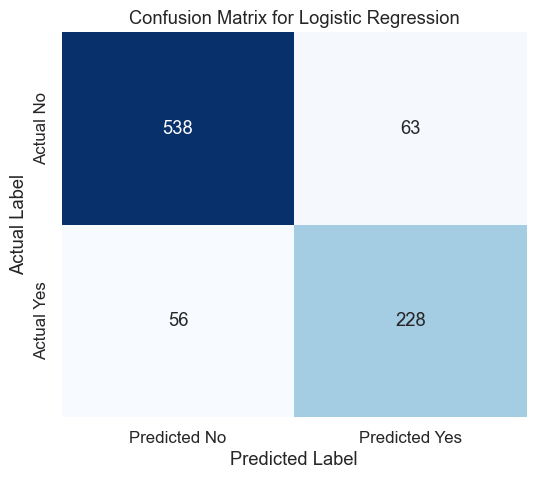


Classification Report:
              precision    recall  f1-score   support

 Non-dropout       0.91      0.90      0.90       601
     Dropout       0.78      0.80      0.79       284

    accuracy                           0.87       885
   macro avg       0.84      0.85      0.85       885
weighted avg       0.87      0.87      0.87       885



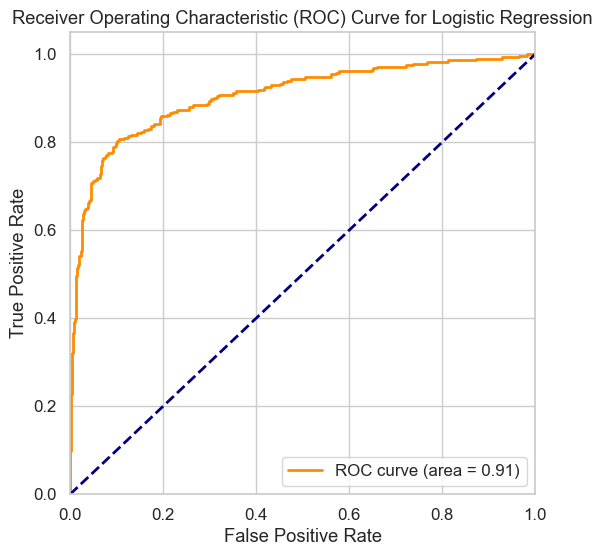

Model  Accuracy  Precision_No  Recall_No     F1_No  \
0  Logistic Regression  0.865537      0.905724   0.895175  0.900418   

   Precision_Yes  Recall_Yes    F1_Yes   ROC_AUC  
0       0.783505    0.802817  0.793043  0.906482

In [40]:
print("\nMelatih Model Regresi Logistik...")

log_model = LogisticRegression(random_state=42, solver='liblinear', C=0.1, class_weight='balanced')
log_model.fit(X_train_resampled, y_train_resampled)
lg_metrics = evaluate_model("Logistic Regression", log_model, X_test, y_test)
df_lg_metrics = pd.DataFrame([lg_metrics])
df_lg_metrics

### Random Forest


Melatih Model Random Forest Classifier...

--- Evaluasi Model: Random Forest Classifier ---


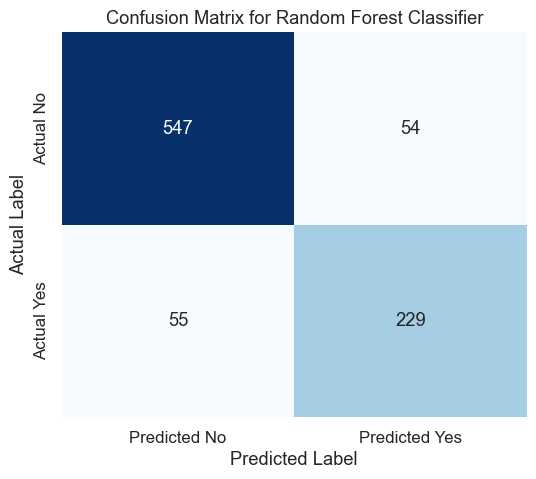


Classification Report:
              precision    recall  f1-score   support

 Non-dropout       0.91      0.91      0.91       601
     Dropout       0.81      0.81      0.81       284

    accuracy                           0.88       885
   macro avg       0.86      0.86      0.86       885
weighted avg       0.88      0.88      0.88       885



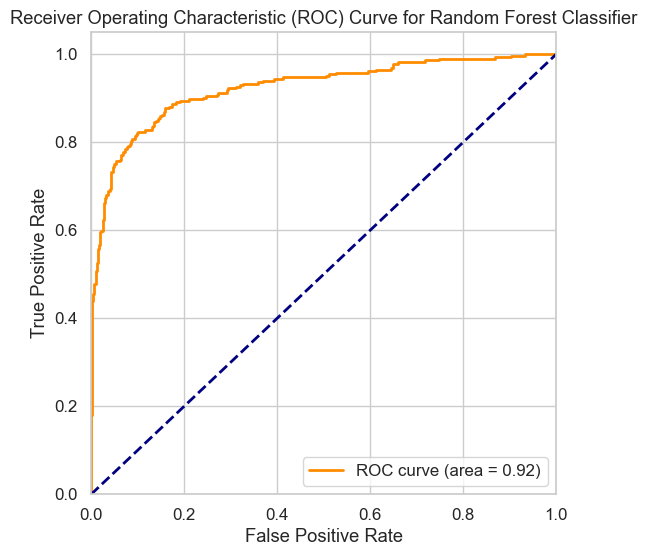

Model  Accuracy  Precision_No  Recall_No     F1_No  \
0  Random Forest Classifier  0.876836      0.908638    0.91015  0.909393   

   Precision_Yes  Recall_Yes   F1_Yes   ROC_AUC  
0       0.809187    0.806338  0.80776  0.923994

In [41]:
print("\nMelatih Model Random Forest Classifier...")

rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)

rf_metrics = evaluate_model("Random Forest Classifier", rf_model, X_test, y_test)
df_rf_metrics = pd.DataFrame([rf_metrics])
df_rf_metrics

### XGBoost


--- Melatih Model XGBoost Classifier ---


c:\Users\LENOVO\anaconda3\envs\basic-ml\lib\site-packages\xgboost\core.py:158: UserWarning: [12:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Evaluasi Model: XGBoost Classifier ---


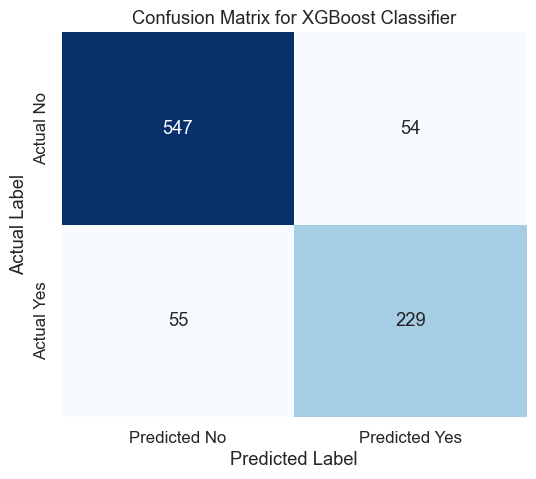


Classification Report:
              precision    recall  f1-score   support

 Non-dropout       0.91      0.91      0.91       601
     Dropout       0.81      0.81      0.81       284

    accuracy                           0.88       885
   macro avg       0.86      0.86      0.86       885
weighted avg       0.88      0.88      0.88       885



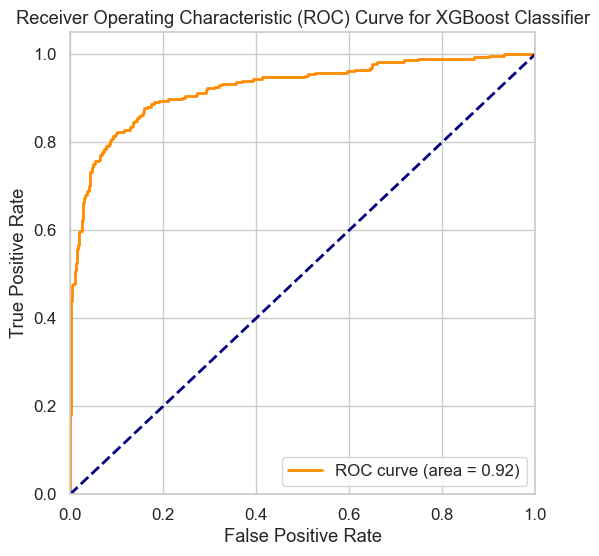

Model  Accuracy  Precision_No  Recall_No     F1_No  \
0  XGBoost Classifier  0.876836      0.908638    0.91015  0.909393   

   Precision_Yes  Recall_Yes   F1_Yes   ROC_AUC  
0       0.809187    0.806338  0.80776  0.923994

In [ ]:
print("\n--- Melatih Model XGBoost Classifier ---")
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

xgb_metrics = evaluate_model("XGBoost Classifier", rf_model, X_test, y_test)
df_xgb_metrics = pd.DataFrame([xgb_metrics])
df_xgb_metrics

## Evaluation

In [43]:
all_base_model_metrics_df = pd.concat([df_lg_metrics, df_rf_metrics, df_xgb_metrics], ignore_index=True)
all_base_model_metrics_df

Model  Accuracy  Precision_No  Recall_No     F1_No  \
0       Logistic Regression  0.865537      0.905724   0.895175  0.900418   
1  Random Forest Classifier  0.876836      0.908638   0.910150  0.909393   
2        XGBoost Classifier  0.876836      0.908638   0.910150  0.909393   

   Precision_Yes  Recall_Yes    F1_Yes   ROC_AUC  
0       0.783505    0.802817  0.793043  0.906482  
1       0.809187    0.806338  0.807760  0.923994  
2       0.809187    0.806338  0.807760  0.923994

## Deployment

### Export

In [44]:
output_dir = 'models'
os.makedirs(output_dir, exist_ok=True)

model_filename = os.path.join(output_dir, 'xgboost_classifier_model.joblib')

joblib.dump(xgb_model, model_filename)

print(f"\nXGBoost model exported to: {model_filename}")


XGBoost model exported to: models\xgboost_classifier_model.joblib


In [45]:
final_feature_names = X_train_resampled.columns.tolist()

feature_names_path = os.path.join(output_dir, 'final_feature_names.txt')
with open(feature_names_path, 'w') as f:
    for item in final_feature_names:
        f.write(f"{item}\n")

print(f"\nDaftar nama fitur akhir berhasil diekspor ke: {feature_names_path}")


Daftar nama fitur akhir berhasil diekspor ke: models\final_feature_names.txt
